In [29]:
# Basic libraries
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
from math import ceil
from collections import defaultdict
from tqdm.notebook import tqdm
# Deep learning framework for building and training models
import tensorflow as tf

## Pre-trained model for image feature extraction
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

## Tokenizer class for captions tokenization
from tensorflow.keras.preprocessing.text import Tokenizer

## Function for padding sequences to a specific length
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Class for defining Keras models
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, concatenate, Bidirectional, Dot, Activation, RepeatVector, Multiply, Lambda
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Embedding, SimpleRNN, Bidirectional, RepeatVector, 
    Dot, Activation, Lambda, concatenate, BatchNormalization
)
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
# For checking score
from nltk.translate.bleu_score import corpus_bleu

In [30]:
# Setting the input and output directory
INPUT_DIR = './'
OUTPUT_DIR = './image_name'

In [31]:
# We are going to use pretraind vgg model
# Load the vgg16 model
model = VGG16()

# Restructuring the model to remove the last classification layer, this will give us access to the output features of the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

# Printing the model summary
print(model.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [32]:
# Initialize an empty dictionary to store image features
image_features = {}

# Define the directory path where images are located
img_dir = os.path.join(INPUT_DIR, 'Images')

# Loop through each image in the directory
for img_name in tqdm(os.listdir(img_dir)):
    # Load the image from file
    img_path = os.path.join(img_dir, img_name)
    image = load_img(img_path, target_size=(224, 224))
    # Convert image pixels to a numpy array
    image = img_to_array(image)
    # Reshape the data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # Preprocess the image for ResNet50
    image = preprocess_input(image)
    # Extract features using the pre-trained ResNet50 model
    image_feature = model.predict(image, verbose=0)
    # Get the image ID by removing the file extension
    image_id = img_name.split('.')[0]
    # Store the extracted feature in the dictionary with the image ID as the key
    image_features[image_id] = image_feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [33]:
# Store the image features in pickle
pickle.dump(image_features, open(os.path.join(OUTPUT_DIR, 'image_feature.pkl'), 'wb'))

In [34]:
# Load features from pickle file
pickle_file_path = os.path.join(OUTPUT_DIR, 'image_feature.pkl')
with open(pickle_file_path, 'rb') as file:
    loaded_features = pickle.load(file)

In [35]:
with open(os.path.join(INPUT_DIR, 'captions.txt'), 'r') as file:
    next(file)
    captions_doc = file.read()

In [36]:
# Create mapping of image to captions
image_to_captions_mapping = defaultdict(list)

# Process lines from captions_doc
for line in tqdm(captions_doc.split('\n')):
    # Split the line by comma(,)
    tokens = line.split(',')
    if len(tokens) < 2:
        continue
    image_id, *captions = tokens
    # Remove extension from image ID
    image_id = image_id.split('.')[0]
    # Convert captions list to string
    caption = " ".join(captions)
    # Store the caption using defaultdict
    image_to_captions_mapping[image_id].append(caption)

# Print the total number of captions
total_captions = sum(len(captions) for captions in image_to_captions_mapping.values())
print("Total number of captions:", total_captions)

  0%|          | 0/40460 [00:00<?, ?it/s]

Total number of captions: 2447


In [37]:
# Function for processing the captions
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # Take one caption at a time
            caption = captions[i]
            # Preprocessing steps
            # Convert to lowercase
            caption = caption.lower()
            # Remove non-alphabetical characters
            caption = ''.join(char for char in caption if char.isalpha() or char.isspace())
            # Remove extra spaces
            caption = caption.replace('\s+', ' ')
            # Add unique start and end tokens to the caption
            caption = 'startseq ' + ' '.join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            captions[i] = caption

In [38]:
# Creating a List of All Captions
all_captions = [caption for captions in image_to_captions_mapping.values() for caption in captions]

In [39]:
all_captions[:10]


[' a red ball next to it .',
 ' stands on shore shaking off water',
 ' facing the water and the city skyline .',
 ' being held by the male   sitting next to a pond with a near by stroller .',
 ' with stick .',
 ' standing on an ice   looking into something covered with a blue tarp .',
 ' man in background watches .',
 ' as seen from behind her .',
 ' one with a yellow and orange ball   play in some water in front of a field .',
 ' as seen from behind .']

In [40]:
# Tokenizing the Text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

In [41]:
# Save the tokenizer
with open('tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

# Load the tokenizer
with open('tokenizer.pkl', 'rb') as tokenizer_file:
    tokenizer = pickle.load(tokenizer_file)

In [42]:
# Calculate maximum caption length
max_caption_length = max(len(tokenizer.texts_to_sequences([caption])[0]) for caption in all_captions)
vocab_size = len(tokenizer.word_index) + 1

# Print the results
print("Vocabulary Size:", vocab_size)
print("Maximum Caption Length:", max_caption_length)

Vocabulary Size: 2102
Maximum Caption Length: 24


In [43]:
# Creating a List of Image IDs
image_ids = list(image_to_captions_mapping.keys())
# Splitting into Training and Test Sets
split = int(len(image_ids) * 0.80)
train = image_ids[:split]
test = image_ids[split:]

In [44]:
# Data generator function
def data_generator(data_keys, image_to_captions_mapping, features, tokenizer, max_caption_length, vocab_size, batch_size):
    # Lists to store batch data
    X1_batch, X2_batch, y_batch = [], [], []
    # Counter for the current batch size
    batch_count = 0

    while True:
        # Loop through each image in the current batch
        for image_id in data_keys: 
            # Get the captions associated with the current image
            captions = image_to_captions_mapping[image_id]

            # Loop through each caption for the current image
            for caption in captions:
                # Convert the caption to a sequence of token IDs
                caption_seq = tokenizer.texts_to_sequences([caption])[0]

                # Loop through the tokens in the caption sequence
                for i in range(1, len(caption_seq)):
                    # Split the sequence into input and output pairs
                    in_seq, out_seq = caption_seq[:i], caption_seq[i]

                    # Pad the input sequence to the specified maximum caption length
                    in_seq = pad_sequences([in_seq], maxlen=max_caption_length)[0]

                    # Convert the output sequence to one-hot encoded format
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # Append data to batch lists
                    X1_batch.append(features[image_id][0])  # Image features
                    X2_batch.append(in_seq)  # Input sequence
                    y_batch.append(out_seq)  # Output sequence

                    # Increase the batch counter
                    batch_count += 1

                    # If the batch is complete, yield the batch and reset lists and counter
                    if batch_count == batch_size:
                        X1_batch, X2_batch, y_batch = np.array(X1_batch), np.array(X2_batch), np.array(y_batch)
                        yield [X1_batch, X2_batch], y_batch
                        X1_batch, X2_batch, y_batch = [], [], []
                        batch_count = 0

2025-04-25 14:44:56.245856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-04-25 14:44:56.246770: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-04-25 14:44:56.247907: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

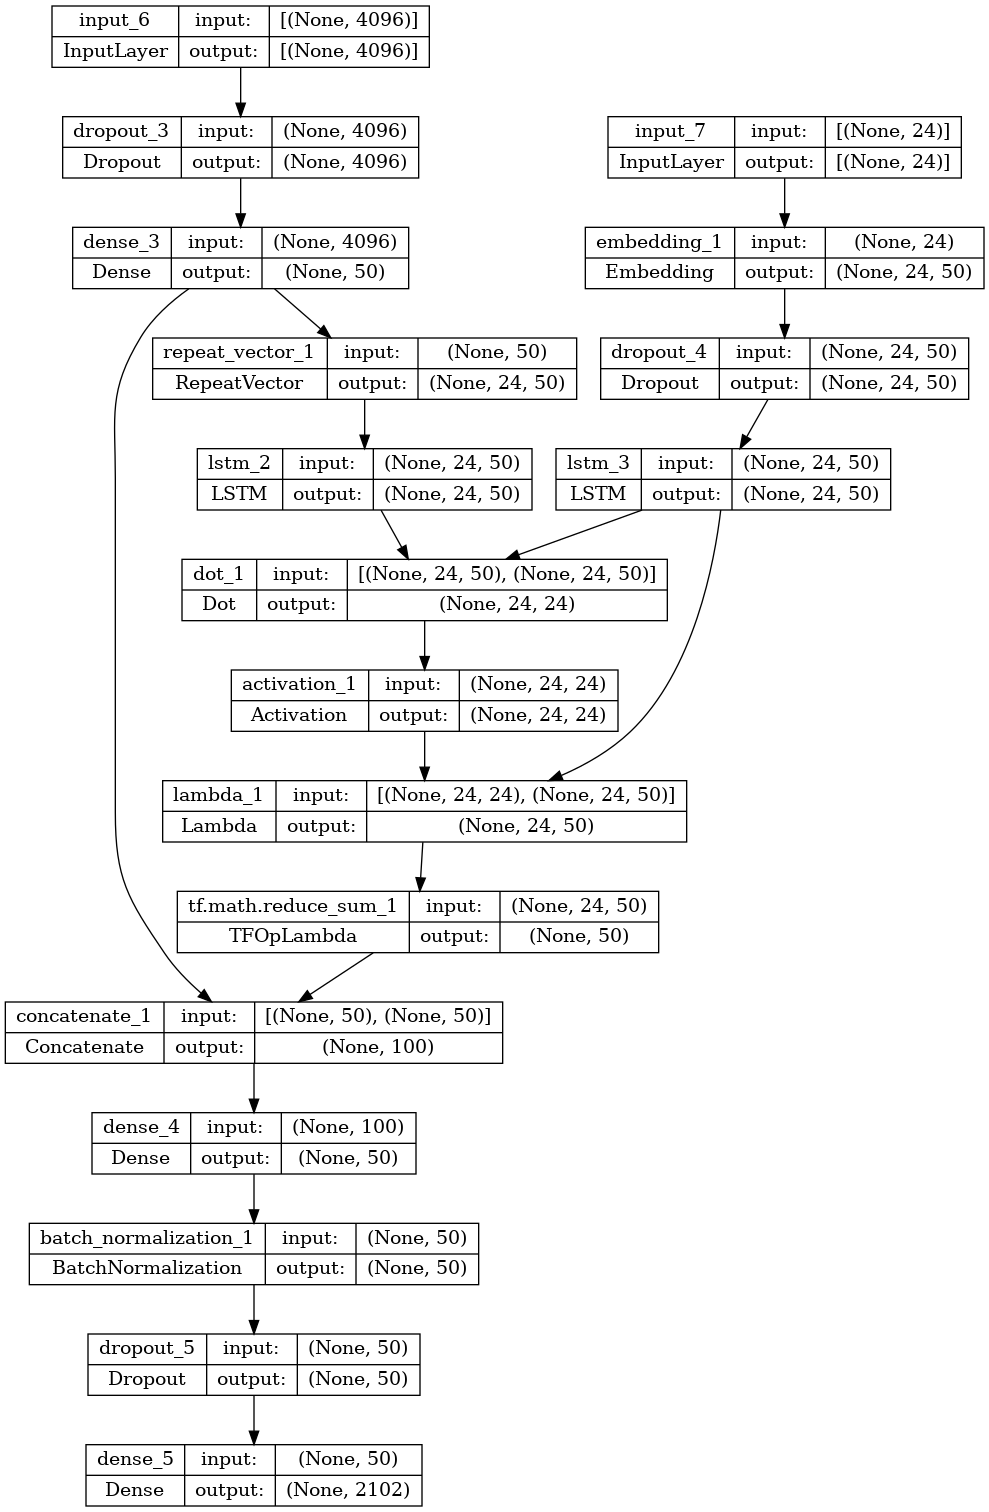

In [45]:
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.optimizers import Adam


inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.3)(inputs1)
fe2 = Dense(50, activation='relu')(fe1)
fe2_projected = RepeatVector(max_caption_length)(fe2)
fe2_projected = LSTM(50, return_sequences=True)(fe2_projected)

# Sequence feature layers
inputs2 = Input(shape=(max_caption_length,))
se1 = Embedding(vocab_size, 50, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(50, return_sequences=True)(se2)

'''
# Encoder model
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.3)(inputs1)
fe2 = Dense(50, activation='relu', kernel_regularizer=l2(0.01))(fe1)  # L2 Regularization
fe2_projected = RepeatVector(max_caption_length)(fe2)
fe2_projected = Bidirectional(SimpleRNN(50, return_sequences=True, kernel_regularizer=l2(0.01)))(fe2_projected)

# Sequence feature layers
inputs2 = Input(shape=(max_caption_length,))
se1 = Embedding(vocab_size, 50, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = Bidirectional(SimpleRNN(50, return_sequences=True, kernel_regularizer=l2(0.01)))(se2)

'''
# Apply attention mechanism using Dot product
attention = Dot(axes=[2, 2])([fe2_projected, se3])  # Calculate attention scores

# Softmax attention scores
attention_scores = Activation('softmax')(attention)

# Apply attention scores to sequence embeddings
attention_context = Lambda(lambda x: tf.einsum('ijk,ijl->ikl', x[0], x[1]))([attention_scores, se3])

# Sum the attended sequence embeddings along the time axis
context_vector = tf.reduce_sum(attention_context, axis=1)

# Decoder model
decoder_input = concatenate([context_vector, fe2], axis=-1)
decoder1 = Dense(50, activation='relu', kernel_regularizer=l2(0.01))(decoder_input)  # L2 Regularization
decoder1 = BatchNormalization()(decoder1)  # Batch Normalization
decoder1 = Dropout(0.3)(decoder1)  # Dropout
outputs = Dense(vocab_size, activation='softmax')(decoder1)

# Create the model
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Visualize the model
plot_model(model, show_shapes=True)

Epoch 1/100
Epoch 1/10


2025-04-25 14:44:56.908288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-04-25 14:44:57.601720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-04-25 14:44:57.603154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra

27/27 [==============================] - ETA: 0s - loss: 8.2304 - accuracy: 0.0023  

2025-04-25 14:45:01.629039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-04-25 14:45:02.181465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-04-25 14:45:02.183350: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra

27/27 [==============================] - 6s 85ms/step - loss: 8.2304 - accuracy: 0.0023 - val_loss: 8.1992 - val_accuracy: 0.0000e+00
Epoch 2/10
27/27 [==============================] - 1s 51ms/step - loss: 8.0311 - accuracy: 0.0150 - val_loss: 7.9769 - val_accuracy: 0.0156
Epoch 3/10
27/27 [==============================] - 2s 56ms/step - loss: 7.8461 - accuracy: 0.0226 - val_loss: 7.7404 - val_accuracy: 0.0357
Epoch 4/10
27/27 [==============================] - 1s 51ms/step - loss: 7.6798 - accuracy: 0.0179 - val_loss: 7.7258 - val_accuracy: 0.0179
Epoch 5/10
27/27 [==============================] - 1s 47ms/step - loss: 7.4549 - accuracy: 0.0260 - val_loss: 7.4097 - val_accuracy: 0.0223
Epoch 6/10
27/27 [==============================] - 1s 47ms/step - loss: 7.2576 - accuracy: 0.0295 - val_loss: 7.1245 - val_accuracy: 0.0335
Epoch 7/10
27/27 [==============================] - 2s 60ms/step - loss: 6.9995 - accuracy: 0.0515 - val_loss: 6.8719 - val_accuracy: 0.0357
Epoch 8/10
27/27 [==

2025-04-25 14:45:15.596822: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 52ms/step - loss: 5.8132 - accuracy: 0.0949 - val_loss: 5.9229 - val_accuracy: 0.0915
Epoch 2/10
 1/27 [>.............................] - ETA: 1s - loss: 5.7185 - accuracy: 0.1094

2025-04-25 14:45:16.895093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 48ms/step - loss: 5.6802 - accuracy: 0.0822 - val_loss: 6.1392 - val_accuracy: 0.0692
Epoch 3/10
27/27 [==============================] - 1s 48ms/step - loss: 5.6418 - accuracy: 0.0972 - val_loss: 5.6096 - val_accuracy: 0.1183
Epoch 4/10
27/27 [==============================] - 1s 44ms/step - loss: 5.7232 - accuracy: 0.0822 - val_loss: 5.9207 - val_accuracy: 0.0871
Epoch 5/10
27/27 [==============================] - 1s 52ms/step - loss: 5.7851 - accuracy: 0.0851 - val_loss: 6.2939 - val_accuracy: 0.0915
Epoch 6/10
27/27 [==============================] - 1s 46ms/step - loss: 5.7874 - accuracy: 0.0920 - val_loss: 5.9748 - val_accuracy: 0.0982
Epoch 7/10
27/27 [==============================] - 1s 50ms/step - loss: 5.6668 - accuracy: 0.0995 - val_loss: 6.1896 - val_accuracy: 0.0982
Epoch 8/10
27/27 [==============================] - 2s 60ms/step - loss: 5.4625 - accuracy: 0.1001 - val_loss: 5.9696 - val_accuracy: 0.0714
Epoch 9/10
27/27 [======

2025-04-25 14:45:29.339367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 45ms/step - loss: 5.3335 - accuracy: 0.1024 - val_loss: 5.8366 - val_accuracy: 0.0982
Epoch 2/10
 1/27 [>.............................] - ETA: 1s - loss: 5.3706 - accuracy: 0.1094

2025-04-25 14:45:30.469183: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 48ms/step - loss: 5.3337 - accuracy: 0.0966 - val_loss: 6.1361 - val_accuracy: 0.0759
Epoch 3/10
27/27 [==============================] - 2s 56ms/step - loss: 5.3971 - accuracy: 0.1094 - val_loss: 5.6062 - val_accuracy: 0.1205
Epoch 4/10
27/27 [==============================] - 1s 44ms/step - loss: 5.5718 - accuracy: 0.0891 - val_loss: 5.9363 - val_accuracy: 0.0781
Epoch 5/10
27/27 [==============================] - 1s 47ms/step - loss: 5.6359 - accuracy: 0.0816 - val_loss: 5.8545 - val_accuracy: 0.0960
Epoch 6/10
27/27 [==============================] - 1s 47ms/step - loss: 5.6421 - accuracy: 0.0943 - val_loss: 6.0063 - val_accuracy: 0.0871
Epoch 7/10
27/27 [==============================] - 1s 48ms/step - loss: 5.5435 - accuracy: 0.1013 - val_loss: 6.1059 - val_accuracy: 0.0982
Epoch 8/10
27/27 [==============================] - 1s 45ms/step - loss: 5.3190 - accuracy: 0.0978 - val_loss: 5.9750 - val_accuracy: 0.0759
Epoch 9/10
27/27 [======

2025-04-25 14:45:42.122865: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 51ms/step - loss: 5.1962 - accuracy: 0.1013 - val_loss: 6.9858 - val_accuracy: 0.0960
Epoch 2/10
 1/27 [>.............................] - ETA: 1s - loss: 5.3026 - accuracy: 0.1406

2025-04-25 14:45:43.375737: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 52ms/step - loss: 5.1750 - accuracy: 0.1088 - val_loss: 6.4145 - val_accuracy: 0.0759
Epoch 3/10
27/27 [==============================] - 1s 51ms/step - loss: 5.2303 - accuracy: 0.1088 - val_loss: 5.6236 - val_accuracy: 0.1094
Epoch 4/10
27/27 [==============================] - 1s 54ms/step - loss: 5.5045 - accuracy: 0.0880 - val_loss: 5.8999 - val_accuracy: 0.0871
Epoch 5/10
27/27 [==============================] - 2s 65ms/step - loss: 5.5131 - accuracy: 0.0868 - val_loss: 5.9274 - val_accuracy: 0.0960
Epoch 6/10
27/27 [==============================] - 1s 53ms/step - loss: 5.5300 - accuracy: 0.0932 - val_loss: 5.9981 - val_accuracy: 0.0915
Epoch 7/10
27/27 [==============================] - 1s 51ms/step - loss: 5.4787 - accuracy: 0.0995 - val_loss: 6.7752 - val_accuracy: 0.0915
Epoch 8/10
27/27 [==============================] - 1s 50ms/step - loss: 5.1718 - accuracy: 0.1001 - val_loss: 6.1043 - val_accuracy: 0.0737
Epoch 9/10
27/27 [======

2025-04-25 14:45:56.259532: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 50ms/step - loss: 5.0269 - accuracy: 0.1082 - val_loss: 5.8763 - val_accuracy: 0.0848
Epoch 2/10


2025-04-25 14:45:57.469846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 50ms/step - loss: 5.0205 - accuracy: 0.1053 - val_loss: 6.1951 - val_accuracy: 0.0647
Epoch 3/10
27/27 [==============================] - 1s 53ms/step - loss: 5.0431 - accuracy: 0.1134 - val_loss: 5.5912 - val_accuracy: 0.1071
Epoch 4/10
27/27 [==============================] - 1s 53ms/step - loss: 5.3529 - accuracy: 0.0949 - val_loss: 5.9327 - val_accuracy: 0.0781
Epoch 5/10
27/27 [==============================] - 1s 52ms/step - loss: 5.4177 - accuracy: 0.0966 - val_loss: 5.8473 - val_accuracy: 0.0938
Epoch 6/10
27/27 [==============================] - 2s 57ms/step - loss: 5.4427 - accuracy: 0.0909 - val_loss: 6.0888 - val_accuracy: 0.0982
Epoch 7/10
27/27 [==============================] - 1s 52ms/step - loss: 5.3451 - accuracy: 0.1007 - val_loss: 6.2957 - val_accuracy: 0.1027
Epoch 8/10
27/27 [==============================] - 2s 60ms/step - loss: 5.0281 - accuracy: 0.1140 - val_loss: 6.0394 - val_accuracy: 0.0714
Epoch 9/10
27/27 [======

2025-04-25 14:46:10.735633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 51ms/step - loss: 4.8118 - accuracy: 0.1192 - val_loss: 6.3082 - val_accuracy: 0.0871
Epoch 2/10
 1/27 [>.............................] - ETA: 1s - loss: 4.7427 - accuracy: 0.1406

2025-04-25 14:46:11.984140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 51ms/step - loss: 4.8203 - accuracy: 0.1042 - val_loss: 6.2204 - val_accuracy: 0.0759
Epoch 3/10
27/27 [==============================] - 1s 50ms/step - loss: 4.8618 - accuracy: 0.1198 - val_loss: 5.5438 - val_accuracy: 0.0982
Epoch 4/10
27/27 [==============================] - 1s 50ms/step - loss: 5.2331 - accuracy: 0.0995 - val_loss: 5.9534 - val_accuracy: 0.0804
Epoch 5/10
27/27 [==============================] - 1s 48ms/step - loss: 5.2763 - accuracy: 0.0984 - val_loss: 5.8418 - val_accuracy: 0.1027
Epoch 6/10
27/27 [==============================] - 1s 50ms/step - loss: 5.2774 - accuracy: 0.1001 - val_loss: 6.0140 - val_accuracy: 0.0759
Epoch 7/10
27/27 [==============================] - 1s 49ms/step - loss: 5.1887 - accuracy: 0.1059 - val_loss: 6.2439 - val_accuracy: 0.1027
Epoch 8/10
27/27 [==============================] - 1s 53ms/step - loss: 4.8292 - accuracy: 0.1209 - val_loss: 6.0243 - val_accuracy: 0.0893
Epoch 9/10
27/27 [======

2025-04-25 14:46:24.474254: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 62ms/step - loss: 4.6300 - accuracy: 0.1238 - val_loss: 5.8444 - val_accuracy: 0.0915
Epoch 2/10
 1/27 [>.............................] - ETA: 1s - loss: 4.5604 - accuracy: 0.1250

2025-04-25 14:46:26.027192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 52ms/step - loss: 4.6067 - accuracy: 0.1233 - val_loss: 6.1638 - val_accuracy: 0.0737
Epoch 3/10
27/27 [==============================] - 1s 55ms/step - loss: 4.5985 - accuracy: 0.1348 - val_loss: 5.5144 - val_accuracy: 0.1295
Epoch 4/10
27/27 [==============================] - 1s 55ms/step - loss: 5.0438 - accuracy: 0.1204 - val_loss: 5.9744 - val_accuracy: 0.0915
Epoch 5/10
27/27 [==============================] - 1s 49ms/step - loss: 5.1331 - accuracy: 0.1105 - val_loss: 5.8147 - val_accuracy: 0.1071
Epoch 6/10
27/27 [==============================] - 1s 52ms/step - loss: 5.0981 - accuracy: 0.1152 - val_loss: 6.0242 - val_accuracy: 0.1004
Epoch 7/10
27/27 [==============================] - 1s 49ms/step - loss: 5.0014 - accuracy: 0.1279 - val_loss: 6.0824 - val_accuracy: 0.1004
Epoch 8/10
27/27 [==============================] - 2s 57ms/step - loss: 4.6133 - accuracy: 0.1406 - val_loss: 6.0611 - val_accuracy: 0.0893
Epoch 9/10
27/27 [======

2025-04-25 14:46:39.155992: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 55ms/step - loss: 4.4093 - accuracy: 0.1435 - val_loss: 5.8478 - val_accuracy: 0.1049
Epoch 2/10
 1/27 [>.............................] - ETA: 0s - loss: 4.3863 - accuracy: 0.1719

2025-04-25 14:46:40.505283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 51ms/step - loss: 4.4077 - accuracy: 0.1418 - val_loss: 6.1954 - val_accuracy: 0.0893
Epoch 3/10
27/27 [==============================] - 1s 51ms/step - loss: 4.3804 - accuracy: 0.1609 - val_loss: 5.5001 - val_accuracy: 0.1250
Epoch 4/10
27/27 [==============================] - 1s 50ms/step - loss: 4.8919 - accuracy: 0.1244 - val_loss: 6.0046 - val_accuracy: 0.1049
Epoch 5/10
27/27 [==============================] - 1s 49ms/step - loss: 4.9741 - accuracy: 0.1244 - val_loss: 5.7909 - val_accuracy: 0.1049
Epoch 6/10
27/27 [==============================] - 1s 49ms/step - loss: 4.9665 - accuracy: 0.1169 - val_loss: 6.2416 - val_accuracy: 0.0960
Epoch 7/10
27/27 [==============================] - 1s 51ms/step - loss: 4.8867 - accuracy: 0.1412 - val_loss: 6.1559 - val_accuracy: 0.1272
Epoch 8/10
27/27 [==============================] - 1s 50ms/step - loss: 4.4172 - accuracy: 0.1441 - val_loss: 6.0291 - val_accuracy: 0.0938
Epoch 9/10
27/27 [======

2025-04-25 14:46:52.927611: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 55ms/step - loss: 4.1655 - accuracy: 0.1690 - val_loss: 5.8582 - val_accuracy: 0.1071
Epoch 2/10
 1/27 [>.............................] - ETA: 1s - loss: 4.1043 - accuracy: 0.1719

2025-04-25 14:46:54.300884: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 51ms/step - loss: 4.1879 - accuracy: 0.1672 - val_loss: 6.3194 - val_accuracy: 0.0938
Epoch 3/10
27/27 [==============================] - 1s 48ms/step - loss: 4.1512 - accuracy: 0.1782 - val_loss: 5.4512 - val_accuracy: 0.1295
Epoch 4/10
27/27 [==============================] - 2s 60ms/step - loss: 4.7812 - accuracy: 0.1302 - val_loss: 5.9062 - val_accuracy: 0.1295
Epoch 5/10
27/27 [==============================] - 2s 55ms/step - loss: 4.8506 - accuracy: 0.1372 - val_loss: 5.8526 - val_accuracy: 0.1094
Epoch 6/10
27/27 [==============================] - 2s 61ms/step - loss: 4.8793 - accuracy: 0.1267 - val_loss: 6.1189 - val_accuracy: 0.0982
Epoch 7/10
27/27 [==============================] - 2s 64ms/step - loss: 4.7945 - accuracy: 0.1343 - val_loss: 6.1423 - val_accuracy: 0.1339
Epoch 8/10
27/27 [==============================] - 2s 61ms/step - loss: 4.2844 - accuracy: 0.1615 - val_loss: 6.1188 - val_accuracy: 0.0893
Epoch 9/10
27/27 [======

2025-04-25 14:47:08.652101: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 58ms/step - loss: 4.0073 - accuracy: 0.1863 - val_loss: 5.7789 - val_accuracy: 0.1183
Epoch 2/10
 1/27 [>.............................] - ETA: 1s - loss: 3.9134 - accuracy: 0.2188

2025-04-25 14:47:10.115965: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 53ms/step - loss: 4.0208 - accuracy: 0.1892 - val_loss: 6.2309 - val_accuracy: 0.0938
Epoch 3/10
27/27 [==============================] - 1s 53ms/step - loss: 3.9805 - accuracy: 0.1910 - val_loss: 5.4579 - val_accuracy: 0.1629
Epoch 4/10
27/27 [==============================] - 1s 51ms/step - loss: 4.6319 - accuracy: 0.1481 - val_loss: 5.9629 - val_accuracy: 0.1317
Epoch 5/10
27/27 [==============================] - 2s 56ms/step - loss: 4.7539 - accuracy: 0.1395 - val_loss: 5.9388 - val_accuracy: 0.1116
Epoch 6/10
27/27 [==============================] - 1s 52ms/step - loss: 4.7500 - accuracy: 0.1343 - val_loss: 6.0974 - val_accuracy: 0.1183
Epoch 7/10
27/27 [==============================] - 1s 52ms/step - loss: 4.6596 - accuracy: 0.1429 - val_loss: 6.1197 - val_accuracy: 0.1317
Epoch 8/10
27/27 [==============================] - 1s 48ms/step - loss: 4.1071 - accuracy: 0.1811 - val_loss: 6.0803 - val_accuracy: 0.1094
Epoch 9/10
27/27 [======

2025-04-25 14:47:23.324003: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 66ms/step - loss: 3.8955 - accuracy: 0.1933 - val_loss: 5.7674 - val_accuracy: 0.1317
Epoch 2/10


2025-04-25 14:47:25.023924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 51ms/step - loss: 3.8761 - accuracy: 0.1979 - val_loss: 6.2452 - val_accuracy: 0.1071
Epoch 3/10
27/27 [==============================] - 2s 62ms/step - loss: 3.8507 - accuracy: 0.1985 - val_loss: 5.5338 - val_accuracy: 0.1473
Epoch 4/10
27/27 [==============================] - 2s 61ms/step - loss: 4.5481 - accuracy: 0.1615 - val_loss: 6.0701 - val_accuracy: 0.1138
Epoch 5/10
27/27 [==============================] - 1s 54ms/step - loss: 4.6094 - accuracy: 0.1493 - val_loss: 5.9480 - val_accuracy: 0.1161
Epoch 6/10
27/27 [==============================] - 1s 51ms/step - loss: 4.6395 - accuracy: 0.1493 - val_loss: 6.1498 - val_accuracy: 0.1205
Epoch 7/10
27/27 [==============================] - 1s 50ms/step - loss: 4.5442 - accuracy: 0.1557 - val_loss: 6.3886 - val_accuracy: 0.1362
Epoch 8/10
27/27 [==============================] - 1s 54ms/step - loss: 3.9749 - accuracy: 0.1794 - val_loss: 6.0736 - val_accuracy: 0.1250
Epoch 9/10
27/27 [======

2025-04-25 14:47:38.425685: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 55ms/step - loss: 3.7125 - accuracy: 0.2402 - val_loss: 5.8984 - val_accuracy: 0.1406
Epoch 2/10


2025-04-25 14:47:39.754212: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 55ms/step - loss: 3.7268 - accuracy: 0.2106 - val_loss: 6.4027 - val_accuracy: 0.1183
Epoch 3/10
27/27 [==============================] - 1s 53ms/step - loss: 3.7142 - accuracy: 0.2350 - val_loss: 5.4099 - val_accuracy: 0.1562
Epoch 4/10
27/27 [==============================] - 1s 52ms/step - loss: 4.4179 - accuracy: 0.1626 - val_loss: 6.0301 - val_accuracy: 0.1138
Epoch 5/10
27/27 [==============================] - 1s 52ms/step - loss: 4.4849 - accuracy: 0.1678 - val_loss: 5.8819 - val_accuracy: 0.1228
Epoch 6/10
27/27 [==============================] - 1s 55ms/step - loss: 4.5178 - accuracy: 0.1632 - val_loss: 6.0770 - val_accuracy: 0.1250
Epoch 7/10
27/27 [==============================] - 1s 54ms/step - loss: 4.4187 - accuracy: 0.1626 - val_loss: 6.2011 - val_accuracy: 0.1406
Epoch 8/10
27/27 [==============================] - 1s 52ms/step - loss: 3.8317 - accuracy: 0.1997 - val_loss: 6.1220 - val_accuracy: 0.1339
Epoch 9/10
27/27 [======

2025-04-25 14:47:52.833302: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 62ms/step - loss: 3.5174 - accuracy: 0.2390 - val_loss: 5.8738 - val_accuracy: 0.1451
Epoch 2/10


2025-04-25 14:47:54.359821: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 57ms/step - loss: 3.5677 - accuracy: 0.2245 - val_loss: 6.3769 - val_accuracy: 0.1183
Epoch 3/10
27/27 [==============================] - 2s 61ms/step - loss: 3.5549 - accuracy: 0.2407 - val_loss: 5.3057 - val_accuracy: 0.1853
Epoch 4/10
27/27 [==============================] - 2s 56ms/step - loss: 4.2743 - accuracy: 0.1782 - val_loss: 5.9779 - val_accuracy: 0.1473
Epoch 5/10
27/27 [==============================] - 1s 52ms/step - loss: 4.3712 - accuracy: 0.1667 - val_loss: 5.8473 - val_accuracy: 0.1362
Epoch 6/10
27/27 [==============================] - 1s 49ms/step - loss: 4.4271 - accuracy: 0.1742 - val_loss: 6.0992 - val_accuracy: 0.1228
Epoch 7/10
27/27 [==============================] - 1s 50ms/step - loss: 4.3048 - accuracy: 0.1725 - val_loss: 6.3304 - val_accuracy: 0.1585
Epoch 8/10
27/27 [==============================] - 1s 48ms/step - loss: 3.6826 - accuracy: 0.2199 - val_loss: 6.1889 - val_accuracy: 0.1205
Epoch 9/10
27/27 [======

2025-04-25 14:48:07.719986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 52ms/step - loss: 3.4232 - accuracy: 0.2564 - val_loss: 5.8362 - val_accuracy: 0.1652
Epoch 2/10
 1/27 [>.............................] - ETA: 1s - loss: 3.1946 - accuracy: 0.3438

2025-04-25 14:48:09.041632: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 53ms/step - loss: 3.4342 - accuracy: 0.2500 - val_loss: 6.3497 - val_accuracy: 0.1183
Epoch 3/10
27/27 [==============================] - 2s 56ms/step - loss: 3.4474 - accuracy: 0.2569 - val_loss: 5.3423 - val_accuracy: 0.1897
Epoch 4/10
27/27 [==============================] - 1s 55ms/step - loss: 4.1537 - accuracy: 0.1898 - val_loss: 6.0657 - val_accuracy: 0.1339
Epoch 5/10
27/27 [==============================] - 1s 52ms/step - loss: 4.2516 - accuracy: 0.1771 - val_loss: 5.8241 - val_accuracy: 0.1362
Epoch 6/10
27/27 [==============================] - 1s 53ms/step - loss: 4.3337 - accuracy: 0.1765 - val_loss: 6.1990 - val_accuracy: 0.1295
Epoch 7/10
27/27 [==============================] - 1s 48ms/step - loss: 4.1803 - accuracy: 0.1800 - val_loss: 6.2683 - val_accuracy: 0.1518
Epoch 8/10
27/27 [==============================] - 1s 52ms/step - loss: 3.5329 - accuracy: 0.2402 - val_loss: 6.2001 - val_accuracy: 0.1362
Epoch 9/10
27/27 [======

2025-04-25 14:48:21.809565: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 53ms/step - loss: 3.3364 - accuracy: 0.2639 - val_loss: 5.9263 - val_accuracy: 0.1317
Epoch 2/10
 1/27 [>.............................] - ETA: 1s - loss: 3.2296 - accuracy: 0.2969

2025-04-25 14:48:23.112247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 58ms/step - loss: 3.3271 - accuracy: 0.2506 - val_loss: 6.3734 - val_accuracy: 0.1295
Epoch 3/10
27/27 [==============================] - 2s 58ms/step - loss: 3.3622 - accuracy: 0.2714 - val_loss: 5.4241 - val_accuracy: 0.1897
Epoch 4/10
27/27 [==============================] - 2s 60ms/step - loss: 4.1475 - accuracy: 0.1806 - val_loss: 6.0170 - val_accuracy: 0.1496
Epoch 5/10
27/27 [==============================] - 2s 59ms/step - loss: 4.1895 - accuracy: 0.1782 - val_loss: 5.7727 - val_accuracy: 0.1496
Epoch 6/10
27/27 [==============================] - 1s 53ms/step - loss: 4.2200 - accuracy: 0.1875 - val_loss: 6.2633 - val_accuracy: 0.1272
Epoch 7/10
27/27 [==============================] - 1s 47ms/step - loss: 4.1425 - accuracy: 0.1881 - val_loss: 6.5938 - val_accuracy: 0.1406
Epoch 8/10
27/27 [==============================] - 1s 53ms/step - loss: 3.5508 - accuracy: 0.2315 - val_loss: 6.7919 - val_accuracy: 0.1451
Epoch 9/10
27/27 [======

2025-04-25 14:48:37.472845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - ETA: 0s - loss: 3.2483 - accuracy: 0.2795

2025-04-25 14:48:39.077004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 68ms/step - loss: 3.2483 - accuracy: 0.2795 - val_loss: 6.0209 - val_accuracy: 0.1585
Epoch 2/10
27/27 [==============================] - 2s 62ms/step - loss: 3.2446 - accuracy: 0.2749 - val_loss: 6.4752 - val_accuracy: 0.1339
Epoch 3/10
27/27 [==============================] - 2s 65ms/step - loss: 3.2677 - accuracy: 0.2859 - val_loss: 5.3621 - val_accuracy: 0.1897
Epoch 4/10
27/27 [==============================] - 2s 64ms/step - loss: 4.0692 - accuracy: 0.1829 - val_loss: 6.1115 - val_accuracy: 0.1071
Epoch 5/10
27/27 [==============================] - 2s 59ms/step - loss: 4.1102 - accuracy: 0.1933 - val_loss: 5.9626 - val_accuracy: 0.1295
Epoch 6/10
27/27 [==============================] - 2s 62ms/step - loss: 4.1535 - accuracy: 0.1858 - val_loss: 6.2209 - val_accuracy: 0.1138
Epoch 7/10
27/27 [==============================] - 2s 69ms/step - loss: 4.0515 - accuracy: 0.1985 - val_loss: 6.4760 - val_accuracy: 0.1607
Epoch 8/10
27/27 [======

2025-04-25 14:48:54.056639: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 49ms/step - loss: 3.1826 - accuracy: 0.2911 - val_loss: 5.9950 - val_accuracy: 0.1339
Epoch 2/10
 1/27 [>.............................] - ETA: 1s - loss: 3.0431 - accuracy: 0.3125

2025-04-25 14:48:55.288236: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 48ms/step - loss: 3.2149 - accuracy: 0.2650 - val_loss: 6.4279 - val_accuracy: 0.1295
Epoch 3/10
27/27 [==============================] - 1s 50ms/step - loss: 3.1941 - accuracy: 0.2911 - val_loss: 5.4791 - val_accuracy: 0.2054
Epoch 4/10
27/27 [==============================] - 1s 53ms/step - loss: 3.9815 - accuracy: 0.2176 - val_loss: 6.1774 - val_accuracy: 0.1429
Epoch 5/10
27/27 [==============================] - 2s 74ms/step - loss: 4.0228 - accuracy: 0.1939 - val_loss: 6.0241 - val_accuracy: 0.1205
Epoch 6/10
27/27 [==============================] - 2s 67ms/step - loss: 4.0830 - accuracy: 0.1921 - val_loss: 6.2254 - val_accuracy: 0.1384
Epoch 7/10
27/27 [==============================] - 2s 66ms/step - loss: 3.9423 - accuracy: 0.2083 - val_loss: 6.5020 - val_accuracy: 0.1518
Epoch 8/10
27/27 [==============================] - 2s 77ms/step - loss: 3.2592 - accuracy: 0.2882 - val_loss: 6.2911 - val_accuracy: 0.1473
Epoch 9/10
27/27 [======

2025-04-25 14:49:11.620174: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - ETA: 0s - loss: 3.0675 - accuracy: 0.2951

2025-04-25 14:49:13.615767: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 83ms/step - loss: 3.0675 - accuracy: 0.2951 - val_loss: 6.0468 - val_accuracy: 0.1585
Epoch 2/10
27/27 [==============================] - 2s 78ms/step - loss: 3.1657 - accuracy: 0.2760 - val_loss: 6.4781 - val_accuracy: 0.1339
Epoch 3/10
27/27 [==============================] - 2s 83ms/step - loss: 3.0988 - accuracy: 0.2957 - val_loss: 5.5146 - val_accuracy: 0.1897
Epoch 4/10
27/27 [==============================] - 2s 81ms/step - loss: 3.8442 - accuracy: 0.2049 - val_loss: 6.2482 - val_accuracy: 0.1183
Epoch 5/10
27/27 [==============================] - 2s 80ms/step - loss: 3.9474 - accuracy: 0.1863 - val_loss: 5.9075 - val_accuracy: 0.1451
Epoch 6/10
27/27 [==============================] - 2s 60ms/step - loss: 3.9782 - accuracy: 0.1944 - val_loss: 6.3223 - val_accuracy: 0.1317
Epoch 7/10
27/27 [==============================] - 1s 52ms/step - loss: 3.9118 - accuracy: 0.2031 - val_loss: 6.6508 - val_accuracy: 0.1652
Epoch 8/10
27/27 [======

2025-04-25 14:49:29.929214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 67ms/step - loss: 3.0233 - accuracy: 0.3160 - val_loss: 6.0315 - val_accuracy: 0.1518
Epoch 2/10


2025-04-25 14:49:31.597611: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 52ms/step - loss: 3.0304 - accuracy: 0.3015 - val_loss: 6.6237 - val_accuracy: 0.1362
Epoch 3/10
27/27 [==============================] - 1s 55ms/step - loss: 3.0677 - accuracy: 0.3090 - val_loss: 5.5191 - val_accuracy: 0.2076
Epoch 4/10
27/27 [==============================] - 2s 57ms/step - loss: 3.8510 - accuracy: 0.2159 - val_loss: 6.3439 - val_accuracy: 0.1496
Epoch 5/10
27/27 [==============================] - 1s 48ms/step - loss: 3.9107 - accuracy: 0.2193 - val_loss: 6.1422 - val_accuracy: 0.1339
Epoch 6/10
27/27 [==============================] - 2s 61ms/step - loss: 3.9796 - accuracy: 0.1910 - val_loss: 6.4304 - val_accuracy: 0.1183
Epoch 7/10
27/27 [==============================] - 2s 62ms/step - loss: 3.8700 - accuracy: 0.2083 - val_loss: 6.5265 - val_accuracy: 0.1362
Epoch 8/10
27/27 [==============================] - 2s 72ms/step - loss: 3.1887 - accuracy: 0.2824 - val_loss: 9.7595 - val_accuracy: 0.1429
Epoch 9/10
27/27 [======

2025-04-25 14:49:47.068381: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 89ms/step - loss: 2.9714 - accuracy: 0.3194 - val_loss: 6.1373 - val_accuracy: 0.1540
Epoch 2/10


2025-04-25 14:49:49.339479: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 60ms/step - loss: 3.0123 - accuracy: 0.3050 - val_loss: 6.6761 - val_accuracy: 0.1317
Epoch 3/10
27/27 [==============================] - 1s 55ms/step - loss: 3.0300 - accuracy: 0.3113 - val_loss: 5.5655 - val_accuracy: 0.1920
Epoch 4/10
27/27 [==============================] - 1s 54ms/step - loss: 3.8130 - accuracy: 0.2141 - val_loss: 6.2895 - val_accuracy: 0.1518
Epoch 5/10
27/27 [==============================] - 1s 52ms/step - loss: 3.8378 - accuracy: 0.2112 - val_loss: 6.1882 - val_accuracy: 0.1317
Epoch 6/10
27/27 [==============================] - 1s 50ms/step - loss: 3.9569 - accuracy: 0.2118 - val_loss: 6.4743 - val_accuracy: 0.1250
Epoch 7/10
27/27 [==============================] - 1s 46ms/step - loss: 3.7695 - accuracy: 0.2234 - val_loss: 6.6548 - val_accuracy: 0.1540
Epoch 8/10
27/27 [==============================] - 1s 54ms/step - loss: 3.0911 - accuracy: 0.2992 - val_loss: 6.5013 - val_accuracy: 0.1406
Epoch 9/10
27/27 [======

2025-04-25 14:50:02.213232: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 50ms/step - loss: 2.9044 - accuracy: 0.3310 - val_loss: 6.1655 - val_accuracy: 0.1317
Epoch 2/10
 1/27 [>.............................] - ETA: 1s - loss: 2.7215 - accuracy: 0.2812

2025-04-25 14:50:03.460616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 51ms/step - loss: 2.9940 - accuracy: 0.3096 - val_loss: 6.6394 - val_accuracy: 0.1362
Epoch 3/10
27/27 [==============================] - 1s 51ms/step - loss: 2.9789 - accuracy: 0.3160 - val_loss: 5.6074 - val_accuracy: 0.1920
Epoch 4/10
27/27 [==============================] - 1s 47ms/step - loss: 3.7639 - accuracy: 0.2089 - val_loss: 6.2652 - val_accuracy: 0.1496
Epoch 5/10
27/27 [==============================] - 1s 51ms/step - loss: 3.7554 - accuracy: 0.2303 - val_loss: 6.1250 - val_accuracy: 0.1429
Epoch 6/10
27/27 [==============================] - 1s 51ms/step - loss: 3.8693 - accuracy: 0.2106 - val_loss: 6.3858 - val_accuracy: 0.1406
Epoch 7/10
27/27 [==============================] - 1s 52ms/step - loss: 3.7383 - accuracy: 0.2234 - val_loss: 6.6700 - val_accuracy: 0.1518
Epoch 8/10
27/27 [==============================] - 1s 50ms/step - loss: 3.0947 - accuracy: 0.3137 - val_loss: 6.5798 - val_accuracy: 0.1473
Epoch 9/10
27/27 [======

2025-04-25 14:50:15.837893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 52ms/step - loss: 2.8656 - accuracy: 0.3374 - val_loss: 6.1803 - val_accuracy: 0.1585
Epoch 2/10
 1/27 [>.............................] - ETA: 1s - loss: 2.8151 - accuracy: 0.3438

2025-04-25 14:50:17.123851: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 50ms/step - loss: 2.9026 - accuracy: 0.3235 - val_loss: 6.6735 - val_accuracy: 0.1317
Epoch 3/10
27/27 [==============================] - 1s 54ms/step - loss: 2.9344 - accuracy: 0.3264 - val_loss: 5.5380 - val_accuracy: 0.1920
Epoch 4/10
27/27 [==============================] - 1s 52ms/step - loss: 3.7100 - accuracy: 0.2390 - val_loss: 6.4693 - val_accuracy: 0.1429
Epoch 5/10
27/27 [==============================] - 1s 50ms/step - loss: 3.7915 - accuracy: 0.2124 - val_loss: 6.1086 - val_accuracy: 0.1228
Epoch 6/10
27/27 [==============================] - 1s 52ms/step - loss: 3.8396 - accuracy: 0.2112 - val_loss: 6.5412 - val_accuracy: 0.1406
Epoch 7/10
27/27 [==============================] - 1s 51ms/step - loss: 3.6688 - accuracy: 0.2297 - val_loss: 6.6843 - val_accuracy: 0.1540
Epoch 8/10
27/27 [==============================] - 1s 51ms/step - loss: 3.0319 - accuracy: 0.3148 - val_loss: 6.6133 - val_accuracy: 0.1362
Epoch 9/10
27/27 [======

2025-04-25 14:50:29.767850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 55ms/step - loss: 2.8451 - accuracy: 0.3461 - val_loss: 6.3153 - val_accuracy: 0.1585
Epoch 2/10


2025-04-25 14:50:31.138249: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 68ms/step - loss: 2.8513 - accuracy: 0.3142 - val_loss: 6.7699 - val_accuracy: 0.1183
Epoch 3/10
27/27 [==============================] - 2s 63ms/step - loss: 2.9097 - accuracy: 0.3304 - val_loss: 5.5839 - val_accuracy: 0.1987
Epoch 4/10
27/27 [==============================] - 2s 65ms/step - loss: 3.7079 - accuracy: 0.2384 - val_loss: 6.5107 - val_accuracy: 0.1228
Epoch 5/10
27/27 [==============================] - 2s 71ms/step - loss: 3.6638 - accuracy: 0.2269 - val_loss: 6.0584 - val_accuracy: 0.1429
Epoch 6/10
27/27 [==============================] - 2s 61ms/step - loss: 3.7651 - accuracy: 0.2159 - val_loss: 6.4522 - val_accuracy: 0.1406
Epoch 7/10
27/27 [==============================] - 2s 56ms/step - loss: 3.6029 - accuracy: 0.2442 - val_loss: 6.7207 - val_accuracy: 0.1629
Epoch 8/10
27/27 [==============================] - 2s 65ms/step - loss: 3.0775 - accuracy: 0.3021 - val_loss: 6.7648 - val_accuracy: 0.1496
Epoch 9/10
27/27 [======

2025-04-25 14:50:46.415476: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 60ms/step - loss: 2.8192 - accuracy: 0.3484 - val_loss: 6.3915 - val_accuracy: 0.1540
Epoch 2/10
 1/27 [>.............................] - ETA: 1s - loss: 2.6610 - accuracy: 0.3906

2025-04-25 14:50:47.927388: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 54ms/step - loss: 2.8664 - accuracy: 0.3241 - val_loss: 6.8256 - val_accuracy: 0.1429
Epoch 3/10
27/27 [==============================] - 1s 53ms/step - loss: 2.8730 - accuracy: 0.3380 - val_loss: 5.7232 - val_accuracy: 0.1853
Epoch 4/10
27/27 [==============================] - 2s 57ms/step - loss: 3.5919 - accuracy: 0.2373 - val_loss: 6.4893 - val_accuracy: 0.1473
Epoch 5/10
27/27 [==============================] - 1s 51ms/step - loss: 3.6574 - accuracy: 0.2338 - val_loss: 6.1469 - val_accuracy: 0.1540
Epoch 6/10
27/27 [==============================] - 2s 59ms/step - loss: 3.7162 - accuracy: 0.2350 - val_loss: 6.3794 - val_accuracy: 0.1362
Epoch 7/10
27/27 [==============================] - 1s 53ms/step - loss: 3.6065 - accuracy: 0.2315 - val_loss: 6.7324 - val_accuracy: 0.1585
Epoch 8/10
27/27 [==============================] - 1s 55ms/step - loss: 2.9494 - accuracy: 0.3160 - val_loss: 6.7406 - val_accuracy: 0.1339
Epoch 9/10
27/27 [======

2025-04-25 14:51:01.349089: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 55ms/step - loss: 2.7241 - accuracy: 0.3600 - val_loss: 6.3360 - val_accuracy: 0.1607
Epoch 2/10
 1/27 [>.............................] - ETA: 1s - loss: 2.5326 - accuracy: 0.4375

2025-04-25 14:51:02.731579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 58ms/step - loss: 2.8452 - accuracy: 0.3316 - val_loss: 6.7909 - val_accuracy: 0.1071
Epoch 3/10
27/27 [==============================] - 1s 54ms/step - loss: 2.8202 - accuracy: 0.3507 - val_loss: 5.6186 - val_accuracy: 0.1808
Epoch 4/10
27/27 [==============================] - 1s 53ms/step - loss: 3.6166 - accuracy: 0.2413 - val_loss: 6.5953 - val_accuracy: 0.1406
Epoch 5/10
27/27 [==============================] - 2s 58ms/step - loss: 3.6368 - accuracy: 0.2350 - val_loss: 6.0913 - val_accuracy: 0.1384
Epoch 6/10
27/27 [==============================] - 2s 56ms/step - loss: 3.6613 - accuracy: 0.2251 - val_loss: 6.5329 - val_accuracy: 0.1451
Epoch 7/10
27/27 [==============================] - 1s 54ms/step - loss: 3.5538 - accuracy: 0.2373 - val_loss: 6.7841 - val_accuracy: 0.1451
Epoch 8/10
27/27 [==============================] - 1s 51ms/step - loss: 2.9272 - accuracy: 0.3084 - val_loss: 6.7635 - val_accuracy: 0.1473
Epoch 9/10
27/27 [======

2025-04-25 14:51:16.208287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 58ms/step - loss: 2.7272 - accuracy: 0.3669 - val_loss: 6.1989 - val_accuracy: 0.1562
Epoch 2/10


2025-04-25 14:51:17.657535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 55ms/step - loss: 2.7966 - accuracy: 0.3258 - val_loss: 7.0091 - val_accuracy: 0.1295
Epoch 3/10
27/27 [==============================] - 1s 52ms/step - loss: 2.8429 - accuracy: 0.3304 - val_loss: 5.7248 - val_accuracy: 0.2232
Epoch 4/10
27/27 [==============================] - 1s 55ms/step - loss: 3.5814 - accuracy: 0.2384 - val_loss: 6.7087 - val_accuracy: 0.1339
Epoch 5/10
27/27 [==============================] - 1s 51ms/step - loss: 3.5348 - accuracy: 0.2535 - val_loss: 6.2903 - val_accuracy: 0.1362
Epoch 6/10
27/27 [==============================] - 1s 54ms/step - loss: 3.6239 - accuracy: 0.2517 - val_loss: 6.5649 - val_accuracy: 0.1339
Epoch 7/10
27/27 [==============================] - 2s 58ms/step - loss: 3.5330 - accuracy: 0.2269 - val_loss: 6.9523 - val_accuracy: 0.1652
Epoch 8/10
27/27 [==============================] - 2s 57ms/step - loss: 2.9153 - accuracy: 0.3397 - val_loss: 6.8490 - val_accuracy: 0.1473
Epoch 9/10
27/27 [======

2025-04-25 14:51:31.212420: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - ETA: 0s - loss: 2.7254 - accuracy: 0.3600

2025-04-25 14:51:32.763415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 65ms/step - loss: 2.7254 - accuracy: 0.3600 - val_loss: 6.3988 - val_accuracy: 0.1429
Epoch 2/10
27/27 [==============================] - 2s 57ms/step - loss: 2.7612 - accuracy: 0.3287 - val_loss: 6.8548 - val_accuracy: 0.1183
Epoch 3/10
27/27 [==============================] - 2s 59ms/step - loss: 2.7560 - accuracy: 0.3513 - val_loss: 5.6641 - val_accuracy: 0.2009
Epoch 4/10
27/27 [==============================] - 2s 58ms/step - loss: 3.5811 - accuracy: 0.2448 - val_loss: 6.7251 - val_accuracy: 0.1451
Epoch 5/10
27/27 [==============================] - 2s 58ms/step - loss: 3.5377 - accuracy: 0.2459 - val_loss: 6.2462 - val_accuracy: 0.1339
Epoch 6/10
27/27 [==============================] - 2s 67ms/step - loss: 3.6094 - accuracy: 0.2436 - val_loss: 6.6779 - val_accuracy: 0.1496
Epoch 7/10
27/27 [==============================] - 2s 64ms/step - loss: 3.5598 - accuracy: 0.2431 - val_loss: 6.9391 - val_accuracy: 0.1719
Epoch 8/10
27/27 [======

2025-04-25 14:51:47.694722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 67ms/step - loss: 2.6411 - accuracy: 0.3536 - val_loss: 6.4203 - val_accuracy: 0.1473
Epoch 2/10


2025-04-25 14:51:49.336199: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 60ms/step - loss: 2.6933 - accuracy: 0.3698 - val_loss: 6.9532 - val_accuracy: 0.1339
Epoch 3/10
27/27 [==============================] - 2s 63ms/step - loss: 2.7334 - accuracy: 0.3571 - val_loss: 5.6792 - val_accuracy: 0.2009
Epoch 4/10
27/27 [==============================] - 2s 62ms/step - loss: 3.5382 - accuracy: 0.2442 - val_loss: 6.6274 - val_accuracy: 0.1362
Epoch 5/10
27/27 [==============================] - 2s 57ms/step - loss: 3.4888 - accuracy: 0.2500 - val_loss: 6.4132 - val_accuracy: 0.1272
Epoch 6/10
27/27 [==============================] - 2s 60ms/step - loss: 3.5856 - accuracy: 0.2436 - val_loss: 6.5784 - val_accuracy: 0.1384
Epoch 7/10
27/27 [==============================] - 2s 62ms/step - loss: 3.5214 - accuracy: 0.2413 - val_loss: 6.8890 - val_accuracy: 0.1585
Epoch 8/10
27/27 [==============================] - 2s 57ms/step - loss: 2.8421 - accuracy: 0.3385 - val_loss: 6.8371 - val_accuracy: 0.1250
Epoch 9/10
27/27 [======

2025-04-25 14:52:03.949603: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 61ms/step - loss: 2.6775 - accuracy: 0.3576 - val_loss: 6.5221 - val_accuracy: 0.1562
Epoch 2/10


2025-04-25 14:52:05.449203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 58ms/step - loss: 2.7677 - accuracy: 0.3432 - val_loss: 7.1105 - val_accuracy: 0.1228
Epoch 3/10
27/27 [==============================] - 2s 58ms/step - loss: 2.7275 - accuracy: 0.3374 - val_loss: 5.7089 - val_accuracy: 0.2188
Epoch 4/10
27/27 [==============================] - 1s 52ms/step - loss: 3.5122 - accuracy: 0.2488 - val_loss: 6.6887 - val_accuracy: 0.1205
Epoch 5/10
27/27 [==============================] - 2s 57ms/step - loss: 3.4533 - accuracy: 0.2483 - val_loss: 6.2982 - val_accuracy: 0.1429
Epoch 6/10
27/27 [==============================] - 2s 58ms/step - loss: 3.5379 - accuracy: 0.2500 - val_loss: 6.6069 - val_accuracy: 0.1362
Epoch 7/10
27/27 [==============================] - 2s 59ms/step - loss: 3.5058 - accuracy: 0.2569 - val_loss: 6.8510 - val_accuracy: 0.1518
Epoch 8/10
27/27 [==============================] - 2s 57ms/step - loss: 2.8802 - accuracy: 0.3438 - val_loss: 6.8204 - val_accuracy: 0.1451
Epoch 9/10
27/27 [======

2025-04-25 14:52:19.910667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 64ms/step - loss: 2.6464 - accuracy: 0.3733 - val_loss: 6.5326 - val_accuracy: 0.1518
Epoch 2/10


2025-04-25 14:52:21.469114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 61ms/step - loss: 2.6910 - accuracy: 0.3542 - val_loss: 7.1512 - val_accuracy: 0.1473
Epoch 3/10
27/27 [==============================] - 2s 65ms/step - loss: 2.7088 - accuracy: 0.3600 - val_loss: 5.7970 - val_accuracy: 0.2143
Epoch 4/10
27/27 [==============================] - 2s 65ms/step - loss: 3.5097 - accuracy: 0.2500 - val_loss: 6.6652 - val_accuracy: 0.1562
Epoch 5/10
27/27 [==============================] - 2s 65ms/step - loss: 3.4259 - accuracy: 0.2378 - val_loss: 6.4220 - val_accuracy: 0.1205
Epoch 6/10
27/27 [==============================] - 2s 63ms/step - loss: 3.6301 - accuracy: 0.2240 - val_loss: 6.6640 - val_accuracy: 0.1295
Epoch 7/10
27/27 [==============================] - 2s 59ms/step - loss: 3.3808 - accuracy: 0.2552 - val_loss: 6.8400 - val_accuracy: 0.1607
Epoch 8/10
27/27 [==============================] - 2s 61ms/step - loss: 2.7932 - accuracy: 0.3449 - val_loss: 6.9624 - val_accuracy: 0.1518
Epoch 9/10
27/27 [======

2025-04-25 14:52:36.772475: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 59ms/step - loss: 2.6538 - accuracy: 0.3600 - val_loss: 6.5536 - val_accuracy: 0.1562
Epoch 2/10


2025-04-25 14:52:38.216309: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 62ms/step - loss: 2.6930 - accuracy: 0.3339 - val_loss: 7.0716 - val_accuracy: 0.1339
Epoch 3/10
27/27 [==============================] - 2s 60ms/step - loss: 2.6277 - accuracy: 0.3698 - val_loss: 5.8287 - val_accuracy: 0.2254
Epoch 4/10
27/27 [==============================] - 2s 63ms/step - loss: 3.4462 - accuracy: 0.2610 - val_loss: 6.8873 - val_accuracy: 0.1317
Epoch 5/10
27/27 [==============================] - 2s 81ms/step - loss: 3.3693 - accuracy: 0.2598 - val_loss: 6.3083 - val_accuracy: 0.1362
Epoch 6/10
27/27 [==============================] - 2s 64ms/step - loss: 3.4825 - accuracy: 0.2465 - val_loss: 6.5724 - val_accuracy: 0.1272
Epoch 7/10
27/27 [==============================] - 2s 60ms/step - loss: 3.4618 - accuracy: 0.2552 - val_loss: 6.9068 - val_accuracy: 0.1518
Epoch 8/10
27/27 [==============================] - 2s 60ms/step - loss: 2.7857 - accuracy: 0.3530 - val_loss: 7.0417 - val_accuracy: 0.1652
Epoch 9/10
27/27 [======

2025-04-25 14:52:53.601115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 55ms/step - loss: 2.5498 - accuracy: 0.3831 - val_loss: 6.5101 - val_accuracy: 0.1473
Epoch 2/10


2025-04-25 14:52:54.964866: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 68ms/step - loss: 2.6900 - accuracy: 0.3657 - val_loss: 7.0895 - val_accuracy: 0.1295
Epoch 3/10
27/27 [==============================] - 2s 60ms/step - loss: 2.6599 - accuracy: 0.3542 - val_loss: 5.7689 - val_accuracy: 0.2143
Epoch 4/10
27/27 [==============================] - 2s 65ms/step - loss: 3.4269 - accuracy: 0.2593 - val_loss: 6.7499 - val_accuracy: 0.1473
Epoch 5/10
27/27 [==============================] - 2s 61ms/step - loss: 3.3640 - accuracy: 0.2627 - val_loss: 6.4291 - val_accuracy: 0.1607
Epoch 6/10
27/27 [==============================] - 2s 65ms/step - loss: 3.4746 - accuracy: 0.2517 - val_loss: 6.6188 - val_accuracy: 0.1585
Epoch 7/10
27/27 [==============================] - 2s 68ms/step - loss: 3.3688 - accuracy: 0.2691 - val_loss: 6.9383 - val_accuracy: 0.1429
Epoch 8/10
27/27 [==============================] - 2s 73ms/step - loss: 2.7654 - accuracy: 0.3426 - val_loss: 7.1339 - val_accuracy: 0.1629
Epoch 9/10
27/27 [======

2025-04-25 14:53:11.039854: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 80ms/step - loss: 2.5937 - accuracy: 0.3646 - val_loss: 6.4377 - val_accuracy: 0.1607
Epoch 2/10


2025-04-25 14:53:13.048797: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 63ms/step - loss: 2.5905 - accuracy: 0.3744 - val_loss: 7.0131 - val_accuracy: 0.1384
Epoch 3/10
27/27 [==============================] - 2s 86ms/step - loss: 2.6167 - accuracy: 0.3594 - val_loss: 5.6971 - val_accuracy: 0.2143
Epoch 4/10
27/27 [==============================] - 2s 58ms/step - loss: 3.3533 - accuracy: 0.2760 - val_loss: 6.9195 - val_accuracy: 0.1496
Epoch 5/10
27/27 [==============================] - 2s 56ms/step - loss: 3.3483 - accuracy: 0.2500 - val_loss: 6.4567 - val_accuracy: 0.1406
Epoch 6/10
27/27 [==============================] - 2s 61ms/step - loss: 3.4847 - accuracy: 0.2523 - val_loss: 6.6389 - val_accuracy: 0.1362
Epoch 7/10
27/27 [==============================] - 2s 65ms/step - loss: 3.3202 - accuracy: 0.2697 - val_loss: 6.9942 - val_accuracy: 0.1786
Epoch 8/10
27/27 [==============================] - 2s 63ms/step - loss: 2.7427 - accuracy: 0.3530 - val_loss: 7.0981 - val_accuracy: 0.1473
Epoch 9/10
27/27 [======

2025-04-25 14:53:28.734255: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 64ms/step - loss: 2.5218 - accuracy: 0.3924 - val_loss: 6.5524 - val_accuracy: 0.1518
Epoch 2/10
 1/27 [>.............................] - ETA: 1s - loss: 2.3307 - accuracy: 0.4219

2025-04-25 14:53:30.330490: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 54ms/step - loss: 2.6081 - accuracy: 0.3594 - val_loss: 7.0043 - val_accuracy: 0.1228
Epoch 3/10
27/27 [==============================] - 1s 53ms/step - loss: 2.6246 - accuracy: 0.3721 - val_loss: 5.7373 - val_accuracy: 0.2076
Epoch 4/10
27/27 [==============================] - 1s 51ms/step - loss: 3.3678 - accuracy: 0.2731 - val_loss: 6.9077 - val_accuracy: 0.1562
Epoch 5/10
27/27 [==============================] - 1s 46ms/step - loss: 3.3399 - accuracy: 0.2726 - val_loss: 6.4388 - val_accuracy: 0.1562
Epoch 6/10
27/27 [==============================] - 1s 50ms/step - loss: 3.4575 - accuracy: 0.2737 - val_loss: 6.7253 - val_accuracy: 0.1473
Epoch 7/10
27/27 [==============================] - 1s 47ms/step - loss: 3.3191 - accuracy: 0.2679 - val_loss: 6.9061 - val_accuracy: 0.1585
Epoch 8/10
27/27 [==============================] - 1s 47ms/step - loss: 2.7060 - accuracy: 0.3617 - val_loss: 6.9295 - val_accuracy: 0.1362
Epoch 9/10
27/27 [======

2025-04-25 14:53:42.451400: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 71ms/step - loss: 2.5589 - accuracy: 0.3860 - val_loss: 6.5643 - val_accuracy: 0.1763


2025-04-25 14:53:44.180713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 2/10
27/27 [==============================] - 2s 67ms/step - loss: 2.6045 - accuracy: 0.3519 - val_loss: 7.3033 - val_accuracy: 0.1228
Epoch 3/10
27/27 [==============================] - 2s 64ms/step - loss: 2.6174 - accuracy: 0.3692 - val_loss: 5.9305 - val_accuracy: 0.2031
Epoch 4/10
27/27 [==============================] - 2s 64ms/step - loss: 3.4302 - accuracy: 0.2622 - val_loss: 6.9439 - val_accuracy: 0.1295
Epoch 5/10
27/27 [==============================] - 2s 58ms/step - loss: 3.2910 - accuracy: 0.2633 - val_loss: 6.5189 - val_accuracy: 0.1339
Epoch 6/10
27/27 [==============================] - 2s 56ms/step - loss: 3.4712 - accuracy: 0.2598 - val_loss: 6.8303 - val_accuracy: 0.1451
Epoch 7/10
27/27 [==============================] - 2s 57ms/step - loss: 3.3332 - accuracy: 0.2766 - val_loss: 6.9359 - val_accuracy: 0.1496
Epoch 8/10
27/27 [==============================] - 2s 59ms/step - loss: 2.7322 - accuracy: 0.3466 - val_loss: 7.0279 - val_accuracy: 0.1473
Epoch 9/10
27

2025-04-25 14:53:58.997570: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - ETA: 0s - loss: 2.5646 - accuracy: 0.3895

2025-04-25 14:54:00.662534: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 69ms/step - loss: 2.5646 - accuracy: 0.3895 - val_loss: 6.5848 - val_accuracy: 0.1496
Epoch 2/10
27/27 [==============================] - 2s 75ms/step - loss: 2.5538 - accuracy: 0.3819 - val_loss: 7.2280 - val_accuracy: 0.1362
Epoch 3/10
27/27 [==============================] - 2s 74ms/step - loss: 2.5923 - accuracy: 0.3802 - val_loss: 5.9172 - val_accuracy: 0.2165
Epoch 4/10
27/27 [==============================] - 2s 70ms/step - loss: 3.3140 - accuracy: 0.2801 - val_loss: 7.0893 - val_accuracy: 0.1451
Epoch 5/10
27/27 [==============================] - 2s 74ms/step - loss: 3.3177 - accuracy: 0.2789 - val_loss: 6.5861 - val_accuracy: 0.1384
Epoch 6/10
27/27 [==============================] - 2s 60ms/step - loss: 3.4595 - accuracy: 0.2662 - val_loss: 6.6886 - val_accuracy: 0.1339
Epoch 7/10
27/27 [==============================] - 2s 61ms/step - loss: 3.2954 - accuracy: 0.2604 - val_loss: 6.9578 - val_accuracy: 0.1451
Epoch 8/10
27/27 [======

2025-04-25 14:54:17.004428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 57ms/step - loss: 2.4929 - accuracy: 0.3953 - val_loss: 6.5859 - val_accuracy: 0.1674
Epoch 2/10


2025-04-25 14:54:18.386289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 65ms/step - loss: 2.5250 - accuracy: 0.3767 - val_loss: 7.2070 - val_accuracy: 0.1406
Epoch 3/10
27/27 [==============================] - 1s 52ms/step - loss: 2.5783 - accuracy: 0.3819 - val_loss: 5.8557 - val_accuracy: 0.2076
Epoch 4/10
27/27 [==============================] - 1s 56ms/step - loss: 3.3447 - accuracy: 0.2714 - val_loss: 6.9257 - val_accuracy: 0.1562
Epoch 5/10
27/27 [==============================] - 2s 61ms/step - loss: 3.3334 - accuracy: 0.2662 - val_loss: 6.5645 - val_accuracy: 0.1629
Epoch 6/10
27/27 [==============================] - 1s 55ms/step - loss: 3.4209 - accuracy: 0.2512 - val_loss: 6.8397 - val_accuracy: 0.1496
Epoch 7/10
27/27 [==============================] - 2s 57ms/step - loss: 3.2370 - accuracy: 0.2847 - val_loss: 7.0444 - val_accuracy: 0.1585
Epoch 8/10
27/27 [==============================] - 2s 58ms/step - loss: 2.6555 - accuracy: 0.3611 - val_loss: 6.9817 - val_accuracy: 0.1562
Epoch 9/10
27/27 [======

2025-04-25 14:54:32.686176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 56ms/step - loss: 2.5120 - accuracy: 0.3981 - val_loss: 6.6806 - val_accuracy: 0.1674
Epoch 2/10
 1/27 [>.............................] - ETA: 1s - loss: 2.0651 - accuracy: 0.4688

2025-04-25 14:54:34.087255: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 52ms/step - loss: 2.5342 - accuracy: 0.3756 - val_loss: 7.1531 - val_accuracy: 0.1429
Epoch 3/10
27/27 [==============================] - 2s 58ms/step - loss: 2.5440 - accuracy: 0.3987 - val_loss: 5.8304 - val_accuracy: 0.2121
Epoch 4/10
27/27 [==============================] - 1s 49ms/step - loss: 3.3168 - accuracy: 0.2662 - val_loss: 6.9012 - val_accuracy: 0.1295
Epoch 5/10
27/27 [==============================] - 1s 52ms/step - loss: 3.2188 - accuracy: 0.2760 - val_loss: 6.5935 - val_accuracy: 0.1362
Epoch 6/10
27/27 [==============================] - 2s 65ms/step - loss: 3.3483 - accuracy: 0.2749 - val_loss: 6.7817 - val_accuracy: 0.1451
Epoch 7/10
27/27 [==============================] - 2s 58ms/step - loss: 3.3232 - accuracy: 0.2639 - val_loss: 6.8919 - val_accuracy: 0.1473
Epoch 8/10
27/27 [==============================] - 1s 49ms/step - loss: 2.6429 - accuracy: 0.3715 - val_loss: 6.9579 - val_accuracy: 0.1540
Epoch 9/10
27/27 [======

2025-04-25 14:54:47.193713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 55ms/step - loss: 2.5428 - accuracy: 0.3767 - val_loss: 6.5666 - val_accuracy: 0.1674
Epoch 2/10


2025-04-25 14:54:48.533529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 64ms/step - loss: 2.5265 - accuracy: 0.3727 - val_loss: 7.2634 - val_accuracy: 0.1295
Epoch 3/10
27/27 [==============================] - 2s 58ms/step - loss: 2.5085 - accuracy: 0.3877 - val_loss: 5.8697 - val_accuracy: 0.2031
Epoch 4/10
27/27 [==============================] - 2s 62ms/step - loss: 3.3435 - accuracy: 0.2818 - val_loss: 7.1117 - val_accuracy: 0.1384
Epoch 5/10
27/27 [==============================] - 2s 59ms/step - loss: 3.2691 - accuracy: 0.2784 - val_loss: 6.4958 - val_accuracy: 0.1339
Epoch 6/10
27/27 [==============================] - 2s 58ms/step - loss: 3.4017 - accuracy: 0.2639 - val_loss: 6.8044 - val_accuracy: 0.1473
Epoch 7/10
27/27 [==============================] - 1s 55ms/step - loss: 3.2626 - accuracy: 0.2888 - val_loss: 7.0399 - val_accuracy: 0.1518
Epoch 8/10
27/27 [==============================] - 2s 56ms/step - loss: 2.6400 - accuracy: 0.3669 - val_loss: 6.9113 - val_accuracy: 0.1518
Epoch 9/10
27/27 [======

2025-04-25 14:55:02.958792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 59ms/step - loss: 2.4899 - accuracy: 0.3883 - val_loss: 7.4084 - val_accuracy: 0.1607
Epoch 2/10


2025-04-25 14:55:04.420265: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 57ms/step - loss: 2.5027 - accuracy: 0.3883 - val_loss: 7.2194 - val_accuracy: 0.1496
Epoch 3/10
27/27 [==============================] - 1s 53ms/step - loss: 2.4811 - accuracy: 0.3866 - val_loss: 5.9646 - val_accuracy: 0.2254
Epoch 4/10
27/27 [==============================] - 2s 58ms/step - loss: 3.2808 - accuracy: 0.2824 - val_loss: 7.0815 - val_accuracy: 0.1540
Epoch 5/10
27/27 [==============================] - 2s 60ms/step - loss: 3.1696 - accuracy: 0.2911 - val_loss: 6.5272 - val_accuracy: 0.1562
Epoch 6/10
27/27 [==============================] - 2s 61ms/step - loss: 3.3948 - accuracy: 0.2656 - val_loss: 6.8682 - val_accuracy: 0.1406
Epoch 7/10
27/27 [==============================] - 2s 59ms/step - loss: 3.2685 - accuracy: 0.2610 - val_loss: 7.1586 - val_accuracy: 0.1451
Epoch 8/10
27/27 [==============================] - 1s 55ms/step - loss: 2.5830 - accuracy: 0.3767 - val_loss: 7.1909 - val_accuracy: 0.1362
Epoch 9/10
27/27 [======

2025-04-25 14:55:18.461626: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 52ms/step - loss: 2.4280 - accuracy: 0.4149 - val_loss: 6.6546 - val_accuracy: 0.1496
Epoch 2/10
 1/27 [>.............................] - ETA: 1s - loss: 1.9650 - accuracy: 0.5156

2025-04-25 14:55:19.749022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 50ms/step - loss: 2.4921 - accuracy: 0.3987 - val_loss: 7.1687 - val_accuracy: 0.1451
Epoch 3/10
27/27 [==============================] - 1s 51ms/step - loss: 2.5119 - accuracy: 0.3872 - val_loss: 6.0576 - val_accuracy: 0.2009
Epoch 4/10
27/27 [==============================] - 1s 48ms/step - loss: 3.2258 - accuracy: 0.2963 - val_loss: 7.1015 - val_accuracy: 0.1339
Epoch 5/10
27/27 [==============================] - 1s 50ms/step - loss: 3.1289 - accuracy: 0.2876 - val_loss: 6.6055 - val_accuracy: 0.1518
Epoch 6/10
27/27 [==============================] - 1s 50ms/step - loss: 3.3444 - accuracy: 0.2801 - val_loss: 6.7852 - val_accuracy: 0.1161
Epoch 7/10
27/27 [==============================] - 1s 51ms/step - loss: 3.2691 - accuracy: 0.2853 - val_loss: 7.0233 - val_accuracy: 0.1429
Epoch 8/10
27/27 [==============================] - 1s 51ms/step - loss: 2.6198 - accuracy: 0.3727 - val_loss: 6.9394 - val_accuracy: 0.1518
Epoch 9/10
27/27 [======

2025-04-25 14:55:32.584152: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - ETA: 0s - loss: 2.4005 - accuracy: 0.4167

2025-04-25 14:55:34.536828: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 79ms/step - loss: 2.4005 - accuracy: 0.4167 - val_loss: 6.6577 - val_accuracy: 0.1473
Epoch 2/10
27/27 [==============================] - 2s 66ms/step - loss: 2.4733 - accuracy: 0.3837 - val_loss: 7.1812 - val_accuracy: 0.1562
Epoch 3/10
27/27 [==============================] - 2s 61ms/step - loss: 2.4652 - accuracy: 0.4057 - val_loss: 5.9487 - val_accuracy: 0.2232
Epoch 4/10
27/27 [==============================] - 2s 63ms/step - loss: 3.2659 - accuracy: 0.2847 - val_loss: 7.1054 - val_accuracy: 0.1183
Epoch 5/10
27/27 [==============================] - 2s 59ms/step - loss: 3.1982 - accuracy: 0.2882 - val_loss: 6.5269 - val_accuracy: 0.1496
Epoch 6/10
27/27 [==============================] - 2s 62ms/step - loss: 3.2816 - accuracy: 0.2812 - val_loss: 6.7250 - val_accuracy: 0.1496
Epoch 7/10
27/27 [==============================] - 2s 61ms/step - loss: 3.2360 - accuracy: 0.2743 - val_loss: 6.9984 - val_accuracy: 0.1540
Epoch 8/10
27/27 [======

2025-04-25 14:55:49.436636: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 66ms/step - loss: 2.4510 - accuracy: 0.4039 - val_loss: 6.8078 - val_accuracy: 0.1473
Epoch 2/10


2025-04-25 14:55:51.090370: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 54ms/step - loss: 2.4526 - accuracy: 0.3970 - val_loss: 7.3172 - val_accuracy: 0.1451
Epoch 3/10
27/27 [==============================] - 2s 61ms/step - loss: 2.4236 - accuracy: 0.4172 - val_loss: 5.9425 - val_accuracy: 0.2188
Epoch 4/10
27/27 [==============================] - 2s 57ms/step - loss: 3.2870 - accuracy: 0.2859 - val_loss: 7.1593 - val_accuracy: 0.1518
Epoch 5/10
27/27 [==============================] - 2s 59ms/step - loss: 3.1504 - accuracy: 0.2940 - val_loss: 6.7105 - val_accuracy: 0.1339
Epoch 6/10
27/27 [==============================] - 2s 56ms/step - loss: 3.3199 - accuracy: 0.2784 - val_loss: 6.7911 - val_accuracy: 0.1429
Epoch 7/10
27/27 [==============================] - 2s 56ms/step - loss: 3.1539 - accuracy: 0.2957 - val_loss: 6.9899 - val_accuracy: 0.1607
Epoch 8/10
27/27 [==============================] - 2s 59ms/step - loss: 2.5844 - accuracy: 0.3669 - val_loss: 6.9574 - val_accuracy: 0.1429
Epoch 9/10
27/27 [======

2025-04-25 14:56:05.363464: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 59ms/step - loss: 2.3772 - accuracy: 0.3947 - val_loss: 6.7257 - val_accuracy: 0.1719
Epoch 2/10


2025-04-25 14:56:06.833091: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 58ms/step - loss: 2.4597 - accuracy: 0.4138 - val_loss: 7.1520 - val_accuracy: 0.1317
Epoch 3/10
27/27 [==============================] - 2s 63ms/step - loss: 2.4934 - accuracy: 0.4028 - val_loss: 6.0815 - val_accuracy: 0.2098
Epoch 4/10
27/27 [==============================] - 2s 59ms/step - loss: 3.2972 - accuracy: 0.2737 - val_loss: 7.1026 - val_accuracy: 0.1585
Epoch 5/10
27/27 [==============================] - 2s 69ms/step - loss: 3.1528 - accuracy: 0.2847 - val_loss: 6.7711 - val_accuracy: 0.1406
Epoch 6/10
27/27 [==============================] - 2s 65ms/step - loss: 3.2457 - accuracy: 0.2876 - val_loss: 6.8826 - val_accuracy: 0.1518
Epoch 7/10
27/27 [==============================] - 1s 55ms/step - loss: 3.1747 - accuracy: 0.2865 - val_loss: 7.0862 - val_accuracy: 0.1518
Epoch 8/10
27/27 [==============================] - 1s 53ms/step - loss: 2.5485 - accuracy: 0.3727 - val_loss: 7.0400 - val_accuracy: 0.1562
Epoch 9/10
27/27 [======

2025-04-25 14:56:21.553835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 57ms/step - loss: 2.3732 - accuracy: 0.4109 - val_loss: 6.6912 - val_accuracy: 0.1629
Epoch 2/10


2025-04-25 14:56:22.949173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 56ms/step - loss: 2.4344 - accuracy: 0.3964 - val_loss: 7.2114 - val_accuracy: 0.1317
Epoch 3/10
27/27 [==============================] - 2s 56ms/step - loss: 2.4182 - accuracy: 0.4016 - val_loss: 6.0782 - val_accuracy: 0.1964
Epoch 4/10
27/27 [==============================] - 2s 65ms/step - loss: 3.2002 - accuracy: 0.2865 - val_loss: 7.0811 - val_accuracy: 0.1652
Epoch 5/10
27/27 [==============================] - 2s 60ms/step - loss: 3.1076 - accuracy: 0.3027 - val_loss: 6.6637 - val_accuracy: 0.1496
Epoch 6/10
27/27 [==============================] - 1s 53ms/step - loss: 3.3741 - accuracy: 0.2645 - val_loss: 6.8019 - val_accuracy: 0.1406
Epoch 7/10
27/27 [==============================] - 1s 53ms/step - loss: 3.1861 - accuracy: 0.2957 - val_loss: 7.0748 - val_accuracy: 0.1473
Epoch 8/10
27/27 [==============================] - 2s 62ms/step - loss: 2.5734 - accuracy: 0.3819 - val_loss: 6.9714 - val_accuracy: 0.1629
Epoch 9/10
27/27 [======

2025-04-25 14:56:37.258603: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 64ms/step - loss: 2.3587 - accuracy: 0.4201 - val_loss: 6.8376 - val_accuracy: 0.1719
Epoch 2/10


2025-04-25 14:56:38.837333: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 63ms/step - loss: 2.4596 - accuracy: 0.3883 - val_loss: 7.2965 - val_accuracy: 0.1362
Epoch 3/10
27/27 [==============================] - 2s 64ms/step - loss: 2.4896 - accuracy: 0.4062 - val_loss: 6.1288 - val_accuracy: 0.2098
Epoch 4/10
27/27 [==============================] - 2s 61ms/step - loss: 3.2035 - accuracy: 0.2836 - val_loss: 7.1989 - val_accuracy: 0.1339
Epoch 5/10
27/27 [==============================] - 2s 57ms/step - loss: 3.1131 - accuracy: 0.2951 - val_loss: 6.7959 - val_accuracy: 0.1384
Epoch 6/10
27/27 [==============================] - 1s 53ms/step - loss: 3.2707 - accuracy: 0.2859 - val_loss: 6.9088 - val_accuracy: 0.1384
Epoch 7/10
27/27 [==============================] - 2s 62ms/step - loss: 3.1675 - accuracy: 0.2859 - val_loss: 7.0774 - val_accuracy: 0.1473
Epoch 8/10
27/27 [==============================] - 2s 60ms/step - loss: 2.5074 - accuracy: 0.3953 - val_loss: 7.0837 - val_accuracy: 0.1763
Epoch 9/10
27/27 [======

2025-04-25 14:56:53.600701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 59ms/step - loss: 2.3535 - accuracy: 0.4062 - val_loss: 6.6668 - val_accuracy: 0.1540
Epoch 2/10
 1/27 [>.............................] - ETA: 1s - loss: 2.1350 - accuracy: 0.5312

2025-04-25 14:56:55.090024: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 51ms/step - loss: 2.4497 - accuracy: 0.4086 - val_loss: 7.1639 - val_accuracy: 0.1406
Epoch 3/10
27/27 [==============================] - 2s 62ms/step - loss: 2.4102 - accuracy: 0.4201 - val_loss: 6.0634 - val_accuracy: 0.2098
Epoch 4/10
27/27 [==============================] - 2s 64ms/step - loss: 3.1768 - accuracy: 0.3056 - val_loss: 7.1889 - val_accuracy: 0.1362
Epoch 5/10
27/27 [==============================] - 2s 59ms/step - loss: 3.1232 - accuracy: 0.3050 - val_loss: 6.7990 - val_accuracy: 0.1496
Epoch 6/10
27/27 [==============================] - 2s 62ms/step - loss: 3.2548 - accuracy: 0.2870 - val_loss: 6.8219 - val_accuracy: 0.1496
Epoch 7/10
27/27 [==============================] - 2s 59ms/step - loss: 3.1257 - accuracy: 0.2992 - val_loss: 7.1405 - val_accuracy: 0.1473
Epoch 8/10
27/27 [==============================] - 1s 50ms/step - loss: 2.5222 - accuracy: 0.3843 - val_loss: 7.1777 - val_accuracy: 0.1451
Epoch 9/10
27/27 [======

2025-04-25 14:57:09.588460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 58ms/step - loss: 2.3241 - accuracy: 0.4323 - val_loss: 6.6142 - val_accuracy: 0.1496
Epoch 2/10


2025-04-25 14:57:10.992767: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 62ms/step - loss: 2.4338 - accuracy: 0.3976 - val_loss: 7.2804 - val_accuracy: 0.1562
Epoch 3/10
27/27 [==============================] - 2s 57ms/step - loss: 2.4117 - accuracy: 0.4144 - val_loss: 6.1360 - val_accuracy: 0.2031
Epoch 4/10
27/27 [==============================] - 2s 59ms/step - loss: 3.1863 - accuracy: 0.2917 - val_loss: 7.2753 - val_accuracy: 0.1585
Epoch 5/10
27/27 [==============================] - 2s 61ms/step - loss: 3.1441 - accuracy: 0.2888 - val_loss: 6.8326 - val_accuracy: 0.1496
Epoch 6/10
27/27 [==============================] - 1s 52ms/step - loss: 3.1781 - accuracy: 0.2986 - val_loss: 6.8250 - val_accuracy: 0.1451
Epoch 7/10
27/27 [==============================] - 2s 60ms/step - loss: 3.1652 - accuracy: 0.2876 - val_loss: 7.2102 - val_accuracy: 0.1562
Epoch 8/10
27/27 [==============================] - 2s 62ms/step - loss: 2.4852 - accuracy: 0.4010 - val_loss: 7.0574 - val_accuracy: 0.1607
Epoch 9/10
27/27 [======

2025-04-25 14:57:25.622456: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 53ms/step - loss: 2.3418 - accuracy: 0.4265 - val_loss: 6.7543 - val_accuracy: 0.1719
Epoch 2/10
 1/27 [>.............................] - ETA: 1s - loss: 2.0328 - accuracy: 0.5312

2025-04-25 14:57:26.929622: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 55ms/step - loss: 2.4031 - accuracy: 0.4120 - val_loss: 7.4068 - val_accuracy: 0.1250
Epoch 3/10
27/27 [==============================] - 2s 58ms/step - loss: 2.3766 - accuracy: 0.4196 - val_loss: 6.2468 - val_accuracy: 0.2121
Epoch 4/10
27/27 [==============================] - 1s 55ms/step - loss: 3.1006 - accuracy: 0.2980 - val_loss: 7.2180 - val_accuracy: 0.1429
Epoch 5/10
27/27 [==============================] - 2s 64ms/step - loss: 3.0438 - accuracy: 0.3108 - val_loss: 6.8029 - val_accuracy: 0.1562
Epoch 6/10
27/27 [==============================] - 2s 62ms/step - loss: 3.2020 - accuracy: 0.2847 - val_loss: 6.7948 - val_accuracy: 0.1496
Epoch 7/10
27/27 [==============================] - 2s 61ms/step - loss: 3.1105 - accuracy: 0.2980 - val_loss: 7.1370 - val_accuracy: 0.1540
Epoch 8/10
27/27 [==============================] - 1s 52ms/step - loss: 2.4412 - accuracy: 0.3970 - val_loss: 7.1104 - val_accuracy: 0.1652
Epoch 9/10
27/27 [======

2025-04-25 14:57:41.307133: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 64ms/step - loss: 2.3508 - accuracy: 0.4126 - val_loss: 6.7380 - val_accuracy: 0.1763
Epoch 2/10


2025-04-25 14:57:42.907840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 57ms/step - loss: 2.3384 - accuracy: 0.4149 - val_loss: 7.2728 - val_accuracy: 0.1540
Epoch 3/10
27/27 [==============================] - 2s 62ms/step - loss: 2.3868 - accuracy: 0.4416 - val_loss: 6.1768 - val_accuracy: 0.2098
Epoch 4/10
27/27 [==============================] - 2s 61ms/step - loss: 3.2174 - accuracy: 0.3003 - val_loss: 7.2423 - val_accuracy: 0.1451
Epoch 5/10
27/27 [==============================] - 2s 60ms/step - loss: 3.0309 - accuracy: 0.3038 - val_loss: 6.8550 - val_accuracy: 0.1629
Epoch 6/10
27/27 [==============================] - 1s 55ms/step - loss: 3.2142 - accuracy: 0.2876 - val_loss: 6.8755 - val_accuracy: 0.1384
Epoch 7/10
27/27 [==============================] - 1s 53ms/step - loss: 3.1540 - accuracy: 0.2841 - val_loss: 7.1289 - val_accuracy: 0.1562
Epoch 8/10
27/27 [==============================] - 1s 54ms/step - loss: 2.4460 - accuracy: 0.4068 - val_loss: 7.3040 - val_accuracy: 0.1496
Epoch 9/10
27/27 [======

2025-04-25 14:57:57.170869: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 64ms/step - loss: 2.3062 - accuracy: 0.4155 - val_loss: 6.7923 - val_accuracy: 0.1696
Epoch 2/10


2025-04-25 14:57:58.774722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 57ms/step - loss: 2.3628 - accuracy: 0.4138 - val_loss: 7.3482 - val_accuracy: 0.1362
Epoch 3/10
27/27 [==============================] - 2s 77ms/step - loss: 2.3702 - accuracy: 0.4144 - val_loss: 6.0633 - val_accuracy: 0.2076
Epoch 4/10
27/27 [==============================] - 2s 60ms/step - loss: 3.1429 - accuracy: 0.3125 - val_loss: 7.2265 - val_accuracy: 0.1406
Epoch 5/10
27/27 [==============================] - 2s 60ms/step - loss: 3.0909 - accuracy: 0.2882 - val_loss: 6.8900 - val_accuracy: 0.1562
Epoch 6/10
27/27 [==============================] - 2s 57ms/step - loss: 3.2146 - accuracy: 0.2934 - val_loss: 6.9254 - val_accuracy: 0.1451
Epoch 7/10
27/27 [==============================] - 2s 57ms/step - loss: 3.0940 - accuracy: 0.3102 - val_loss: 7.1591 - val_accuracy: 0.1607
Epoch 8/10
27/27 [==============================] - 2s 57ms/step - loss: 2.4441 - accuracy: 0.3976 - val_loss: 7.0608 - val_accuracy: 0.1518
Epoch 9/10
27/27 [======

2025-04-25 14:58:13.470014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 54ms/step - loss: 2.3217 - accuracy: 0.4161 - val_loss: 6.7852 - val_accuracy: 0.1652
Epoch 2/10
 1/27 [>.............................] - ETA: 1s - loss: 1.9195 - accuracy: 0.4688

2025-04-25 14:58:14.797127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 55ms/step - loss: 2.3759 - accuracy: 0.4126 - val_loss: 7.2273 - val_accuracy: 0.1451
Epoch 3/10
27/27 [==============================] - 2s 57ms/step - loss: 2.3957 - accuracy: 0.4184 - val_loss: 6.0896 - val_accuracy: 0.2009
Epoch 4/10
27/27 [==============================] - 2s 62ms/step - loss: 3.1006 - accuracy: 0.3084 - val_loss: 7.4199 - val_accuracy: 0.1518
Epoch 5/10
27/27 [==============================] - 2s 65ms/step - loss: 2.9933 - accuracy: 0.3084 - val_loss: 6.8682 - val_accuracy: 0.1518
Epoch 6/10
27/27 [==============================] - 1s 54ms/step - loss: 3.1897 - accuracy: 0.2830 - val_loss: 6.8855 - val_accuracy: 0.1562
Epoch 7/10
27/27 [==============================] - 1s 54ms/step - loss: 3.0704 - accuracy: 0.2969 - val_loss: 7.1365 - val_accuracy: 0.1406
Epoch 8/10
27/27 [==============================] - 2s 56ms/step - loss: 2.4661 - accuracy: 0.3970 - val_loss: 7.0681 - val_accuracy: 0.1629
Epoch 9/10
27/27 [======

2025-04-25 14:58:29.029513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 57ms/step - loss: 2.3113 - accuracy: 0.4265 - val_loss: 6.7385 - val_accuracy: 0.1674
Epoch 2/10


2025-04-25 14:58:30.426603: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 60ms/step - loss: 2.3511 - accuracy: 0.4329 - val_loss: 7.2043 - val_accuracy: 0.1496
Epoch 3/10
27/27 [==============================] - 2s 60ms/step - loss: 2.3387 - accuracy: 0.4329 - val_loss: 6.2164 - val_accuracy: 0.2277
Epoch 4/10
27/27 [==============================] - 2s 59ms/step - loss: 3.1492 - accuracy: 0.3027 - val_loss: 7.5292 - val_accuracy: 0.1518
Epoch 5/10
27/27 [==============================] - 2s 59ms/step - loss: 3.0475 - accuracy: 0.2963 - val_loss: 7.0600 - val_accuracy: 0.1295
Epoch 6/10
27/27 [==============================] - 2s 59ms/step - loss: 3.1985 - accuracy: 0.2865 - val_loss: 6.9155 - val_accuracy: 0.1451
Epoch 7/10
27/27 [==============================] - 2s 61ms/step - loss: 3.0809 - accuracy: 0.3038 - val_loss: 7.2459 - val_accuracy: 0.1496
Epoch 8/10
27/27 [==============================] - 2s 63ms/step - loss: 2.4465 - accuracy: 0.3877 - val_loss: 7.0423 - val_accuracy: 0.1562
Epoch 9/10
27/27 [======

2025-04-25 14:58:45.017046: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 66ms/step - loss: 2.3171 - accuracy: 0.4057 - val_loss: 6.6954 - val_accuracy: 0.1719
Epoch 2/10


2025-04-25 14:58:46.627706: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 53ms/step - loss: 2.3370 - accuracy: 0.4201 - val_loss: 7.2937 - val_accuracy: 0.1384
Epoch 3/10
27/27 [==============================] - 1s 53ms/step - loss: 2.3509 - accuracy: 0.4057 - val_loss: 6.1381 - val_accuracy: 0.2031
Epoch 4/10
27/27 [==============================] - 1s 53ms/step - loss: 3.1179 - accuracy: 0.3015 - val_loss: 7.4822 - val_accuracy: 0.1295
Epoch 5/10
27/27 [==============================] - 2s 58ms/step - loss: 3.0296 - accuracy: 0.3137 - val_loss: 6.8226 - val_accuracy: 0.1384
Epoch 6/10
27/27 [==============================] - 2s 59ms/step - loss: 3.1726 - accuracy: 0.2928 - val_loss: 7.0159 - val_accuracy: 0.1362
Epoch 7/10
27/27 [==============================] - 2s 62ms/step - loss: 3.1077 - accuracy: 0.3067 - val_loss: 7.3450 - val_accuracy: 0.1451
Epoch 8/10
27/27 [==============================] - 1s 54ms/step - loss: 2.4288 - accuracy: 0.4039 - val_loss: 7.0289 - val_accuracy: 0.1652
Epoch 9/10
27/27 [======

2025-04-25 14:59:00.459019: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 63ms/step - loss: 2.2497 - accuracy: 0.4219 - val_loss: 6.8695 - val_accuracy: 0.1518
Epoch 2/10


2025-04-25 14:59:02.026456: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 55ms/step - loss: 2.3182 - accuracy: 0.4288 - val_loss: 7.2649 - val_accuracy: 0.1429
Epoch 3/10
27/27 [==============================] - 1s 54ms/step - loss: 2.3070 - accuracy: 0.4329 - val_loss: 6.1597 - val_accuracy: 0.2076
Epoch 4/10
27/27 [==============================] - 2s 63ms/step - loss: 3.1605 - accuracy: 0.3027 - val_loss: 7.3846 - val_accuracy: 0.1183
Epoch 5/10
27/27 [==============================] - 2s 62ms/step - loss: 3.0310 - accuracy: 0.3113 - val_loss: 6.9441 - val_accuracy: 0.1451
Epoch 6/10
27/27 [==============================] - 2s 57ms/step - loss: 3.1403 - accuracy: 0.3015 - val_loss: 6.9741 - val_accuracy: 0.1406
Epoch 7/10
27/27 [==============================] - 1s 55ms/step - loss: 3.0450 - accuracy: 0.3084 - val_loss: 7.1644 - val_accuracy: 0.1496
Epoch 8/10
27/27 [==============================] - 2s 56ms/step - loss: 2.3875 - accuracy: 0.4190 - val_loss: 6.9167 - val_accuracy: 0.1607
Epoch 9/10
27/27 [======

2025-04-25 14:59:16.281649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 62ms/step - loss: 2.2468 - accuracy: 0.4381 - val_loss: 6.9332 - val_accuracy: 0.1518
Epoch 2/10


2025-04-25 14:59:17.806097: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 56ms/step - loss: 2.3106 - accuracy: 0.4311 - val_loss: 7.3456 - val_accuracy: 0.1518
Epoch 3/10
27/27 [==============================] - 2s 57ms/step - loss: 2.3759 - accuracy: 0.4213 - val_loss: 6.2178 - val_accuracy: 0.2098
Epoch 4/10
27/27 [==============================] - 2s 57ms/step - loss: 3.0793 - accuracy: 0.3125 - val_loss: 7.3951 - val_accuracy: 0.1451
Epoch 5/10
27/27 [==============================] - 1s 52ms/step - loss: 2.9331 - accuracy: 0.3258 - val_loss: 6.9065 - val_accuracy: 0.1473
Epoch 6/10
27/27 [==============================] - 2s 60ms/step - loss: 3.1829 - accuracy: 0.2963 - val_loss: 6.8866 - val_accuracy: 0.1629
Epoch 7/10
27/27 [==============================] - 2s 58ms/step - loss: 2.9653 - accuracy: 0.3061 - val_loss: 7.3960 - val_accuracy: 0.1719
Epoch 8/10
27/27 [==============================] - 2s 65ms/step - loss: 2.4523 - accuracy: 0.3999 - val_loss: 7.2155 - val_accuracy: 0.1562
Epoch 9/10
27/27 [======

2025-04-25 14:59:31.880462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 57ms/step - loss: 2.2360 - accuracy: 0.4612 - val_loss: 6.9231 - val_accuracy: 0.1607
Epoch 2/10


2025-04-25 14:59:33.298935: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 53ms/step - loss: 2.3013 - accuracy: 0.4178 - val_loss: 7.3246 - val_accuracy: 0.1562
Epoch 3/10
27/27 [==============================] - 1s 54ms/step - loss: 2.2924 - accuracy: 0.4334 - val_loss: 6.2029 - val_accuracy: 0.2076
Epoch 4/10
27/27 [==============================] - 2s 56ms/step - loss: 3.0678 - accuracy: 0.3096 - val_loss: 7.2809 - val_accuracy: 0.1585
Epoch 5/10
27/27 [==============================] - 2s 57ms/step - loss: 3.0382 - accuracy: 0.3218 - val_loss: 7.0116 - val_accuracy: 0.1518
Epoch 6/10
27/27 [==============================] - 2s 59ms/step - loss: 3.1431 - accuracy: 0.3009 - val_loss: 6.9610 - val_accuracy: 0.1384
Epoch 7/10
27/27 [==============================] - 2s 60ms/step - loss: 3.0103 - accuracy: 0.3339 - val_loss: 7.4550 - val_accuracy: 0.1741
Epoch 8/10
27/27 [==============================] - 2s 61ms/step - loss: 2.4057 - accuracy: 0.4074 - val_loss: 7.2283 - val_accuracy: 0.1585
Epoch 9/10
27/27 [======

2025-04-25 14:59:47.275388: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 64ms/step - loss: 2.2810 - accuracy: 0.4236 - val_loss: 6.8508 - val_accuracy: 0.1607
Epoch 2/10


2025-04-25 14:59:48.867822: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 67ms/step - loss: 2.3457 - accuracy: 0.4277 - val_loss: 7.3210 - val_accuracy: 0.1362
Epoch 3/10
27/27 [==============================] - 2s 61ms/step - loss: 2.2501 - accuracy: 0.4421 - val_loss: 6.3549 - val_accuracy: 0.2031
Epoch 4/10
27/27 [==============================] - 2s 56ms/step - loss: 3.1030 - accuracy: 0.3142 - val_loss: 7.3892 - val_accuracy: 0.1562
Epoch 5/10
27/27 [==============================] - 1s 54ms/step - loss: 3.0448 - accuracy: 0.3038 - val_loss: 6.9516 - val_accuracy: 0.1384
Epoch 6/10
27/27 [==============================] - 2s 58ms/step - loss: 3.1548 - accuracy: 0.3056 - val_loss: 7.0068 - val_accuracy: 0.1540
Epoch 7/10
27/27 [==============================] - 2s 64ms/step - loss: 3.0118 - accuracy: 0.3131 - val_loss: 7.1908 - val_accuracy: 0.1540
Epoch 8/10
27/27 [==============================] - 2s 56ms/step - loss: 2.4110 - accuracy: 0.4225 - val_loss: 7.1305 - val_accuracy: 0.1496
Epoch 9/10
27/27 [======

2025-04-25 15:00:03.221620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 59ms/step - loss: 2.2442 - accuracy: 0.4433 - val_loss: 7.0467 - val_accuracy: 0.1607
Epoch 2/10
 1/27 [>.............................] - ETA: 1s - loss: 2.0629 - accuracy: 0.4375

2025-04-25 15:00:04.738693: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 64ms/step - loss: 2.3824 - accuracy: 0.4057 - val_loss: 7.4863 - val_accuracy: 0.1496
Epoch 3/10
27/27 [==============================] - 1s 54ms/step - loss: 2.3210 - accuracy: 0.4329 - val_loss: 6.2430 - val_accuracy: 0.2188
Epoch 4/10
27/27 [==============================] - 1s 48ms/step - loss: 3.0485 - accuracy: 0.3194 - val_loss: 7.4656 - val_accuracy: 0.1384
Epoch 5/10
27/27 [==============================] - 1s 54ms/step - loss: 3.0107 - accuracy: 0.3108 - val_loss: 6.9823 - val_accuracy: 0.1317
Epoch 6/10
27/27 [==============================] - 2s 57ms/step - loss: 3.0233 - accuracy: 0.3096 - val_loss: 7.2188 - val_accuracy: 0.1496
Epoch 7/10
27/27 [==============================] - 1s 51ms/step - loss: 2.9884 - accuracy: 0.3194 - val_loss: 7.5000 - val_accuracy: 0.1518
Epoch 8/10
27/27 [==============================] - 1s 52ms/step - loss: 2.3647 - accuracy: 0.4010 - val_loss: 7.0301 - val_accuracy: 0.1607
Epoch 9/10
27/27 [======

2025-04-25 15:00:18.336677: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 52ms/step - loss: 2.2634 - accuracy: 0.4288 - val_loss: 6.9314 - val_accuracy: 0.1987
Epoch 2/10


2025-04-25 15:00:19.623962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 57ms/step - loss: 2.2667 - accuracy: 0.4450 - val_loss: 7.4002 - val_accuracy: 0.1406
Epoch 3/10
27/27 [==============================] - 2s 57ms/step - loss: 2.2547 - accuracy: 0.4317 - val_loss: 6.3154 - val_accuracy: 0.2031
Epoch 4/10
27/27 [==============================] - 1s 55ms/step - loss: 3.0673 - accuracy: 0.3113 - val_loss: 7.2977 - val_accuracy: 0.1607
Epoch 5/10
27/27 [==============================] - 2s 58ms/step - loss: 2.9987 - accuracy: 0.3102 - val_loss: 6.9462 - val_accuracy: 0.1339
Epoch 6/10
27/27 [==============================] - 2s 62ms/step - loss: 3.1217 - accuracy: 0.3009 - val_loss: 7.0534 - val_accuracy: 0.1451
Epoch 7/10
27/27 [==============================] - 1s 56ms/step - loss: 2.9606 - accuracy: 0.3200 - val_loss: 7.3717 - val_accuracy: 0.1496
Epoch 8/10
27/27 [==============================] - 2s 57ms/step - loss: 2.4323 - accuracy: 0.4045 - val_loss: 7.2286 - val_accuracy: 0.1540
Epoch 9/10
27/27 [======

2025-04-25 15:00:33.916093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 62ms/step - loss: 2.2234 - accuracy: 0.4433 - val_loss: 6.9599 - val_accuracy: 0.1674
Epoch 2/10


2025-04-25 15:00:35.459587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 54ms/step - loss: 2.2799 - accuracy: 0.4184 - val_loss: 7.4339 - val_accuracy: 0.1473
Epoch 3/10
27/27 [==============================] - 2s 58ms/step - loss: 2.2634 - accuracy: 0.4456 - val_loss: 6.4124 - val_accuracy: 0.2121
Epoch 4/10
27/27 [==============================] - 1s 51ms/step - loss: 2.9916 - accuracy: 0.3270 - val_loss: 7.5186 - val_accuracy: 0.1496
Epoch 5/10
27/27 [==============================] - 1s 55ms/step - loss: 2.9707 - accuracy: 0.3131 - val_loss: 6.9397 - val_accuracy: 0.1451
Epoch 6/10
27/27 [==============================] - 1s 55ms/step - loss: 3.0419 - accuracy: 0.3171 - val_loss: 7.1300 - val_accuracy: 0.1629
Epoch 7/10
27/27 [==============================] - 2s 63ms/step - loss: 3.0263 - accuracy: 0.3108 - val_loss: 7.3927 - val_accuracy: 0.1585
Epoch 8/10
27/27 [==============================] - 2s 62ms/step - loss: 2.3790 - accuracy: 0.4051 - val_loss: 6.9862 - val_accuracy: 0.1607
Epoch 9/10
27/27 [======

2025-04-25 15:00:49.321260: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 60ms/step - loss: 2.2143 - accuracy: 0.4450 - val_loss: 7.0944 - val_accuracy: 0.1652
Epoch 2/10


2025-04-25 15:00:50.790098: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 60ms/step - loss: 2.2252 - accuracy: 0.4554 - val_loss: 7.2990 - val_accuracy: 0.1473
Epoch 3/10
27/27 [==============================] - 2s 66ms/step - loss: 2.2831 - accuracy: 0.4236 - val_loss: 6.1768 - val_accuracy: 0.2121
Epoch 4/10
27/27 [==============================] - 1s 55ms/step - loss: 3.0664 - accuracy: 0.3079 - val_loss: 7.5553 - val_accuracy: 0.1272
Epoch 5/10
27/27 [==============================] - 2s 56ms/step - loss: 2.9460 - accuracy: 0.3212 - val_loss: 6.9773 - val_accuracy: 0.1451
Epoch 6/10
27/27 [==============================] - 2s 58ms/step - loss: 3.0744 - accuracy: 0.3200 - val_loss: 6.9701 - val_accuracy: 0.1585
Epoch 7/10
27/27 [==============================] - 2s 58ms/step - loss: 3.0070 - accuracy: 0.3108 - val_loss: 7.3736 - val_accuracy: 0.1540
Epoch 8/10
27/27 [==============================] - 2s 58ms/step - loss: 2.3652 - accuracy: 0.4207 - val_loss: 7.1601 - val_accuracy: 0.1674
Epoch 9/10
27/27 [======

2025-04-25 15:01:05.342055: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 50ms/step - loss: 2.2121 - accuracy: 0.4525 - val_loss: 7.0184 - val_accuracy: 0.1473
Epoch 2/10
 1/27 [>.............................] - ETA: 1s - loss: 1.9523 - accuracy: 0.5000

2025-04-25 15:01:06.566270: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 58ms/step - loss: 2.3154 - accuracy: 0.4248 - val_loss: 7.3606 - val_accuracy: 0.1429
Epoch 3/10
27/27 [==============================] - 1s 53ms/step - loss: 2.2567 - accuracy: 0.4444 - val_loss: 6.2112 - val_accuracy: 0.2076
Epoch 4/10
27/27 [==============================] - 1s 46ms/step - loss: 3.0667 - accuracy: 0.3148 - val_loss: 7.4409 - val_accuracy: 0.1496
Epoch 5/10
27/27 [==============================] - 1s 53ms/step - loss: 2.9708 - accuracy: 0.3073 - val_loss: 6.9664 - val_accuracy: 0.1496
Epoch 6/10
27/27 [==============================] - 1s 47ms/step - loss: 3.0458 - accuracy: 0.3218 - val_loss: 7.1003 - val_accuracy: 0.1384
Epoch 7/10
27/27 [==============================] - 1s 47ms/step - loss: 2.9825 - accuracy: 0.3084 - val_loss: 7.4115 - val_accuracy: 0.1540
Epoch 8/10
27/27 [==============================] - 1s 52ms/step - loss: 2.3967 - accuracy: 0.4057 - val_loss: 7.1052 - val_accuracy: 0.1763
Epoch 9/10
27/27 [======

2025-04-25 15:01:18.982724: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 48ms/step - loss: 2.2105 - accuracy: 0.4392 - val_loss: 6.9907 - val_accuracy: 0.1719
Epoch 2/10
 1/27 [>.............................] - ETA: 1s - loss: 2.0157 - accuracy: 0.5312

2025-04-25 15:01:20.188724: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 53ms/step - loss: 2.2615 - accuracy: 0.4387 - val_loss: 7.4490 - val_accuracy: 0.1362
Epoch 3/10
27/27 [==============================] - 1s 47ms/step - loss: 2.2003 - accuracy: 0.4537 - val_loss: 6.2877 - val_accuracy: 0.2232
Epoch 4/10
27/27 [==============================] - 1s 52ms/step - loss: 3.0116 - accuracy: 0.3258 - val_loss: 7.4494 - val_accuracy: 0.1585
Epoch 5/10
27/27 [==============================] - 1s 48ms/step - loss: 2.9742 - accuracy: 0.3200 - val_loss: 6.9414 - val_accuracy: 0.1562
Epoch 6/10
27/27 [==============================] - 2s 63ms/step - loss: 3.0970 - accuracy: 0.3166 - val_loss: 7.1391 - val_accuracy: 0.1339
Epoch 7/10
27/27 [==============================] - 1s 52ms/step - loss: 2.9736 - accuracy: 0.3281 - val_loss: 7.4902 - val_accuracy: 0.1719
Epoch 8/10
27/27 [==============================] - 2s 57ms/step - loss: 2.3790 - accuracy: 0.4253 - val_loss: 7.1368 - val_accuracy: 0.1652
Epoch 9/10
27/27 [======

2025-04-25 15:01:33.589879: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 58ms/step - loss: 2.2040 - accuracy: 0.4560 - val_loss: 6.9376 - val_accuracy: 0.1652
Epoch 2/10


2025-04-25 15:01:35.020078: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 52ms/step - loss: 2.2937 - accuracy: 0.4219 - val_loss: 7.4278 - val_accuracy: 0.1429
Epoch 3/10
27/27 [==============================] - 1s 51ms/step - loss: 2.1988 - accuracy: 0.4502 - val_loss: 6.2492 - val_accuracy: 0.2210
Epoch 4/10
27/27 [==============================] - 1s 52ms/step - loss: 3.0656 - accuracy: 0.3125 - val_loss: 7.3267 - val_accuracy: 0.1629
Epoch 5/10
27/27 [==============================] - 1s 46ms/step - loss: 2.9871 - accuracy: 0.3218 - val_loss: 7.0357 - val_accuracy: 0.1451
Epoch 6/10
27/27 [==============================] - 1s 49ms/step - loss: 3.0991 - accuracy: 0.3200 - val_loss: 7.0836 - val_accuracy: 0.1518
Epoch 7/10
27/27 [==============================] - 1s 52ms/step - loss: 2.9690 - accuracy: 0.3252 - val_loss: 7.4376 - val_accuracy: 0.1496
Epoch 8/10
27/27 [==============================] - 1s 47ms/step - loss: 2.3379 - accuracy: 0.4265 - val_loss: 7.0764 - val_accuracy: 0.1496
Epoch 9/10
27/27 [======

2025-04-25 15:01:47.296096: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 55ms/step - loss: 2.1721 - accuracy: 0.4566 - val_loss: 7.0020 - val_accuracy: 0.1741
Epoch 2/10


2025-04-25 15:01:48.636801: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 50ms/step - loss: 2.2094 - accuracy: 0.4427 - val_loss: 7.4021 - val_accuracy: 0.1496
Epoch 3/10
27/27 [==============================] - 1s 53ms/step - loss: 2.1762 - accuracy: 0.4578 - val_loss: 6.2560 - val_accuracy: 0.2232
Epoch 4/10
27/27 [==============================] - 1s 53ms/step - loss: 3.0299 - accuracy: 0.3223 - val_loss: 7.5827 - val_accuracy: 0.1362
Epoch 5/10
27/27 [==============================] - 1s 47ms/step - loss: 2.9081 - accuracy: 0.3438 - val_loss: 7.2907 - val_accuracy: 0.1339
Epoch 6/10
27/27 [==============================] - 1s 48ms/step - loss: 3.0567 - accuracy: 0.3084 - val_loss: 7.0207 - val_accuracy: 0.1473
Epoch 7/10
27/27 [==============================] - 1s 52ms/step - loss: 2.9570 - accuracy: 0.3218 - val_loss: 7.4592 - val_accuracy: 0.1496
Epoch 8/10
27/27 [==============================] - 1s 48ms/step - loss: 2.3507 - accuracy: 0.4213 - val_loss: 7.1281 - val_accuracy: 0.1674
Epoch 9/10
27/27 [======

2025-04-25 15:02:00.998597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 48ms/step - loss: 2.1865 - accuracy: 0.4618 - val_loss: 6.9456 - val_accuracy: 0.1629
Epoch 2/10
 1/27 [>.............................] - ETA: 1s - loss: 1.8776 - accuracy: 0.4375

2025-04-25 15:02:02.179764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 53ms/step - loss: 2.2462 - accuracy: 0.4468 - val_loss: 7.5586 - val_accuracy: 0.1250
Epoch 3/10
27/27 [==============================] - 1s 53ms/step - loss: 2.2194 - accuracy: 0.4537 - val_loss: 6.1593 - val_accuracy: 0.2143
Epoch 4/10
27/27 [==============================] - 1s 50ms/step - loss: 3.0469 - accuracy: 0.3194 - val_loss: 7.5122 - val_accuracy: 0.1562
Epoch 5/10
27/27 [==============================] - 1s 48ms/step - loss: 2.9536 - accuracy: 0.3275 - val_loss: 7.1481 - val_accuracy: 0.1362
Epoch 6/10
27/27 [==============================] - 1s 53ms/step - loss: 3.1118 - accuracy: 0.3056 - val_loss: 7.1590 - val_accuracy: 0.1496
Epoch 7/10
27/27 [==============================] - 1s 50ms/step - loss: 2.9643 - accuracy: 0.3252 - val_loss: 7.3966 - val_accuracy: 0.1518
Epoch 8/10
27/27 [==============================] - 1s 50ms/step - loss: 2.3754 - accuracy: 0.4103 - val_loss: 7.1152 - val_accuracy: 0.1496
Epoch 9/10
27/27 [======

2025-04-25 15:02:14.731959: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 48ms/step - loss: 2.1599 - accuracy: 0.4688 - val_loss: 7.0089 - val_accuracy: 0.1629
Epoch 2/10
 1/27 [>.............................] - ETA: 1s - loss: 1.7694 - accuracy: 0.5625

2025-04-25 15:02:15.908156: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 49ms/step - loss: 2.2184 - accuracy: 0.4543 - val_loss: 7.4648 - val_accuracy: 0.1362
Epoch 3/10
27/27 [==============================] - 1s 53ms/step - loss: 2.2368 - accuracy: 0.4502 - val_loss: 6.3678 - val_accuracy: 0.2121
Epoch 4/10
27/27 [==============================] - 1s 47ms/step - loss: 2.9114 - accuracy: 0.3281 - val_loss: 7.4311 - val_accuracy: 0.1763
Epoch 5/10
27/27 [==============================] - 1s 51ms/step - loss: 2.9257 - accuracy: 0.3247 - val_loss: 7.0686 - val_accuracy: 0.1384
Epoch 6/10
27/27 [==============================] - 1s 47ms/step - loss: 3.0954 - accuracy: 0.3090 - val_loss: 7.0862 - val_accuracy: 0.1496
Epoch 7/10
27/27 [==============================] - 1s 49ms/step - loss: 2.9972 - accuracy: 0.3061 - val_loss: 7.4265 - val_accuracy: 0.1562
Epoch 8/10
27/27 [==============================] - 1s 52ms/step - loss: 2.3166 - accuracy: 0.4277 - val_loss: 7.2537 - val_accuracy: 0.1496
Epoch 9/10
27/27 [======

2025-04-25 15:02:28.131860: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 58ms/step - loss: 2.2090 - accuracy: 0.4421 - val_loss: 6.9796 - val_accuracy: 0.1696
Epoch 2/10


2025-04-25 15:02:29.542789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 70ms/step - loss: 2.2095 - accuracy: 0.4387 - val_loss: 7.4885 - val_accuracy: 0.1339
Epoch 3/10
27/27 [==============================] - 2s 61ms/step - loss: 2.1923 - accuracy: 0.4589 - val_loss: 6.2186 - val_accuracy: 0.2299
Epoch 4/10
27/27 [==============================] - 2s 65ms/step - loss: 2.9806 - accuracy: 0.3351 - val_loss: 7.4029 - val_accuracy: 0.1562
Epoch 5/10
27/27 [==============================] - 2s 63ms/step - loss: 2.8730 - accuracy: 0.3200 - val_loss: 7.1301 - val_accuracy: 0.1339
Epoch 6/10
27/27 [==============================] - 2s 78ms/step - loss: 3.0635 - accuracy: 0.2969 - val_loss: 7.0909 - val_accuracy: 0.1429
Epoch 7/10
27/27 [==============================] - 2s 69ms/step - loss: 2.8887 - accuracy: 0.3455 - val_loss: 7.4436 - val_accuracy: 0.1473
Epoch 8/10
27/27 [==============================] - 2s 65ms/step - loss: 2.2821 - accuracy: 0.4468 - val_loss: 7.0681 - val_accuracy: 0.1540
Epoch 9/10
27/27 [======

2025-04-25 15:02:45.835520: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 80ms/step - loss: 2.1367 - accuracy: 0.4769 - val_loss: 7.0896 - val_accuracy: 0.1674
Epoch 2/10


2025-04-25 15:02:47.856305: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 69ms/step - loss: 2.1969 - accuracy: 0.4358 - val_loss: 7.5121 - val_accuracy: 0.1362
Epoch 3/10
27/27 [==============================] - 2s 60ms/step - loss: 2.2400 - accuracy: 0.4358 - val_loss: 6.3453 - val_accuracy: 0.2277
Epoch 4/10
27/27 [==============================] - 1s 55ms/step - loss: 3.0259 - accuracy: 0.3339 - val_loss: 7.4993 - val_accuracy: 0.1518
Epoch 5/10
27/27 [==============================] - 1s 55ms/step - loss: 2.9379 - accuracy: 0.3258 - val_loss: 7.0155 - val_accuracy: 0.1451
Epoch 6/10
27/27 [==============================] - 1s 52ms/step - loss: 2.9822 - accuracy: 0.3281 - val_loss: 7.0370 - val_accuracy: 0.1540
Epoch 7/10
27/27 [==============================] - 1s 50ms/step - loss: 2.8985 - accuracy: 0.3235 - val_loss: 7.4759 - val_accuracy: 0.1652
Epoch 8/10
27/27 [==============================] - 2s 60ms/step - loss: 2.2734 - accuracy: 0.4259 - val_loss: 7.2171 - val_accuracy: 0.1473
Epoch 9/10
27/27 [======

2025-04-25 15:03:03.101728: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 78ms/step - loss: 2.1389 - accuracy: 0.4693 - val_loss: 7.0834 - val_accuracy: 0.1562


2025-04-25 15:03:05.021068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 2/10
27/27 [==============================] - 2s 75ms/step - loss: 2.2690 - accuracy: 0.4531 - val_loss: 7.3282 - val_accuracy: 0.1384
Epoch 3/10
27/27 [==============================] - 2s 80ms/step - loss: 2.1665 - accuracy: 0.4554 - val_loss: 6.2523 - val_accuracy: 0.2254
Epoch 4/10
27/27 [==============================] - 2s 83ms/step - loss: 2.9431 - accuracy: 0.3472 - val_loss: 7.4355 - val_accuracy: 0.1473
Epoch 5/10
27/27 [==============================] - 2s 76ms/step - loss: 2.9024 - accuracy: 0.3241 - val_loss: 7.0652 - val_accuracy: 0.1317
Epoch 6/10
27/27 [==============================] - 2s 64ms/step - loss: 3.0357 - accuracy: 0.3235 - val_loss: 7.0434 - val_accuracy: 0.1496
Epoch 7/10
27/27 [==============================] - 2s 75ms/step - loss: 2.9814 - accuracy: 0.3142 - val_loss: 7.5772 - val_accuracy: 0.1562
Epoch 8/10
27/27 [==============================] - 2s 72ms/step - loss: 2.2944 - accuracy: 0.4219 - val_loss: 7.2669 - val_accuracy: 0.1562
Epoch 9/10
27

2025-04-25 15:03:23.305497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 51ms/step - loss: 2.1168 - accuracy: 0.4676 - val_loss: 7.0943 - val_accuracy: 0.1607
Epoch 2/10
 1/27 [>.............................] - ETA: 1s - loss: 1.9709 - accuracy: 0.5469

2025-04-25 15:03:24.558117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 64ms/step - loss: 2.2243 - accuracy: 0.4346 - val_loss: 7.4826 - val_accuracy: 0.1406
Epoch 3/10
27/27 [==============================] - 2s 70ms/step - loss: 2.1889 - accuracy: 0.4497 - val_loss: 6.1525 - val_accuracy: 0.2232
Epoch 4/10
27/27 [==============================] - 2s 70ms/step - loss: 2.9569 - accuracy: 0.3374 - val_loss: 7.5161 - val_accuracy: 0.1429
Epoch 5/10
27/27 [==============================] - 2s 70ms/step - loss: 2.8365 - accuracy: 0.3507 - val_loss: 7.1123 - val_accuracy: 0.1406
Epoch 6/10
27/27 [==============================] - 2s 69ms/step - loss: 3.0240 - accuracy: 0.3171 - val_loss: 6.9396 - val_accuracy: 0.1562
Epoch 7/10
27/27 [==============================] - 2s 69ms/step - loss: 2.8780 - accuracy: 0.3333 - val_loss: 7.5122 - val_accuracy: 0.1473
Epoch 8/10
27/27 [==============================] - 2s 71ms/step - loss: 2.2753 - accuracy: 0.4398 - val_loss: 7.2193 - val_accuracy: 0.1629
Epoch 9/10
27/27 [======

2025-04-25 15:03:41.177534: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 71ms/step - loss: 2.1627 - accuracy: 0.4612 - val_loss: 7.1292 - val_accuracy: 0.1741
Epoch 2/10


2025-04-25 15:03:42.953772: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 71ms/step - loss: 2.2661 - accuracy: 0.4219 - val_loss: 7.6097 - val_accuracy: 0.1362
Epoch 3/10
27/27 [==============================] - 2s 71ms/step - loss: 2.2208 - accuracy: 0.4416 - val_loss: 6.3821 - val_accuracy: 0.2299
Epoch 4/10
27/27 [==============================] - 2s 69ms/step - loss: 3.0218 - accuracy: 0.3223 - val_loss: 7.6754 - val_accuracy: 0.1317
Epoch 5/10
27/27 [==============================] - 2s 71ms/step - loss: 2.8621 - accuracy: 0.3241 - val_loss: 7.2608 - val_accuracy: 0.1295
Epoch 6/10
27/27 [==============================] - 2s 69ms/step - loss: 3.0237 - accuracy: 0.3235 - val_loss: 7.1113 - val_accuracy: 0.1473
Epoch 7/10
27/27 [==============================] - 2s 69ms/step - loss: 2.8739 - accuracy: 0.3299 - val_loss: 7.4820 - val_accuracy: 0.1585
Epoch 8/10
27/27 [==============================] - 2s 72ms/step - loss: 2.3550 - accuracy: 0.4225 - val_loss: 7.2211 - val_accuracy: 0.1540
Epoch 9/10
27/27 [======

2025-04-25 15:03:59.924440: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 70ms/step - loss: 2.0957 - accuracy: 0.4821 - val_loss: 7.2797 - val_accuracy: 0.1808
Epoch 2/10


2025-04-25 15:04:01.667928: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 71ms/step - loss: 2.1798 - accuracy: 0.4624 - val_loss: 7.5474 - val_accuracy: 0.1250
Epoch 3/10
27/27 [==============================] - 2s 70ms/step - loss: 2.1586 - accuracy: 0.4549 - val_loss: 6.3525 - val_accuracy: 0.2143
Epoch 4/10
27/27 [==============================] - 2s 70ms/step - loss: 2.9368 - accuracy: 0.3391 - val_loss: 7.5929 - val_accuracy: 0.1496
Epoch 5/10
27/27 [==============================] - 2s 71ms/step - loss: 2.8321 - accuracy: 0.3443 - val_loss: 7.1042 - val_accuracy: 0.1339
Epoch 6/10
27/27 [==============================] - 2s 70ms/step - loss: 3.0495 - accuracy: 0.3189 - val_loss: 6.9828 - val_accuracy: 0.1585
Epoch 7/10
27/27 [==============================] - 2s 62ms/step - loss: 2.8900 - accuracy: 0.3270 - val_loss: 7.4832 - val_accuracy: 0.1674
Epoch 8/10
27/27 [==============================] - 2s 62ms/step - loss: 2.3221 - accuracy: 0.4323 - val_loss: 7.2306 - val_accuracy: 0.1518
Epoch 9/10
27/27 [======

2025-04-25 15:04:18.425692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 71ms/step - loss: 2.1710 - accuracy: 0.4468 - val_loss: 7.0518 - val_accuracy: 0.1562
Epoch 2/10


2025-04-25 15:04:20.186576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 70ms/step - loss: 2.1871 - accuracy: 0.4497 - val_loss: 7.4951 - val_accuracy: 0.1384
Epoch 3/10
27/27 [==============================] - 2s 69ms/step - loss: 2.1540 - accuracy: 0.4514 - val_loss: 6.3467 - val_accuracy: 0.2210
Epoch 4/10
27/27 [==============================] - 2s 67ms/step - loss: 2.9646 - accuracy: 0.3275 - val_loss: 7.3747 - val_accuracy: 0.1429
Epoch 5/10
27/27 [==============================] - 2s 69ms/step - loss: 2.8988 - accuracy: 0.3264 - val_loss: 7.0615 - val_accuracy: 0.1496
Epoch 6/10
27/27 [==============================] - 2s 57ms/step - loss: 2.9872 - accuracy: 0.3403 - val_loss: 6.9755 - val_accuracy: 0.1696
Epoch 7/10
27/27 [==============================] - 2s 69ms/step - loss: 2.9167 - accuracy: 0.3241 - val_loss: 7.4766 - val_accuracy: 0.1607
Epoch 8/10
27/27 [==============================] - 2s 72ms/step - loss: 2.3092 - accuracy: 0.4421 - val_loss: 7.3645 - val_accuracy: 0.1518
Epoch 9/10
27/27 [======

2025-04-25 15:04:36.871515: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 72ms/step - loss: 2.1292 - accuracy: 0.4734 - val_loss: 7.0703 - val_accuracy: 0.1719
Epoch 2/10


2025-04-25 15:04:38.654634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 71ms/step - loss: 2.2159 - accuracy: 0.4439 - val_loss: 7.6000 - val_accuracy: 0.1094
Epoch 3/10
27/27 [==============================] - 2s 72ms/step - loss: 2.1705 - accuracy: 0.4595 - val_loss: 6.3451 - val_accuracy: 0.2143
Epoch 4/10
27/27 [==============================] - 2s 70ms/step - loss: 2.9610 - accuracy: 0.3275 - val_loss: 7.5821 - val_accuracy: 0.1451
Epoch 5/10
27/27 [==============================] - 2s 78ms/step - loss: 2.8284 - accuracy: 0.3426 - val_loss: 7.1835 - val_accuracy: 0.1362
Epoch 6/10
27/27 [==============================] - 2s 90ms/step - loss: 2.9409 - accuracy: 0.3374 - val_loss: 7.0005 - val_accuracy: 0.1562
Epoch 7/10
27/27 [==============================] - 2s 69ms/step - loss: 2.8826 - accuracy: 0.3328 - val_loss: 7.5272 - val_accuracy: 0.1696
Epoch 8/10
27/27 [==============================] - 2s 72ms/step - loss: 2.3336 - accuracy: 0.4149 - val_loss: 7.2013 - val_accuracy: 0.1696
Epoch 9/10
27/27 [======

2025-04-25 15:04:56.745316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


26/27 [===========================>..] - ETA: 0s - loss: 2.1588 - accuracy: 0.4519

2025-04-25 15:04:58.705702: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 79ms/step - loss: 2.1612 - accuracy: 0.4491 - val_loss: 6.9671 - val_accuracy: 0.1696
Epoch 2/10
27/27 [==============================] - 2s 72ms/step - loss: 2.1871 - accuracy: 0.4560 - val_loss: 7.4001 - val_accuracy: 0.1562
Epoch 3/10
27/27 [==============================] - 2s 74ms/step - loss: 2.1762 - accuracy: 0.4589 - val_loss: 6.2839 - val_accuracy: 0.2277
Epoch 4/10
27/27 [==============================] - 2s 82ms/step - loss: 2.9942 - accuracy: 0.3310 - val_loss: 7.4417 - val_accuracy: 0.1585
Epoch 5/10
27/27 [==============================] - 2s 84ms/step - loss: 2.9132 - accuracy: 0.3403 - val_loss: 7.2324 - val_accuracy: 0.1585
Epoch 6/10
27/27 [==============================] - 2s 73ms/step - loss: 3.0202 - accuracy: 0.3200 - val_loss: 7.2967 - val_accuracy: 0.1384
Epoch 7/10
27/27 [==============================] - 2s 73ms/step - loss: 2.8719 - accuracy: 0.3368 - val_loss: 7.5911 - val_accuracy: 0.1473
Epoch 8/10
27/27 [======

2025-04-25 15:05:17.156692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 75ms/step - loss: 2.1479 - accuracy: 0.4537 - val_loss: 7.0740 - val_accuracy: 0.1518
Epoch 2/10


2025-04-25 15:05:19.026689: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 74ms/step - loss: 2.1921 - accuracy: 0.4468 - val_loss: 7.5387 - val_accuracy: 0.1540
Epoch 3/10
27/27 [==============================] - 2s 72ms/step - loss: 2.1941 - accuracy: 0.4549 - val_loss: 6.2756 - val_accuracy: 0.2076
Epoch 4/10
27/27 [==============================] - 2s 72ms/step - loss: 2.9902 - accuracy: 0.3374 - val_loss: 7.2546 - val_accuracy: 0.1629
Epoch 5/10
27/27 [==============================] - 2s 70ms/step - loss: 2.8462 - accuracy: 0.3438 - val_loss: 7.2140 - val_accuracy: 0.1429
Epoch 6/10
27/27 [==============================] - 2s 70ms/step - loss: 3.0174 - accuracy: 0.3212 - val_loss: 7.1322 - val_accuracy: 0.1629
Epoch 7/10
27/27 [==============================] - 2s 72ms/step - loss: 2.8667 - accuracy: 0.3304 - val_loss: 7.6610 - val_accuracy: 0.1496
Epoch 8/10
27/27 [==============================] - 2s 67ms/step - loss: 2.2984 - accuracy: 0.4410 - val_loss: 7.4190 - val_accuracy: 0.1741
Epoch 9/10
27/27 [======

2025-04-25 15:05:36.307939: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 71ms/step - loss: 2.0885 - accuracy: 0.4682 - val_loss: 7.2795 - val_accuracy: 0.1674
Epoch 2/10


2025-04-25 15:05:38.046996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 71ms/step - loss: 2.1873 - accuracy: 0.4439 - val_loss: 7.6059 - val_accuracy: 0.1362
Epoch 3/10
27/27 [==============================] - 2s 71ms/step - loss: 2.1797 - accuracy: 0.4624 - val_loss: 6.2598 - val_accuracy: 0.2299
Epoch 4/10
27/27 [==============================] - 2s 70ms/step - loss: 2.9492 - accuracy: 0.3241 - val_loss: 7.4111 - val_accuracy: 0.1473
Epoch 5/10
27/27 [==============================] - 2s 70ms/step - loss: 2.7797 - accuracy: 0.3490 - val_loss: 7.1663 - val_accuracy: 0.1473
Epoch 6/10
27/27 [==============================] - 2s 68ms/step - loss: 2.9879 - accuracy: 0.3235 - val_loss: 6.9507 - val_accuracy: 0.1674
Epoch 7/10
27/27 [==============================] - 2s 61ms/step - loss: 2.9191 - accuracy: 0.3194 - val_loss: 7.5573 - val_accuracy: 0.1540
Epoch 8/10
27/27 [==============================] - 2s 72ms/step - loss: 2.2494 - accuracy: 0.4421 - val_loss: 7.2313 - val_accuracy: 0.1763
Epoch 9/10
27/27 [======

2025-04-25 15:05:55.049483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 71ms/step - loss: 2.0922 - accuracy: 0.4844 - val_loss: 6.9831 - val_accuracy: 0.1674
Epoch 2/10


2025-04-25 15:05:56.796716: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 68ms/step - loss: 2.1404 - accuracy: 0.4601 - val_loss: 7.4609 - val_accuracy: 0.1451
Epoch 3/10
27/27 [==============================] - 2s 70ms/step - loss: 2.1849 - accuracy: 0.4514 - val_loss: 6.1769 - val_accuracy: 0.2299
Epoch 4/10
27/27 [==============================] - 2s 66ms/step - loss: 2.9498 - accuracy: 0.3339 - val_loss: 7.5462 - val_accuracy: 0.1629
Epoch 5/10
27/27 [==============================] - 2s 68ms/step - loss: 2.8391 - accuracy: 0.3397 - val_loss: 7.2288 - val_accuracy: 0.1362
Epoch 6/10
27/27 [==============================] - 1s 56ms/step - loss: 2.9847 - accuracy: 0.3275 - val_loss: 7.0081 - val_accuracy: 0.1629
Epoch 7/10
27/27 [==============================] - 2s 66ms/step - loss: 2.8124 - accuracy: 0.3559 - val_loss: 7.4610 - val_accuracy: 0.1763
Epoch 8/10
27/27 [==============================] - 2s 69ms/step - loss: 2.2690 - accuracy: 0.4282 - val_loss: 7.1987 - val_accuracy: 0.1741
Epoch 9/10
27/27 [======

2025-04-25 15:06:13.268736: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 70ms/step - loss: 2.0676 - accuracy: 0.4809 - val_loss: 7.1240 - val_accuracy: 0.1763
Epoch 2/10


2025-04-25 15:06:15.011339: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 69ms/step - loss: 2.1796 - accuracy: 0.4578 - val_loss: 7.5205 - val_accuracy: 0.1518
Epoch 3/10
27/27 [==============================] - 2s 70ms/step - loss: 2.1344 - accuracy: 0.4630 - val_loss: 6.3167 - val_accuracy: 0.2232
Epoch 4/10
27/27 [==============================] - 2s 64ms/step - loss: 2.8732 - accuracy: 0.3507 - val_loss: 7.4877 - val_accuracy: 0.1496
Epoch 5/10
27/27 [==============================] - 2s 61ms/step - loss: 2.8678 - accuracy: 0.3374 - val_loss: 7.0173 - val_accuracy: 0.1629
Epoch 6/10
27/27 [==============================] - 2s 67ms/step - loss: 2.9601 - accuracy: 0.3293 - val_loss: 7.1371 - val_accuracy: 0.1607
Epoch 7/10
27/27 [==============================] - 2s 69ms/step - loss: 2.8136 - accuracy: 0.3351 - val_loss: 7.5963 - val_accuracy: 0.1540
Epoch 8/10
27/27 [==============================] - 2s 68ms/step - loss: 2.2630 - accuracy: 0.4363 - val_loss: 7.2991 - val_accuracy: 0.1741
Epoch 9/10
27/27 [======

2025-04-25 15:06:31.602362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 69ms/step - loss: 2.1662 - accuracy: 0.4497 - val_loss: 7.0385 - val_accuracy: 0.1763
Epoch 2/10


2025-04-25 15:06:33.318846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 68ms/step - loss: 2.2000 - accuracy: 0.4439 - val_loss: 7.5199 - val_accuracy: 0.1406
Epoch 3/10
27/27 [==============================] - 2s 65ms/step - loss: 2.1290 - accuracy: 0.4705 - val_loss: 6.2039 - val_accuracy: 0.2121
Epoch 4/10
27/27 [==============================] - 2s 68ms/step - loss: 2.9334 - accuracy: 0.3351 - val_loss: 7.4335 - val_accuracy: 0.1540
Epoch 5/10
27/27 [==============================] - 2s 70ms/step - loss: 2.8426 - accuracy: 0.3368 - val_loss: 7.0005 - val_accuracy: 0.1496
Epoch 6/10
27/27 [==============================] - 2s 70ms/step - loss: 3.0122 - accuracy: 0.3345 - val_loss: 7.2024 - val_accuracy: 0.1629
Epoch 7/10
27/27 [==============================] - 2s 68ms/step - loss: 2.8669 - accuracy: 0.3368 - val_loss: 7.6787 - val_accuracy: 0.1518
Epoch 8/10
27/27 [==============================] - 2s 69ms/step - loss: 2.2680 - accuracy: 0.4392 - val_loss: 7.3676 - val_accuracy: 0.1674
Epoch 9/10
27/27 [======

2025-04-25 15:06:50.085564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 73ms/step - loss: 2.0937 - accuracy: 0.4699 - val_loss: 7.0025 - val_accuracy: 0.1696
Epoch 2/10


2025-04-25 15:06:51.920635: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 53ms/step - loss: 2.1748 - accuracy: 0.4421 - val_loss: 7.5113 - val_accuracy: 0.1540
Epoch 3/10
27/27 [==============================] - 2s 68ms/step - loss: 2.1149 - accuracy: 0.4641 - val_loss: 6.3354 - val_accuracy: 0.2411
Epoch 4/10
27/27 [==============================] - 2s 70ms/step - loss: 2.8412 - accuracy: 0.3409 - val_loss: 7.3718 - val_accuracy: 0.1607
Epoch 5/10
27/27 [==============================] - 2s 68ms/step - loss: 2.8362 - accuracy: 0.3368 - val_loss: 7.1059 - val_accuracy: 0.1607
Epoch 6/10
27/27 [==============================] - 2s 62ms/step - loss: 2.9419 - accuracy: 0.3310 - val_loss: 7.0511 - val_accuracy: 0.1406
Epoch 7/10
27/27 [==============================] - 2s 70ms/step - loss: 2.8555 - accuracy: 0.3356 - val_loss: 7.6473 - val_accuracy: 0.1518
Epoch 8/10
27/27 [==============================] - 2s 69ms/step - loss: 2.3025 - accuracy: 0.4167 - val_loss: 7.2509 - val_accuracy: 0.1741
Epoch 9/10
27/27 [======

2025-04-25 15:07:08.249798: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 52ms/step - loss: 2.0968 - accuracy: 0.4734 - val_loss: 7.0586 - val_accuracy: 0.1585
Epoch 2/10


2025-04-25 15:07:09.494473: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 69ms/step - loss: 2.1972 - accuracy: 0.4502 - val_loss: 7.4933 - val_accuracy: 0.1339
Epoch 3/10
27/27 [==============================] - 2s 70ms/step - loss: 2.1425 - accuracy: 0.4688 - val_loss: 6.3121 - val_accuracy: 0.2411
Epoch 4/10
27/27 [==============================] - 2s 68ms/step - loss: 2.9192 - accuracy: 0.3536 - val_loss: 7.6333 - val_accuracy: 0.1540
Epoch 5/10
27/27 [==============================] - 2s 68ms/step - loss: 2.8636 - accuracy: 0.3362 - val_loss: 7.1262 - val_accuracy: 0.1518
Epoch 6/10
27/27 [==============================] - 2s 68ms/step - loss: 3.0264 - accuracy: 0.3200 - val_loss: 7.1214 - val_accuracy: 0.1607
Epoch 7/10
27/27 [==============================] - 2s 69ms/step - loss: 2.8491 - accuracy: 0.3403 - val_loss: 7.6566 - val_accuracy: 0.1540
Epoch 8/10
27/27 [==============================] - 2s 69ms/step - loss: 2.2682 - accuracy: 0.4340 - val_loss: 7.2044 - val_accuracy: 0.1629
Epoch 9/10
27/27 [======

2025-04-25 15:07:25.932775: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 71ms/step - loss: 2.0940 - accuracy: 0.4693 - val_loss: 7.0869 - val_accuracy: 0.1741
Epoch 2/10


2025-04-25 15:07:27.702875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 68ms/step - loss: 2.1622 - accuracy: 0.4583 - val_loss: 7.5521 - val_accuracy: 0.1451
Epoch 3/10
27/27 [==============================] - 2s 68ms/step - loss: 2.1300 - accuracy: 0.4514 - val_loss: 6.4873 - val_accuracy: 0.2121
Epoch 4/10
27/27 [==============================] - 2s 70ms/step - loss: 2.9066 - accuracy: 0.3409 - val_loss: 7.7024 - val_accuracy: 0.1451
Epoch 5/10
27/27 [==============================] - 2s 68ms/step - loss: 2.8297 - accuracy: 0.3287 - val_loss: 7.1427 - val_accuracy: 0.1362
Epoch 6/10
27/27 [==============================] - 2s 70ms/step - loss: 2.9619 - accuracy: 0.3200 - val_loss: 7.0905 - val_accuracy: 0.1496
Epoch 7/10
27/27 [==============================] - 2s 72ms/step - loss: 2.7764 - accuracy: 0.3547 - val_loss: 7.5603 - val_accuracy: 0.1607
Epoch 8/10
27/27 [==============================] - 2s 62ms/step - loss: 2.2109 - accuracy: 0.4514 - val_loss: 7.3547 - val_accuracy: 0.1674
Epoch 9/10
27/27 [======

2025-04-25 15:07:44.527230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 2s 71ms/step - loss: 2.0661 - accuracy: 0.4716 - val_loss: 7.1314 - val_accuracy: 0.1607
Epoch 2/10


2025-04-25 15:07:46.277675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 44ms/step - loss: 2.1069 - accuracy: 0.4682 - val_loss: 7.5753 - val_accuracy: 0.1339
Epoch 3/10
27/27 [==============================] - 1s 29ms/step - loss: 2.1225 - accuracy: 0.4745 - val_loss: 6.3345 - val_accuracy: 0.2054
Epoch 4/10
27/27 [==============================] - 1s 30ms/step - loss: 2.9118 - accuracy: 0.3507 - val_loss: 7.4063 - val_accuracy: 0.1629
Epoch 5/10
27/27 [==============================] - 1s 29ms/step - loss: 2.7253 - accuracy: 0.3536 - val_loss: 7.1710 - val_accuracy: 0.1473
Epoch 6/10
27/27 [==============================] - 1s 28ms/step - loss: 2.9987 - accuracy: 0.3270 - val_loss: 7.0865 - val_accuracy: 0.1585
Epoch 7/10
27/27 [==============================] - 1s 28ms/step - loss: 2.8427 - accuracy: 0.3385 - val_loss: 7.3925 - val_accuracy: 0.1629
Epoch 8/10
27/27 [==============================] - 1s 30ms/step - loss: 2.2112 - accuracy: 0.4508 - val_loss: 8.8277 - val_accuracy: 0.1518
Epoch 9/10
27/27 [======

2025-04-25 15:07:53.935331: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 32ms/step - loss: 2.0837 - accuracy: 0.4722 - val_loss: 7.2666 - val_accuracy: 0.1741
Epoch 2/10
 3/27 [==>...........................] - ETA: 0s - loss: 1.8270 - accuracy: 0.5104

2025-04-25 15:07:54.731015: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 33ms/step - loss: 2.1684 - accuracy: 0.4560 - val_loss: 7.6195 - val_accuracy: 0.1629
Epoch 3/10
27/27 [==============================] - 1s 33ms/step - loss: 2.1060 - accuracy: 0.4809 - val_loss: 6.2463 - val_accuracy: 0.2344
Epoch 4/10
27/27 [==============================] - 1s 29ms/step - loss: 2.8590 - accuracy: 0.3582 - val_loss: 7.6409 - val_accuracy: 0.1585
Epoch 5/10
27/27 [==============================] - 1s 35ms/step - loss: 2.7799 - accuracy: 0.3495 - val_loss: 7.2931 - val_accuracy: 0.1384
Epoch 6/10
27/27 [==============================] - 1s 31ms/step - loss: 2.9340 - accuracy: 0.3397 - val_loss: 7.2491 - val_accuracy: 0.1562
Epoch 7/10
27/27 [==============================] - 1s 34ms/step - loss: 2.7823 - accuracy: 0.3391 - val_loss: 7.5319 - val_accuracy: 0.1629
Epoch 8/10
27/27 [==============================] - 1s 31ms/step - loss: 2.2276 - accuracy: 0.4363 - val_loss: 7.3320 - val_accuracy: 0.1473
Epoch 9/10
27/27 [======

2025-04-25 15:08:02.608649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 31ms/step - loss: 2.0683 - accuracy: 0.4630 - val_loss: 7.0272 - val_accuracy: 0.1585
Epoch 2/10
 3/27 [==>...........................] - ETA: 0s - loss: 1.7604 - accuracy: 0.5365

2025-04-25 15:08:03.364872: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 30ms/step - loss: 2.1175 - accuracy: 0.4595 - val_loss: 7.4694 - val_accuracy: 0.1116
Epoch 3/10
27/27 [==============================] - 1s 29ms/step - loss: 2.0671 - accuracy: 0.4757 - val_loss: 6.3193 - val_accuracy: 0.2210
Epoch 4/10
27/27 [==============================] - 1s 30ms/step - loss: 2.8674 - accuracy: 0.3594 - val_loss: 7.5108 - val_accuracy: 0.1496
Epoch 5/10
27/27 [==============================] - 1s 30ms/step - loss: 2.7977 - accuracy: 0.3652 - val_loss: 7.0786 - val_accuracy: 0.1562
Epoch 6/10
27/27 [==============================] - 1s 30ms/step - loss: 2.9480 - accuracy: 0.3154 - val_loss: 7.3196 - val_accuracy: 0.1518
Epoch 7/10
27/27 [==============================] - 1s 29ms/step - loss: 2.8326 - accuracy: 0.3443 - val_loss: 7.4587 - val_accuracy: 0.1652
Epoch 8/10
27/27 [==============================] - 1s 28ms/step - loss: 2.2380 - accuracy: 0.4410 - val_loss: 7.3149 - val_accuracy: 0.1696
Epoch 9/10
27/27 [======

2025-04-25 15:08:10.644749: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 30ms/step - loss: 2.0590 - accuracy: 0.4896 - val_loss: 7.1723 - val_accuracy: 0.1562
Epoch 2/10
 4/27 [===>..........................] - ETA: 0s - loss: 2.0421 - accuracy: 0.4961

2025-04-25 15:08:11.387426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 30ms/step - loss: 2.0901 - accuracy: 0.4890 - val_loss: 7.5749 - val_accuracy: 0.1496
Epoch 3/10
27/27 [==============================] - 1s 35ms/step - loss: 2.0683 - accuracy: 0.5017 - val_loss: 6.4259 - val_accuracy: 0.1942
Epoch 4/10
27/27 [==============================] - 1s 29ms/step - loss: 2.9362 - accuracy: 0.3310 - val_loss: 7.4468 - val_accuracy: 0.1562
Epoch 5/10
27/27 [==============================] - 1s 31ms/step - loss: 2.8299 - accuracy: 0.3426 - val_loss: 7.3383 - val_accuracy: 0.1116
Epoch 6/10
27/27 [==============================] - 1s 31ms/step - loss: 2.9269 - accuracy: 0.3310 - val_loss: 7.0532 - val_accuracy: 0.1540
Epoch 7/10
27/27 [==============================] - 1s 32ms/step - loss: 2.8013 - accuracy: 0.3455 - val_loss: 7.4313 - val_accuracy: 0.1518
Epoch 8/10
27/27 [==============================] - 1s 31ms/step - loss: 2.2295 - accuracy: 0.4444 - val_loss: 7.2563 - val_accuracy: 0.1473
Epoch 9/10
27/27 [======

2025-04-25 15:08:19.036731: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 30ms/step - loss: 2.0856 - accuracy: 0.4601 - val_loss: 7.0300 - val_accuracy: 0.1674
Epoch 2/10
 4/27 [===>..........................] - ETA: 0s - loss: 1.9322 - accuracy: 0.4961

2025-04-25 15:08:19.800866: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 28ms/step - loss: 2.1267 - accuracy: 0.4601 - val_loss: 7.5456 - val_accuracy: 0.1429
Epoch 3/10
27/27 [==============================] - 1s 27ms/step - loss: 2.0862 - accuracy: 0.4728 - val_loss: 6.3268 - val_accuracy: 0.2411
Epoch 4/10
27/27 [==============================] - 1s 28ms/step - loss: 2.8834 - accuracy: 0.3438 - val_loss: 7.7065 - val_accuracy: 0.1518
Epoch 5/10
27/27 [==============================] - 1s 27ms/step - loss: 2.7976 - accuracy: 0.3484 - val_loss: 7.2039 - val_accuracy: 0.1451
Epoch 6/10
27/27 [==============================] - 1s 30ms/step - loss: 2.8662 - accuracy: 0.3443 - val_loss: 7.2016 - val_accuracy: 0.1607
Epoch 7/10
27/27 [==============================] - 1s 28ms/step - loss: 2.8608 - accuracy: 0.3368 - val_loss: 7.5277 - val_accuracy: 0.1496
Epoch 8/10
27/27 [==============================] - 1s 34ms/step - loss: 2.2165 - accuracy: 0.4277 - val_loss: 7.2601 - val_accuracy: 0.1719
Epoch 9/10
27/27 [======

2025-04-25 15:08:27.270504: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 47ms/step - loss: 1.9852 - accuracy: 0.4878 - val_loss: 7.1285 - val_accuracy: 0.1741
Epoch 2/10
 1/27 [>.............................] - ETA: 0s - loss: 1.8663 - accuracy: 0.5000

2025-04-25 15:08:28.444399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 38ms/step - loss: 2.1032 - accuracy: 0.4693 - val_loss: 7.4323 - val_accuracy: 0.1473
Epoch 3/10
27/27 [==============================] - 1s 41ms/step - loss: 2.1683 - accuracy: 0.4578 - val_loss: 6.3105 - val_accuracy: 0.2344
Epoch 4/10
27/27 [==============================] - 1s 33ms/step - loss: 2.8143 - accuracy: 0.3484 - val_loss: 7.3458 - val_accuracy: 0.1585
Epoch 5/10
27/27 [==============================] - 1s 32ms/step - loss: 2.6896 - accuracy: 0.3484 - val_loss: 7.1892 - val_accuracy: 0.1429
Epoch 6/10
27/27 [==============================] - 1s 33ms/step - loss: 2.9033 - accuracy: 0.3472 - val_loss: 7.1618 - val_accuracy: 0.1451
Epoch 7/10
27/27 [==============================] - 1s 33ms/step - loss: 2.8028 - accuracy: 0.3478 - val_loss: 7.5629 - val_accuracy: 0.1652
Epoch 8/10
27/27 [==============================] - 1s 38ms/step - loss: 2.2632 - accuracy: 0.4352 - val_loss: 7.4534 - val_accuracy: 0.1585
Epoch 9/10
27/27 [======

2025-04-25 15:08:37.156835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 39ms/step - loss: 2.0916 - accuracy: 0.4728 - val_loss: 7.1409 - val_accuracy: 0.1607
Epoch 2/10
 1/27 [>.............................] - ETA: 0s - loss: 1.6716 - accuracy: 0.5625

2025-04-25 15:08:38.102691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 37ms/step - loss: 2.1407 - accuracy: 0.4502 - val_loss: 7.7457 - val_accuracy: 0.1362
Epoch 3/10
27/27 [==============================] - 1s 38ms/step - loss: 2.1570 - accuracy: 0.4745 - val_loss: 6.2470 - val_accuracy: 0.2232
Epoch 4/10
27/27 [==============================] - 1s 34ms/step - loss: 2.9021 - accuracy: 0.3385 - val_loss: 7.8548 - val_accuracy: 0.1696
Epoch 5/10
27/27 [==============================] - 1s 32ms/step - loss: 2.7923 - accuracy: 0.3507 - val_loss: 7.2633 - val_accuracy: 0.1473
Epoch 6/10
27/27 [==============================] - 1s 33ms/step - loss: 2.8890 - accuracy: 0.3443 - val_loss: 7.2201 - val_accuracy: 0.1629
Epoch 7/10
27/27 [==============================] - 1s 32ms/step - loss: 2.7916 - accuracy: 0.3403 - val_loss: 7.5893 - val_accuracy: 0.1741
Epoch 8/10
27/27 [==============================] - 1s 37ms/step - loss: 2.2198 - accuracy: 0.4404 - val_loss: 7.2366 - val_accuracy: 0.1696
Epoch 9/10
27/27 [======

2025-04-25 15:08:46.728483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 45ms/step - loss: 2.0446 - accuracy: 0.4763 - val_loss: 7.1863 - val_accuracy: 0.1518
Epoch 2/10
 1/27 [>.............................] - ETA: 1s - loss: 1.7680 - accuracy: 0.5312

2025-04-25 15:08:47.837156: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 51ms/step - loss: 2.1196 - accuracy: 0.4688 - val_loss: 7.4812 - val_accuracy: 0.1607
Epoch 3/10
27/27 [==============================] - 1s 41ms/step - loss: 2.1314 - accuracy: 0.4497 - val_loss: 6.1907 - val_accuracy: 0.2254
Epoch 4/10
27/27 [==============================] - 1s 39ms/step - loss: 2.8255 - accuracy: 0.3501 - val_loss: 7.7172 - val_accuracy: 0.1562
Epoch 5/10
27/27 [==============================] - 1s 37ms/step - loss: 2.7200 - accuracy: 0.3681 - val_loss: 7.2076 - val_accuracy: 0.1429
Epoch 6/10
27/27 [==============================] - 1s 39ms/step - loss: 2.8769 - accuracy: 0.3490 - val_loss: 7.2095 - val_accuracy: 0.1540
Epoch 7/10
27/27 [==============================] - 1s 36ms/step - loss: 2.7863 - accuracy: 0.3495 - val_loss: 7.5417 - val_accuracy: 0.1562
Epoch 8/10
27/27 [==============================] - 1s 36ms/step - loss: 2.2187 - accuracy: 0.4439 - val_loss: 7.3727 - val_accuracy: 0.1875
Epoch 9/10
27/27 [======

2025-04-25 15:08:57.380753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 36ms/step - loss: 2.0257 - accuracy: 0.4774 - val_loss: 7.0438 - val_accuracy: 0.1652
Epoch 2/10
 3/27 [==>...........................] - ETA: 0s - loss: 1.8580 - accuracy: 0.5365

2025-04-25 15:08:58.259716: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 36ms/step - loss: 2.0913 - accuracy: 0.4705 - val_loss: 7.6569 - val_accuracy: 0.1451
Epoch 3/10
27/27 [==============================] - 1s 37ms/step - loss: 2.0547 - accuracy: 0.4838 - val_loss: 6.3249 - val_accuracy: 0.2254
Epoch 4/10
27/27 [==============================] - 1s 52ms/step - loss: 2.8778 - accuracy: 0.3547 - val_loss: 7.4460 - val_accuracy: 0.1562
Epoch 5/10
27/27 [==============================] - 1s 39ms/step - loss: 2.7337 - accuracy: 0.3519 - val_loss: 6.9920 - val_accuracy: 0.1607
Epoch 6/10
27/27 [==============================] - 1s 38ms/step - loss: 2.9306 - accuracy: 0.3328 - val_loss: 7.2125 - val_accuracy: 0.1629
Epoch 7/10
27/27 [==============================] - 1s 38ms/step - loss: 2.8283 - accuracy: 0.3397 - val_loss: 7.5475 - val_accuracy: 0.1562
Epoch 8/10
27/27 [==============================] - 1s 37ms/step - loss: 2.2138 - accuracy: 0.4543 - val_loss: 7.3141 - val_accuracy: 0.1629
Epoch 9/10
27/27 [======

2025-04-25 15:09:07.892661: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 38ms/step - loss: 2.0062 - accuracy: 0.4890 - val_loss: 7.1477 - val_accuracy: 0.1696
Epoch 2/10
 1/27 [>.............................] - ETA: 0s - loss: 1.6165 - accuracy: 0.5781

2025-04-25 15:09:08.841657: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 40ms/step - loss: 2.1103 - accuracy: 0.4722 - val_loss: 7.5619 - val_accuracy: 0.1562
Epoch 3/10
27/27 [==============================] - 1s 46ms/step - loss: 2.0887 - accuracy: 0.4861 - val_loss: 6.4008 - val_accuracy: 0.2411
Epoch 4/10
27/27 [==============================] - 1s 40ms/step - loss: 2.8860 - accuracy: 0.3310 - val_loss: 7.6827 - val_accuracy: 0.1674
Epoch 5/10
27/27 [==============================] - 1s 37ms/step - loss: 2.8333 - accuracy: 0.3432 - val_loss: 7.2842 - val_accuracy: 0.1629
Epoch 6/10
27/27 [==============================] - 1s 38ms/step - loss: 2.9635 - accuracy: 0.3316 - val_loss: 7.1863 - val_accuracy: 0.1518
Epoch 7/10
27/27 [==============================] - 1s 41ms/step - loss: 2.8327 - accuracy: 0.3501 - val_loss: 7.5600 - val_accuracy: 0.1719
Epoch 8/10
27/27 [==============================] - 1s 40ms/step - loss: 2.2034 - accuracy: 0.4392 - val_loss: 7.3316 - val_accuracy: 0.1540
Epoch 9/10
27/27 [======

2025-04-25 15:09:18.716587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 38ms/step - loss: 2.0013 - accuracy: 0.4988 - val_loss: 7.1479 - val_accuracy: 0.1652
Epoch 2/10
 1/27 [>.............................] - ETA: 0s - loss: 1.9260 - accuracy: 0.4531

2025-04-25 15:09:19.653896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 38ms/step - loss: 2.0700 - accuracy: 0.4734 - val_loss: 7.5980 - val_accuracy: 0.1406
Epoch 3/10
27/27 [==============================] - 1s 38ms/step - loss: 2.0363 - accuracy: 0.4786 - val_loss: 6.4232 - val_accuracy: 0.2321
Epoch 4/10
27/27 [==============================] - 1s 36ms/step - loss: 2.8099 - accuracy: 0.3582 - val_loss: 7.5888 - val_accuracy: 0.1696
Epoch 5/10
27/27 [==============================] - 1s 37ms/step - loss: 2.7969 - accuracy: 0.3524 - val_loss: 7.0946 - val_accuracy: 0.1384
Epoch 6/10
27/27 [==============================] - 1s 37ms/step - loss: 2.8506 - accuracy: 0.3524 - val_loss: 7.1718 - val_accuracy: 0.1607
Epoch 7/10
27/27 [==============================] - 1s 38ms/step - loss: 2.7883 - accuracy: 0.3542 - val_loss: 7.5776 - val_accuracy: 0.1540
Epoch 8/10
27/27 [==============================] - 1s 42ms/step - loss: 2.1591 - accuracy: 0.4630 - val_loss: 7.2614 - val_accuracy: 0.1562
Epoch 9/10
27/27 [======

2025-04-25 15:09:28.938260: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 38ms/step - loss: 2.0297 - accuracy: 0.5058 - val_loss: 7.1450 - val_accuracy: 0.1585
Epoch 2/10
 3/27 [==>...........................] - ETA: 0s - loss: 1.7553 - accuracy: 0.5260

2025-04-25 15:09:29.877567: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 36ms/step - loss: 2.0648 - accuracy: 0.4769 - val_loss: 7.8506 - val_accuracy: 0.1317
Epoch 3/10
27/27 [==============================] - 1s 37ms/step - loss: 2.0392 - accuracy: 0.4855 - val_loss: 6.2903 - val_accuracy: 0.2232
Epoch 4/10
27/27 [==============================] - 1s 41ms/step - loss: 2.8130 - accuracy: 0.3501 - val_loss: 7.6526 - val_accuracy: 0.1674
Epoch 5/10
27/27 [==============================] - 1s 38ms/step - loss: 2.7035 - accuracy: 0.3600 - val_loss: 7.3504 - val_accuracy: 0.1629
Epoch 6/10
27/27 [==============================] - 1s 36ms/step - loss: 2.8787 - accuracy: 0.3478 - val_loss: 7.2257 - val_accuracy: 0.1674
Epoch 7/10
27/27 [==============================] - 1s 37ms/step - loss: 2.8239 - accuracy: 0.3559 - val_loss: 7.5461 - val_accuracy: 0.1629
Epoch 8/10
27/27 [==============================] - 1s 38ms/step - loss: 2.2013 - accuracy: 0.4497 - val_loss: 7.3772 - val_accuracy: 0.1719
Epoch 9/10
27/27 [======

2025-04-25 15:09:39.106987: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 38ms/step - loss: 2.0484 - accuracy: 0.4902 - val_loss: 7.2172 - val_accuracy: 0.1585
Epoch 2/10
 1/27 [>.............................] - ETA: 0s - loss: 1.5139 - accuracy: 0.6719

2025-04-25 15:09:40.036300: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 36ms/step - loss: 2.0879 - accuracy: 0.4769 - val_loss: 7.5548 - val_accuracy: 0.1362
Epoch 3/10
27/27 [==============================] - 1s 39ms/step - loss: 2.1095 - accuracy: 0.4745 - val_loss: 6.3267 - val_accuracy: 0.2344
Epoch 4/10
27/27 [==============================] - 1s 37ms/step - loss: 2.8163 - accuracy: 0.3513 - val_loss: 7.6075 - val_accuracy: 0.1674
Epoch 5/10
27/27 [==============================] - 1s 37ms/step - loss: 2.7383 - accuracy: 0.3565 - val_loss: 7.2274 - val_accuracy: 0.1406
Epoch 6/10
27/27 [==============================] - 1s 36ms/step - loss: 2.9075 - accuracy: 0.3443 - val_loss: 7.1940 - val_accuracy: 0.1518
Epoch 7/10
27/27 [==============================] - 1s 37ms/step - loss: 2.7984 - accuracy: 0.3536 - val_loss: 7.5541 - val_accuracy: 0.1585
Epoch 8/10
27/27 [==============================] - 1s 38ms/step - loss: 2.1681 - accuracy: 0.4537 - val_loss: 7.3264 - val_accuracy: 0.1696
Epoch 9/10
27/27 [======

2025-04-25 15:09:49.302262: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 40ms/step - loss: 2.0382 - accuracy: 0.4890 - val_loss: 7.1833 - val_accuracy: 0.1696
Epoch 2/10
 3/27 [==>...........................] - ETA: 0s - loss: 1.7067 - accuracy: 0.5573

2025-04-25 15:09:50.296559: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 38ms/step - loss: 2.0250 - accuracy: 0.4977 - val_loss: 7.5000 - val_accuracy: 0.1652
Epoch 3/10
27/27 [==============================] - 1s 37ms/step - loss: 2.0482 - accuracy: 0.4618 - val_loss: 6.4453 - val_accuracy: 0.1920
Epoch 4/10
27/27 [==============================] - 1s 39ms/step - loss: 2.8477 - accuracy: 0.3466 - val_loss: 7.6164 - val_accuracy: 0.1696
Epoch 5/10
27/27 [==============================] - 1s 39ms/step - loss: 2.7453 - accuracy: 0.3669 - val_loss: 7.3208 - val_accuracy: 0.1451
Epoch 6/10
27/27 [==============================] - 1s 39ms/step - loss: 2.9360 - accuracy: 0.3449 - val_loss: 7.1049 - val_accuracy: 0.1562
Epoch 7/10
27/27 [==============================] - 1s 37ms/step - loss: 2.7824 - accuracy: 0.3414 - val_loss: 7.5794 - val_accuracy: 0.1429
Epoch 8/10
27/27 [==============================] - 1s 38ms/step - loss: 2.1992 - accuracy: 0.4352 - val_loss: 7.3700 - val_accuracy: 0.1652
Epoch 9/10
27/27 [======

2025-04-25 15:09:59.637172: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 43ms/step - loss: 1.9831 - accuracy: 0.4896 - val_loss: 7.1691 - val_accuracy: 0.1652
Epoch 2/10
 1/27 [>.............................] - ETA: 0s - loss: 1.7274 - accuracy: 0.5625

2025-04-25 15:10:00.684349: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 1s 38ms/step - loss: 2.0578 - accuracy: 0.4728 - val_loss: 7.4936 - val_accuracy: 0.1496
Epoch 3/10
27/27 [==============================] - 1s 39ms/step - loss: 2.0568 - accuracy: 0.4774 - val_loss: 6.3342 - val_accuracy: 0.2388
Epoch 4/10
27/27 [==============================] - 1s 40ms/step - loss: 2.8352 - accuracy: 0.3594 - val_loss: 7.5891 - val_accuracy: 0.1362
Epoch 5/10
27/27 [==============================] - 1s 39ms/step - loss: 2.7406 - accuracy: 0.3547 - val_loss: 7.2212 - val_accuracy: 0.1384
Epoch 6/10
27/27 [==============================] - 1s 36ms/step - loss: 2.8591 - accuracy: 0.3438 - val_loss: 7.2283 - val_accuracy: 0.1696
Epoch 7/10
27/27 [==============================] - 1s 35ms/step - loss: 2.7891 - accuracy: 0.3513 - val_loss: 7.7594 - val_accuracy: 0.1540
Epoch 8/10
27/27 [==============================] - 1s 35ms/step - loss: 2.1475 - accuracy: 0.4578 - val_loss: 7.2607 - val_accuracy: 0.1763
Epoch 9/10
27/27 [======

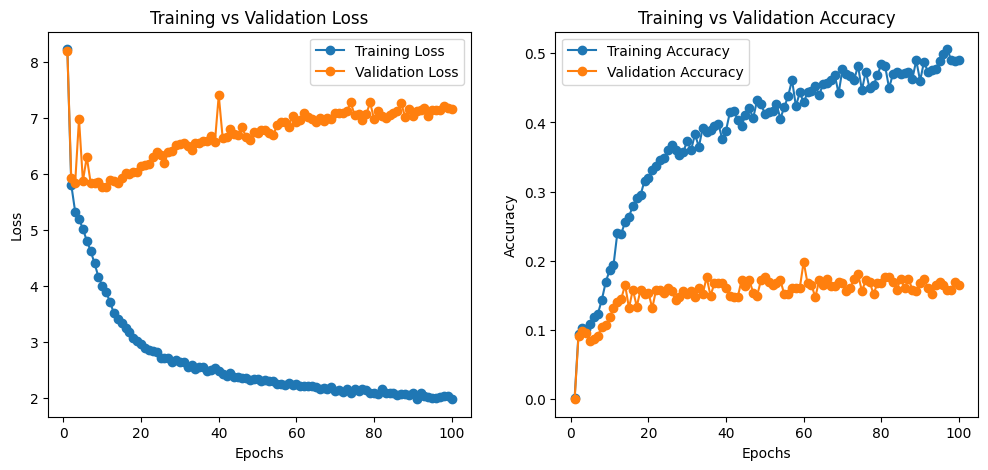

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Set the number of epochs and batch size
epochs = 100
batch_size = 64

# Calculate steps per epoch
steps_per_epoch = ceil(len(train) / batch_size)
validation_steps = ceil(len(test) / batch_size)

# Initialize lists to store loss and accuracy values
train_loss = []
val_loss = []
train_accuracy = []
val_accuracy = []

# Placeholder for true and predicted labels for confusion matrix
y_true = []
y_pred = []

# Loop through epochs for training
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    
    # Set up data generators
    train_generator = data_generator(train, image_to_captions_mapping, loaded_features, tokenizer, max_caption_length, vocab_size, batch_size)
    test_generator = data_generator(test, image_to_captions_mapping, loaded_features, tokenizer, max_caption_length, vocab_size, batch_size)
    
    # Train the model for one epoch
    history = model.fit(
        train_generator,
        epochs=10,
        steps_per_epoch=steps_per_epoch,
        validation_data=test_generator,
        validation_steps=validation_steps,
        verbose=1
    )
    
    # Print available metrics
    print("Available metrics:", history.history.keys())

    # Store loss values
    train_loss.append(history.history['loss'][0])
    val_loss.append(history.history['val_loss'][0])

    # Check if accuracy metric exists
    if 'accuracy' in history.history:
        train_accuracy.append(history.history['accuracy'][0])
        val_accuracy.append(history.history['val_accuracy'][0])
    elif 'acc' in history.history:  # Older TensorFlow versions
        train_accuracy.append(history.history['acc'][0])
        val_accuracy.append(history.history['val_acc'][0])
    else:
        print("Accuracy metric not found. Skipping accuracy tracking.")

# Ensure lists are not empty before plotting
if train_accuracy and val_accuracy:
    plt.figure(figsize=(12, 5))

    # Plot training vs validation loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), train_loss, label='Training Loss', marker='o')
    plt.plot(range(1, epochs+1), val_loss, label='Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()

    # Plot training vs validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), train_accuracy, label='Training Accuracy', marker='o')
    plt.plot(range(1, epochs+1), val_accuracy, label='Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()

    plt.show()
else:
    print("Skipping accuracy plots since accuracy data is missing.")




In [47]:
'''
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Generate predictions for the heatmap
y_true, y_pred = [], []
for x_batch, y_batch in test_generator:
    preds = model.predict(x_batch)
    y_true.extend(np.argmax(y_batch, axis=1))  # Convert one-hot labels to class index
    y_pred.extend(np.argmax(preds, axis=1))    # Convert predictions to class index

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(len(cm)), yticklabels=range(len(cm)))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()
'''

"\nimport matplotlib.pyplot as plt\nimport seaborn as sns\nimport numpy as np\nfrom sklearn.metrics import confusion_matrix\n\n# Generate predictions for the heatmap\ny_true, y_pred = [], []\nfor x_batch, y_batch in test_generator:\n    preds = model.predict(x_batch)\n    y_true.extend(np.argmax(y_batch, axis=1))  # Convert one-hot labels to class index\n    y_pred.extend(np.argmax(preds, axis=1))    # Convert predictions to class index\n\n# Compute confusion matrix\ncm = confusion_matrix(y_true, y_pred)\n\n# Plot heatmap\nplt.figure(figsize=(8, 6))\nsns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(len(cm)), yticklabels=range(len(cm)))\nplt.xlabel('Predicted Labels')\nplt.ylabel('True Labels')\nplt.title('Confusion Matrix Heatmap')\nplt.show()\n"

In [48]:
# Save the model
model.save(OUTPUT_DIR+'/mymodel.h5')

In [49]:
def get_word_from_index(index, tokenizer):
    return next((word for word, idx in tokenizer.word_index.items() if idx == index), None)

In [50]:
def predict_caption(model, image_features, tokenizer, max_caption_length):
    # Initialize the caption sequence
    caption = 'startseq'
    
    # Generate the caption
    for _ in range(max_caption_length):
        # Convert the current caption to a sequence of token indices
        sequence = tokenizer.texts_to_sequences([caption])[0]
        # Pad the sequence to match the maximum caption length
        sequence = pad_sequences([sequence], maxlen=max_caption_length)
        # Predict the next word's probability distribution
        yhat = model.predict([image_features, sequence], verbose=0)
        # Get the index with the highest probability
        predicted_index = np.argmax(yhat)
        # Convert the index to a word
        predicted_word = get_word_from_index(predicted_index, tokenizer)
        
        # Append the predicted word to the caption
        caption += " " + predicted_word
        
        # Stop if the word is None or if the end sequence tag is encountered
        if predicted_word is None or predicted_word == 'endseq':
            break
    
    return caption

# Ensure image_features is a single tensor
if isinstance(image_features, list):
    image_features = np.array(image_features).mean(axis=0, keepdims=True)

# Now call prediction
caption = predict_caption(model, image_features, tokenizer, max_caption_length)
clean_caption = caption.replace('startseq', '').replace(' endseq', '').strip()
print("Generated Caption:", clean_caption)

ValueError: in user code:

    File "/home/deb/anaconda3/envs/Tensorflow/lib/python3.10/site-packages/keras/engine/training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "/home/deb/anaconda3/envs/Tensorflow/lib/python3.10/site-packages/keras/engine/training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/deb/anaconda3/envs/Tensorflow/lib/python3.10/site-packages/keras/engine/training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "/home/deb/anaconda3/envs/Tensorflow/lib/python3.10/site-packages/keras/engine/training.py", line 2111, in predict_step
        return self(x, training=False)
    File "/home/deb/anaconda3/envs/Tensorflow/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/deb/anaconda3/envs/Tensorflow/lib/python3.10/site-packages/keras/engine/input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model_4" expects 2 input(s), but it received 8092 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:9' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:10' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:11' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:12' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:13' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:14' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:15' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:16' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:17' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:18' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:19' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:20' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:21' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:22' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:23' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:24' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:25' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:26' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:27' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:28' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:29' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:30' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:31' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:32' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:33' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:34' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:35' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:36' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:37' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:38' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:39' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:40' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:41' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:42' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:43' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:44' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:45' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:46' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:47' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:48' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:49' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:50' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:51' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:52' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:53' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:54' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:55' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:56' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:57' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:58' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:59' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:60' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:61' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:62' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:63' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:64' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:65' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:66' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:67' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:68' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:69' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:70' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:71' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:72' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:73' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:74' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:75' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:76' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:77' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:78' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:79' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:80' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:81' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:82' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:83' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:84' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:85' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:86' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:87' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:88' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:89' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:90' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:91' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:92' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:93' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:94' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:95' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:96' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:97' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:98' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:99' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:100' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:101' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:102' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:103' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:104' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:105' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:106' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:107' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:108' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:109' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:110' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:111' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:112' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:113' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:114' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:115' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:116' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:117' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:118' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:119' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:120' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:121' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:122' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:123' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:124' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:125' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:126' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:127' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:128' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:129' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:130' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:131' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:132' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:133' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:134' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:135' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:136' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:137' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:138' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:139' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:140' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:141' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:142' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:143' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:144' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:145' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:146' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:147' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:148' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:149' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:150' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:151' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:152' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:153' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:154' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:155' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:156' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:157' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:158' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:159' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:160' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:161' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:162' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:163' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:164' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:165' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:166' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:167' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:168' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:169' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:170' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:171' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:172' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:173' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:174' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:175' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:176' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:177' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:178' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:179' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:180' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:181' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:182' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:183' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:184' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:185' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:186' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:187' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:188' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:189' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:190' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:191' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:192' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:193' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:194' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:195' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:196' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:197' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:198' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:199' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:200' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:201' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:202' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:203' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:204' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:205' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:206' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:207' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:208' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:209' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:210' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:211' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:212' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:213' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:214' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:215' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:216' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:217' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:218' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:219' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:220' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:221' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:222' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:223' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:224' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:225' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:226' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:227' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:228' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:229' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:230' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:231' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:232' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:233' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:234' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:235' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:236' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:237' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:238' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:239' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:240' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:241' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:242' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:243' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:244' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:245' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:246' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:247' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:248' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:249' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:250' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:251' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:252' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:253' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:254' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:255' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:256' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:257' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:258' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:259' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:260' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:261' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:262' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:263' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:264' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:265' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:266' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:267' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:268' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:269' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:270' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:271' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:272' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:273' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:274' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:275' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:276' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:277' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:278' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:279' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:280' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:281' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:282' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:283' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:284' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:285' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:286' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:287' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:288' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:289' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:290' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:291' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:292' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:293' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:294' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:295' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:296' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:297' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:298' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:299' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:300' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:301' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:302' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:303' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:304' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:305' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:306' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:307' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:308' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:309' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:310' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:311' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:312' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:313' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:314' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:315' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:316' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:317' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:318' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:319' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:320' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:321' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:322' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:323' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:324' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:325' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:326' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:327' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:328' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:329' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:330' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:331' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:332' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:333' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:334' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:335' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:336' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:337' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:338' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:339' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:340' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:341' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:342' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:343' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:344' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:345' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:346' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:347' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:348' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:349' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:350' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:351' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:352' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:353' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:354' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:355' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:356' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:357' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:358' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:359' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:360' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:361' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:362' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:363' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:364' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:365' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:366' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:367' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:368' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:369' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:370' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:371' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:372' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:373' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:374' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:375' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:376' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:377' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:378' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:379' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:380' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:381' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:382' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:383' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:384' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:385' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:386' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:387' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:388' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:389' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:390' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:391' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:392' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:393' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:394' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:395' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:396' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:397' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:398' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:399' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:400' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:401' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:402' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:403' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:404' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:405' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:406' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:407' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:408' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:409' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:410' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:411' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:412' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:413' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:414' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:415' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:416' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:417' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:418' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:419' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:420' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:421' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:422' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:423' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:424' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:425' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:426' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:427' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:428' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:429' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:430' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:431' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:432' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:433' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:434' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:435' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:436' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:437' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:438' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:439' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:440' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:441' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:442' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:443' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:444' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:445' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:446' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:447' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:448' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:449' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:450' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:451' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:452' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:453' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:454' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:455' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:456' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:457' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:458' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:459' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:460' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:461' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:462' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:463' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:464' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:465' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:466' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:467' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:468' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:469' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:470' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:471' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:472' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:473' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:474' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:475' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:476' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:477' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:478' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:479' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:480' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:481' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:482' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:483' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:484' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:485' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:486' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:487' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:488' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:489' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:490' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:491' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:492' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:493' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:494' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:495' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:496' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:497' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:498' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:499' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:500' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:501' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:502' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:503' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:504' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:505' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:506' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:507' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:508' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:509' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:510' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:511' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:512' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:513' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:514' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:515' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:516' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:517' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:518' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:519' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:520' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:521' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:522' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:523' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:524' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:525' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:526' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:527' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:528' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:529' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:530' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:531' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:532' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:533' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:534' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:535' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:536' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:537' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:538' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:539' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:540' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:541' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:542' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:543' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:544' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:545' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:546' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:547' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:548' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:549' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:550' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:551' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:552' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:553' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:554' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:555' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:556' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:557' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:558' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:559' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:560' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:561' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:562' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:563' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:564' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:565' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:566' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:567' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:568' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:569' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:570' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:571' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:572' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:573' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:574' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:575' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:576' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:577' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:578' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:579' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:580' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:581' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:582' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:583' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:584' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:585' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:586' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:587' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:588' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:589' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:590' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:591' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:592' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:593' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:594' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:595' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:596' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:597' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:598' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:599' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:600' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:601' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:602' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:603' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:604' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:605' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:606' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:607' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:608' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:609' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:610' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:611' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:612' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:613' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:614' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:615' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:616' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:617' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:618' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:619' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:620' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:621' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:622' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:623' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:624' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:625' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:626' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:627' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:628' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:629' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:630' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:631' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:632' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:633' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:634' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:635' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:636' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:637' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:638' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:639' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:640' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:641' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:642' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:643' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:644' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:645' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:646' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:647' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:648' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:649' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:650' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:651' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:652' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:653' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:654' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:655' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:656' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:657' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:658' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:659' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:660' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:661' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:662' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:663' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:664' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:665' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:666' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:667' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:668' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:669' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:670' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:671' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:672' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:673' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:674' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:675' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:676' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:677' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:678' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:679' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:680' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:681' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:682' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:683' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:684' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:685' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:686' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:687' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:688' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:689' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:690' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:691' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:692' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:693' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:694' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:695' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:696' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:697' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:698' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:699' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:700' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:701' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:702' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:703' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:704' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:705' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:706' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:707' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:708' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:709' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:710' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:711' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:712' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:713' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:714' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:715' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:716' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:717' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:718' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:719' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:720' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:721' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:722' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:723' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:724' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:725' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:726' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:727' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:728' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:729' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:730' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:731' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:732' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:733' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:734' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:735' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:736' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:737' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:738' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:739' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:740' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:741' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:742' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:743' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:744' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:745' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:746' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:747' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:748' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:749' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:750' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:751' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:752' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:753' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:754' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:755' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:756' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:757' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:758' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:759' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:760' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:761' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:762' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:763' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:764' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:765' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:766' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:767' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:768' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:769' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:770' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:771' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:772' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:773' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:774' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:775' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:776' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:777' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:778' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:779' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:780' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:781' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:782' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:783' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:784' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:785' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:786' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:787' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:788' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:789' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:790' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:791' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:792' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:793' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:794' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:795' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:796' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:797' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:798' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:799' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:800' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:801' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:802' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:803' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:804' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:805' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:806' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:807' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:808' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:809' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:810' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:811' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:812' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:813' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:814' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:815' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:816' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:817' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:818' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:819' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:820' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:821' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:822' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:823' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:824' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:825' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:826' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:827' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:828' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:829' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:830' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:831' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:832' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:833' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:834' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:835' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:836' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:837' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:838' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:839' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:840' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:841' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:842' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:843' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:844' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:845' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:846' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:847' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:848' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:849' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:850' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:851' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:852' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:853' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:854' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:855' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:856' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:857' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:858' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:859' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:860' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:861' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:862' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:863' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:864' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:865' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:866' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:867' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:868' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:869' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:870' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:871' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:872' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:873' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:874' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:875' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:876' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:877' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:878' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:879' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:880' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:881' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:882' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:883' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:884' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:885' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:886' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:887' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:888' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:889' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:890' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:891' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:892' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:893' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:894' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:895' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:896' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:897' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:898' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:899' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:900' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:901' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:902' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:903' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:904' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:905' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:906' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:907' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:908' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:909' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:910' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:911' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:912' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:913' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:914' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:915' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:916' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:917' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:918' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:919' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:920' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:921' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:922' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:923' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:924' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:925' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:926' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:927' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:928' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:929' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:930' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:931' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:932' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:933' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:934' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:935' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:936' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:937' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:938' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:939' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:940' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:941' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:942' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:943' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:944' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:945' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:946' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:947' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:948' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:949' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:950' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:951' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:952' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:953' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:954' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:955' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:956' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:957' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:958' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:959' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:960' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:961' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:962' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:963' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:964' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:965' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:966' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:967' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:968' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:969' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:970' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:971' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:972' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:973' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:974' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:975' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:976' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:977' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:978' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:979' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:980' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:981' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:982' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:983' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:984' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:985' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:986' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:987' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:988' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:989' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:990' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:991' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:992' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:993' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:994' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:995' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:996' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:997' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:998' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:999' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1000' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1001' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1002' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1003' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1004' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1005' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1006' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1007' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1008' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1009' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1010' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1011' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1012' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1013' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1014' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1015' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1016' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1017' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1018' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1019' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1020' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1021' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1022' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1023' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1024' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1025' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1026' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1027' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1028' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1029' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1030' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1031' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1032' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1033' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1034' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1035' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1036' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1037' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1038' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1039' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1040' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1041' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1042' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1043' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1044' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1045' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1046' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1047' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1048' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1049' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1050' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1051' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1052' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1053' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1054' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1055' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1056' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1057' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1058' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1059' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1060' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1061' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1062' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1063' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1064' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1065' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1066' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1067' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1068' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1069' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1070' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1071' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1072' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1073' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1074' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1075' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1076' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1077' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1078' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1079' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1080' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1081' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1082' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1083' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1084' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1085' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1086' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1087' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1088' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1089' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1090' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1091' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1092' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1093' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1094' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1095' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1096' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1097' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1098' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1099' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1100' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1101' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1102' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1103' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1104' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1105' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1106' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1107' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1108' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1109' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1110' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1111' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1112' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1113' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1114' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1115' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1116' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1117' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1118' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1119' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1120' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1121' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1122' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1123' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1124' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1125' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1126' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1127' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1128' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1129' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1130' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1131' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1132' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1133' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1134' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1135' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1136' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1137' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1138' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1139' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1140' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1141' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1142' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1143' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1144' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1145' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1146' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1147' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1148' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1149' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1150' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1151' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1152' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1153' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1154' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1155' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1156' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1157' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1158' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1159' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1160' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1161' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1162' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1163' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1164' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1165' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1166' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1167' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1168' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1169' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1170' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1171' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1172' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1173' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1174' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1175' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1176' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1177' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1178' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1179' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1180' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1181' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1182' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1183' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1184' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1185' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1186' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1187' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1188' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1189' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1190' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1191' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1192' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1193' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1194' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1195' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1196' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1197' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1198' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1199' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1200' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1201' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1202' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1203' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1204' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1205' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1206' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1207' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1208' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1209' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1210' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1211' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1212' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1213' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1214' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1215' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1216' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1217' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1218' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1219' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1220' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1221' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1222' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1223' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1224' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1225' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1226' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1227' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1228' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1229' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1230' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1231' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1232' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1233' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1234' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1235' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1236' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1237' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1238' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1239' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1240' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1241' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1242' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1243' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1244' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1245' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1246' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1247' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1248' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1249' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1250' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1251' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1252' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1253' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1254' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1255' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1256' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1257' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1258' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1259' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1260' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1261' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1262' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1263' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1264' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1265' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1266' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1267' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1268' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1269' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1270' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1271' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1272' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1273' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1274' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1275' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1276' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1277' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1278' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1279' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1280' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1281' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1282' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1283' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1284' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1285' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1286' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1287' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1288' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1289' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1290' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1291' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1292' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1293' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1294' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1295' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1296' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1297' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1298' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1299' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1300' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1301' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1302' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1303' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1304' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1305' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1306' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1307' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1308' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1309' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1310' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1311' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1312' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1313' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1314' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1315' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1316' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1317' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1318' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1319' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1320' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1321' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1322' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1323' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1324' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1325' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1326' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1327' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1328' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1329' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1330' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1331' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1332' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1333' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1334' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1335' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1336' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1337' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1338' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1339' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1340' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1341' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1342' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1343' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1344' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1345' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1346' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1347' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1348' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1349' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1350' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1351' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1352' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1353' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1354' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1355' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1356' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1357' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1358' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1359' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1360' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1361' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1362' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1363' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1364' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1365' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1366' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1367' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1368' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1369' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1370' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1371' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1372' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1373' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1374' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1375' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1376' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1377' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1378' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1379' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1380' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1381' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1382' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1383' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1384' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1385' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1386' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1387' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1388' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1389' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1390' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1391' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1392' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1393' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1394' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1395' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1396' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1397' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1398' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1399' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1400' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1401' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1402' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1403' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1404' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1405' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1406' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1407' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1408' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1409' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1410' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1411' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1412' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1413' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1414' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1415' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1416' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1417' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1418' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1419' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1420' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1421' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1422' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1423' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1424' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1425' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1426' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1427' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1428' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1429' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1430' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1431' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1432' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1433' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1434' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1435' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1436' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1437' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1438' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1439' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1440' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1441' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1442' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1443' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1444' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1445' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1446' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1447' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1448' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1449' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1450' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1451' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1452' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1453' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1454' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1455' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1456' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1457' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1458' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1459' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1460' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1461' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1462' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1463' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1464' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1465' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1466' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1467' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1468' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1469' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1470' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1471' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1472' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1473' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1474' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1475' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1476' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1477' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1478' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1479' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1480' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1481' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1482' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1483' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1484' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1485' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1486' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1487' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1488' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1489' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1490' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1491' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1492' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1493' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1494' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1495' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1496' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1497' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1498' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1499' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1500' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1501' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1502' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1503' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1504' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1505' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1506' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1507' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1508' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1509' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1510' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1511' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1512' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1513' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1514' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1515' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1516' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1517' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1518' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1519' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1520' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1521' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1522' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1523' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1524' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1525' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1526' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1527' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1528' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1529' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1530' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1531' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1532' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1533' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1534' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1535' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1536' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1537' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1538' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1539' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1540' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1541' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1542' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1543' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1544' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1545' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1546' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1547' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1548' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1549' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1550' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1551' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1552' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1553' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1554' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1555' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1556' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1557' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1558' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1559' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1560' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1561' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1562' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1563' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1564' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1565' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1566' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1567' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1568' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1569' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1570' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1571' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1572' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1573' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1574' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1575' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1576' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1577' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1578' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1579' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1580' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1581' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1582' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1583' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1584' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1585' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1586' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1587' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1588' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1589' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1590' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1591' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1592' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1593' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1594' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1595' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1596' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1597' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1598' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1599' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1600' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1601' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1602' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1603' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1604' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1605' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1606' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1607' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1608' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1609' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1610' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1611' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1612' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1613' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1614' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1615' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1616' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1617' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1618' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1619' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1620' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1621' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1622' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1623' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1624' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1625' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1626' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1627' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1628' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1629' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1630' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1631' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1632' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1633' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1634' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1635' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1636' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1637' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1638' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1639' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1640' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1641' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1642' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1643' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1644' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1645' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1646' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1647' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1648' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1649' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1650' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1651' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1652' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1653' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1654' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1655' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1656' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1657' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1658' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1659' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1660' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1661' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1662' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1663' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1664' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1665' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1666' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1667' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1668' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1669' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1670' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1671' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1672' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1673' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1674' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1675' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1676' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1677' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1678' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1679' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1680' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1681' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1682' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1683' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1684' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1685' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1686' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1687' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1688' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1689' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1690' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1691' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1692' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1693' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1694' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1695' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1696' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1697' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1698' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1699' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1700' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1701' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1702' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1703' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1704' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1705' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1706' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1707' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1708' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1709' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1710' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1711' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1712' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1713' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1714' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1715' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1716' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1717' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1718' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1719' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1720' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1721' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1722' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1723' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1724' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1725' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1726' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1727' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1728' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1729' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1730' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1731' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1732' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1733' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1734' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1735' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1736' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1737' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1738' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1739' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1740' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1741' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1742' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1743' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1744' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1745' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1746' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1747' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1748' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1749' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1750' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1751' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1752' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1753' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1754' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1755' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1756' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1757' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1758' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1759' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1760' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1761' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1762' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1763' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1764' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1765' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1766' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1767' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1768' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1769' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1770' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1771' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1772' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1773' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1774' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1775' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1776' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1777' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1778' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1779' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1780' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1781' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1782' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1783' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1784' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1785' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1786' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1787' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1788' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1789' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1790' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1791' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1792' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1793' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1794' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1795' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1796' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1797' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1798' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1799' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1800' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1801' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1802' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1803' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1804' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1805' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1806' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1807' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1808' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1809' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1810' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1811' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1812' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1813' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1814' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1815' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1816' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1817' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1818' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1819' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1820' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1821' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1822' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1823' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1824' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1825' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1826' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1827' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1828' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1829' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1830' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1831' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1832' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1833' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1834' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1835' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1836' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1837' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1838' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1839' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1840' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1841' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1842' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1843' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1844' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1845' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1846' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1847' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1848' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1849' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1850' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1851' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1852' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1853' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1854' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1855' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1856' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1857' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1858' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1859' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1860' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1861' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1862' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1863' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1864' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1865' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1866' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1867' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1868' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1869' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1870' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1871' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1872' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1873' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1874' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1875' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1876' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1877' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1878' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1879' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1880' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1881' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1882' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1883' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1884' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1885' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1886' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1887' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1888' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1889' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1890' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1891' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1892' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1893' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1894' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1895' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1896' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1897' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1898' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1899' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1900' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1901' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1902' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1903' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1904' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1905' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1906' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1907' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1908' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1909' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1910' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1911' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1912' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1913' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1914' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1915' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1916' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1917' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1918' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1919' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1920' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1921' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1922' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1923' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1924' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1925' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1926' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1927' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1928' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1929' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1930' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1931' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1932' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1933' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1934' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1935' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1936' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1937' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1938' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1939' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1940' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1941' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1942' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1943' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1944' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1945' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1946' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1947' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1948' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1949' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1950' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1951' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1952' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1953' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1954' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1955' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1956' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1957' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1958' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1959' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1960' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1961' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1962' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1963' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1964' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1965' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1966' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1967' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1968' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1969' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1970' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1971' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1972' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1973' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1974' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1975' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1976' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1977' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1978' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1979' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1980' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1981' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1982' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1983' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1984' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1985' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1986' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1987' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1988' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1989' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1990' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1991' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1992' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1993' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1994' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1995' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1996' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1997' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1998' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:1999' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2000' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2001' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2002' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2003' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2004' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2005' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2006' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2007' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2008' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2009' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2010' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2011' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2012' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2013' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2014' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2015' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2016' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2017' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2018' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2019' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2020' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2021' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2022' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2023' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2024' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2025' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2026' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2027' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2028' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2029' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2030' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2031' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2032' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2033' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2034' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2035' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2036' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2037' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2038' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2039' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2040' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2041' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2042' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2043' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2044' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2045' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2046' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2047' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2048' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2049' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2050' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2051' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2052' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2053' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2054' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2055' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2056' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2057' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2058' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2059' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2060' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2061' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2062' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2063' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2064' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2065' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2066' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2067' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2068' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2069' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2070' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2071' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2072' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2073' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2074' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2075' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2076' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2077' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2078' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2079' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2080' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2081' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2082' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2083' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2084' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2085' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2086' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2087' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2088' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2089' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2090' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2091' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2092' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2093' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2094' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2095' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2096' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2097' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2098' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2099' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2100' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2101' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2102' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2103' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2104' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2105' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2106' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2107' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2108' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2109' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2110' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2111' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2112' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2113' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2114' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2115' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2116' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2117' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2118' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2119' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2120' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2121' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2122' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2123' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2124' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2125' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2126' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2127' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2128' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2129' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2130' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2131' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2132' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2133' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2134' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2135' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2136' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2137' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2138' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2139' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2140' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2141' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2142' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2143' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2144' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2145' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2146' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2147' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2148' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2149' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2150' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2151' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2152' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2153' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2154' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2155' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2156' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2157' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2158' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2159' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2160' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2161' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2162' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2163' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2164' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2165' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2166' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2167' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2168' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2169' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2170' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2171' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2172' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2173' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2174' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2175' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2176' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2177' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2178' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2179' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2180' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2181' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2182' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2183' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2184' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2185' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2186' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2187' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2188' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2189' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2190' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2191' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2192' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2193' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2194' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2195' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2196' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2197' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2198' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2199' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2200' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2201' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2202' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2203' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2204' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2205' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2206' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2207' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2208' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2209' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2210' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2211' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2212' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2213' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2214' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2215' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2216' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2217' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2218' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2219' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2220' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2221' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2222' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2223' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2224' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2225' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2226' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2227' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2228' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2229' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2230' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2231' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2232' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2233' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2234' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2235' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2236' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2237' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2238' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2239' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2240' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2241' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2242' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2243' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2244' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2245' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2246' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2247' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2248' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2249' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2250' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2251' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2252' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2253' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2254' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2255' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2256' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2257' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2258' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2259' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2260' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2261' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2262' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2263' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2264' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2265' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2266' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2267' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2268' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2269' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2270' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2271' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2272' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2273' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2274' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2275' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2276' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2277' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2278' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2279' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2280' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2281' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2282' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2283' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2284' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2285' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2286' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2287' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2288' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2289' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2290' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2291' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2292' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2293' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2294' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2295' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2296' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2297' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2298' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2299' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2300' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2301' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2302' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2303' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2304' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2305' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2306' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2307' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2308' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2309' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2310' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2311' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2312' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2313' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2314' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2315' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2316' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2317' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2318' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2319' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2320' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2321' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2322' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2323' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2324' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2325' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2326' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2327' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2328' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2329' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2330' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2331' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2332' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2333' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2334' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2335' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2336' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2337' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2338' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2339' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2340' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2341' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2342' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2343' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2344' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2345' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2346' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2347' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2348' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2349' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2350' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2351' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2352' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2353' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2354' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2355' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2356' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2357' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2358' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2359' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2360' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2361' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2362' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2363' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2364' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2365' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2366' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2367' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2368' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2369' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2370' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2371' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2372' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2373' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2374' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2375' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2376' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2377' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2378' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2379' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2380' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2381' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2382' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2383' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2384' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2385' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2386' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2387' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2388' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2389' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2390' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2391' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2392' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2393' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2394' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2395' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2396' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2397' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2398' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2399' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2400' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2401' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2402' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2403' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2404' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2405' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2406' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2407' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2408' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2409' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2410' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2411' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2412' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2413' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2414' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2415' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2416' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2417' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2418' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2419' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2420' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2421' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2422' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2423' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2424' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2425' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2426' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2427' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2428' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2429' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2430' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2431' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2432' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2433' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2434' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2435' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2436' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2437' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2438' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2439' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2440' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2441' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2442' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2443' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2444' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2445' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2446' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2447' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2448' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2449' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2450' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2451' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2452' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2453' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2454' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2455' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2456' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2457' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2458' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2459' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2460' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2461' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2462' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2463' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2464' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2465' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2466' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2467' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2468' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2469' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2470' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2471' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2472' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2473' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2474' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2475' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2476' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2477' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2478' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2479' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2480' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2481' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2482' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2483' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2484' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2485' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2486' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2487' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2488' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2489' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2490' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2491' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2492' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2493' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2494' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2495' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2496' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2497' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2498' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2499' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2500' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2501' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2502' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2503' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2504' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2505' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2506' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2507' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2508' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2509' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2510' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2511' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2512' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2513' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2514' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2515' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2516' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2517' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2518' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2519' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2520' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2521' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2522' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2523' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2524' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2525' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2526' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2527' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2528' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2529' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2530' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2531' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2532' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2533' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2534' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2535' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2536' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2537' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2538' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2539' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2540' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2541' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2542' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2543' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2544' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2545' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2546' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2547' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2548' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2549' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2550' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2551' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2552' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2553' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2554' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2555' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2556' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2557' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2558' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2559' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2560' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2561' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2562' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2563' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2564' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2565' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2566' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2567' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2568' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2569' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2570' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2571' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2572' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2573' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2574' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2575' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2576' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2577' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2578' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2579' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2580' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2581' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2582' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2583' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2584' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2585' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2586' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2587' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2588' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2589' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2590' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2591' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2592' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2593' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2594' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2595' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2596' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2597' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2598' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2599' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2600' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2601' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2602' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2603' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2604' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2605' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2606' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2607' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2608' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2609' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2610' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2611' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2612' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2613' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2614' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2615' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2616' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2617' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2618' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2619' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2620' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2621' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2622' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2623' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2624' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2625' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2626' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2627' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2628' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2629' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2630' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2631' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2632' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2633' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2634' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2635' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2636' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2637' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2638' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2639' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2640' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2641' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2642' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2643' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2644' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2645' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2646' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2647' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2648' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2649' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2650' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2651' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2652' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2653' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2654' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2655' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2656' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2657' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2658' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2659' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2660' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2661' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2662' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2663' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2664' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2665' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2666' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2667' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2668' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2669' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2670' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2671' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2672' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2673' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2674' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2675' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2676' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2677' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2678' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2679' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2680' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2681' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2682' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2683' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2684' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2685' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2686' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2687' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2688' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2689' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2690' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2691' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2692' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2693' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2694' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2695' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2696' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2697' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2698' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2699' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2700' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2701' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2702' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2703' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2704' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2705' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2706' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2707' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2708' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2709' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2710' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2711' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2712' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2713' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2714' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2715' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2716' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2717' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2718' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2719' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2720' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2721' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2722' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2723' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2724' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2725' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2726' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2727' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2728' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2729' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2730' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2731' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2732' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2733' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2734' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2735' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2736' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2737' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2738' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2739' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2740' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2741' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2742' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2743' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2744' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2745' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2746' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2747' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2748' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2749' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2750' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2751' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2752' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2753' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2754' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2755' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2756' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2757' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2758' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2759' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2760' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2761' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2762' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2763' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2764' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2765' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2766' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2767' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2768' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2769' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2770' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2771' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2772' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2773' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2774' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2775' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2776' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2777' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2778' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2779' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2780' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2781' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2782' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2783' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2784' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2785' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2786' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2787' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2788' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2789' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2790' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2791' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2792' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2793' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2794' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2795' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2796' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2797' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2798' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2799' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2800' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2801' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2802' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2803' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2804' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2805' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2806' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2807' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2808' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2809' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2810' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2811' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2812' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2813' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2814' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2815' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2816' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2817' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2818' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2819' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2820' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2821' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2822' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2823' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2824' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2825' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2826' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2827' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2828' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2829' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2830' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2831' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2832' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2833' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2834' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2835' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2836' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2837' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2838' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2839' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2840' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2841' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2842' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2843' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2844' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2845' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2846' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2847' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2848' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2849' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2850' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2851' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2852' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2853' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2854' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2855' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2856' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2857' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2858' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2859' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2860' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2861' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2862' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2863' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2864' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2865' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2866' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2867' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2868' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2869' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2870' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2871' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2872' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2873' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2874' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2875' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2876' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2877' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2878' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2879' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2880' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2881' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2882' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2883' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2884' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2885' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2886' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2887' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2888' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2889' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2890' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2891' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2892' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2893' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2894' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2895' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2896' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2897' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2898' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2899' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2900' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2901' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2902' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2903' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2904' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2905' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2906' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2907' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2908' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2909' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2910' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2911' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2912' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2913' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2914' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2915' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2916' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2917' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2918' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2919' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2920' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2921' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2922' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2923' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2924' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2925' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2926' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2927' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2928' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2929' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2930' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2931' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2932' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2933' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2934' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2935' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2936' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2937' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2938' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2939' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2940' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2941' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2942' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2943' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2944' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2945' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2946' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2947' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2948' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2949' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2950' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2951' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2952' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2953' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2954' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2955' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2956' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2957' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2958' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2959' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2960' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2961' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2962' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2963' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2964' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2965' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2966' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2967' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2968' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2969' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2970' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2971' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2972' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2973' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2974' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2975' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2976' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2977' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2978' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2979' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2980' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2981' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2982' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2983' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2984' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2985' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2986' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2987' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2988' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2989' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2990' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2991' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2992' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2993' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2994' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2995' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2996' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2997' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2998' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:2999' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3000' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3001' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3002' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3003' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3004' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3005' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3006' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3007' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3008' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3009' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3010' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3011' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3012' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3013' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3014' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3015' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3016' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3017' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3018' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3019' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3020' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3021' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3022' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3023' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3024' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3025' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3026' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3027' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3028' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3029' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3030' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3031' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3032' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3033' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3034' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3035' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3036' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3037' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3038' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3039' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3040' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3041' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3042' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3043' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3044' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3045' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3046' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3047' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3048' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3049' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3050' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3051' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3052' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3053' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3054' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3055' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3056' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3057' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3058' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3059' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3060' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3061' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3062' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3063' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3064' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3065' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3066' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3067' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3068' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3069' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3070' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3071' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3072' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3073' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3074' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3075' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3076' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3077' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3078' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3079' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3080' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3081' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3082' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3083' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3084' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3085' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3086' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3087' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3088' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3089' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3090' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3091' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3092' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3093' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3094' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3095' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3096' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3097' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3098' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3099' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3100' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3101' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3102' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3103' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3104' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3105' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3106' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3107' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3108' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3109' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3110' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3111' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3112' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3113' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3114' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3115' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3116' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3117' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3118' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3119' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3120' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3121' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3122' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3123' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3124' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3125' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3126' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3127' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3128' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3129' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3130' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3131' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3132' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3133' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3134' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3135' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3136' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3137' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3138' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3139' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3140' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3141' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3142' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3143' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3144' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3145' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3146' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3147' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3148' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3149' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3150' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3151' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3152' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3153' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3154' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3155' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3156' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3157' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3158' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3159' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3160' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3161' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3162' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3163' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3164' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3165' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3166' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3167' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3168' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3169' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3170' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3171' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3172' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3173' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3174' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3175' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3176' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3177' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3178' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3179' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3180' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3181' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3182' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3183' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3184' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3185' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3186' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3187' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3188' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3189' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3190' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3191' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3192' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3193' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3194' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3195' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3196' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3197' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3198' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3199' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3200' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3201' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3202' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3203' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3204' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3205' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3206' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3207' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3208' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3209' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3210' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3211' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3212' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3213' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3214' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3215' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3216' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3217' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3218' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3219' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3220' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3221' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3222' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3223' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3224' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3225' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3226' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3227' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3228' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3229' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3230' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3231' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3232' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3233' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3234' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3235' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3236' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3237' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3238' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3239' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3240' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3241' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3242' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3243' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3244' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3245' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3246' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3247' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3248' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3249' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3250' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3251' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3252' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3253' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3254' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3255' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3256' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3257' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3258' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3259' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3260' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3261' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3262' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3263' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3264' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3265' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3266' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3267' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3268' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3269' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3270' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3271' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3272' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3273' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3274' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3275' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3276' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3277' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3278' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3279' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3280' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3281' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3282' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3283' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3284' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3285' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3286' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3287' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3288' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3289' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3290' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3291' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3292' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3293' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3294' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3295' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3296' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3297' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3298' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3299' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3300' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3301' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3302' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3303' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3304' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3305' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3306' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3307' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3308' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3309' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3310' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3311' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3312' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3313' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3314' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3315' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3316' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3317' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3318' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3319' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3320' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3321' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3322' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3323' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3324' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3325' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3326' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3327' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3328' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3329' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3330' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3331' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3332' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3333' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3334' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3335' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3336' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3337' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3338' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3339' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3340' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3341' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3342' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3343' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3344' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3345' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3346' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3347' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3348' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3349' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3350' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3351' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3352' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3353' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3354' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3355' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3356' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3357' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3358' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3359' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3360' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3361' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3362' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3363' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3364' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3365' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3366' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3367' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3368' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3369' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3370' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3371' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3372' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3373' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3374' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3375' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3376' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3377' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3378' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3379' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3380' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3381' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3382' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3383' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3384' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3385' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3386' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3387' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3388' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3389' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3390' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3391' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3392' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3393' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3394' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3395' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3396' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3397' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3398' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3399' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3400' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3401' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3402' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3403' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3404' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3405' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3406' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3407' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3408' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3409' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3410' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3411' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3412' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3413' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3414' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3415' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3416' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3417' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3418' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3419' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3420' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3421' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3422' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3423' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3424' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3425' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3426' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3427' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3428' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3429' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3430' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3431' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3432' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3433' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3434' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3435' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3436' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3437' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3438' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3439' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3440' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3441' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3442' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3443' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3444' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3445' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3446' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3447' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3448' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3449' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3450' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3451' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3452' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3453' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3454' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3455' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3456' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3457' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3458' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3459' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3460' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3461' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3462' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3463' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3464' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3465' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3466' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3467' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3468' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3469' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3470' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3471' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3472' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3473' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3474' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3475' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3476' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3477' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3478' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3479' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3480' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3481' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3482' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3483' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3484' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3485' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3486' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3487' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3488' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3489' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3490' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3491' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3492' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3493' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3494' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3495' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3496' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3497' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3498' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3499' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3500' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3501' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3502' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3503' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3504' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3505' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3506' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3507' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3508' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3509' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3510' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3511' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3512' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3513' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3514' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3515' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3516' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3517' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3518' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3519' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3520' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3521' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3522' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3523' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3524' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3525' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3526' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3527' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3528' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3529' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3530' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3531' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3532' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3533' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3534' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3535' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3536' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3537' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3538' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3539' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3540' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3541' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3542' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3543' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3544' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3545' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3546' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3547' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3548' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3549' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3550' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3551' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3552' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3553' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3554' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3555' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3556' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3557' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3558' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3559' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3560' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3561' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3562' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3563' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3564' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3565' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3566' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3567' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3568' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3569' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3570' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3571' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3572' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3573' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3574' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3575' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3576' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3577' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3578' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3579' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3580' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3581' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3582' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3583' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3584' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3585' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3586' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3587' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3588' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3589' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3590' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3591' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3592' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3593' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3594' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3595' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3596' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3597' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3598' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3599' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3600' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3601' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3602' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3603' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3604' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3605' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3606' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3607' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3608' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3609' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3610' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3611' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3612' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3613' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3614' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3615' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3616' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3617' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3618' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3619' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3620' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3621' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3622' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3623' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3624' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3625' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3626' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3627' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3628' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3629' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3630' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3631' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3632' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3633' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3634' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3635' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3636' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3637' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3638' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3639' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3640' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3641' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3642' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3643' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3644' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3645' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3646' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3647' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3648' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3649' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3650' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3651' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3652' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3653' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3654' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3655' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3656' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3657' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3658' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3659' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3660' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3661' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3662' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3663' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3664' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3665' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3666' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3667' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3668' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3669' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3670' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3671' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3672' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3673' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3674' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3675' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3676' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3677' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3678' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3679' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3680' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3681' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3682' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3683' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3684' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3685' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3686' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3687' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3688' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3689' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3690' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3691' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3692' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3693' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3694' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3695' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3696' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3697' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3698' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3699' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3700' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3701' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3702' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3703' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3704' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3705' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3706' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3707' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3708' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3709' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3710' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3711' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3712' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3713' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3714' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3715' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3716' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3717' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3718' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3719' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3720' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3721' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3722' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3723' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3724' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3725' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3726' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3727' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3728' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3729' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3730' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3731' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3732' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3733' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3734' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3735' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3736' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3737' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3738' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3739' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3740' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3741' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3742' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3743' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3744' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3745' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3746' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3747' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3748' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3749' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3750' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3751' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3752' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3753' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3754' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3755' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3756' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3757' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3758' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3759' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3760' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3761' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3762' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3763' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3764' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3765' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3766' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3767' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3768' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3769' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3770' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3771' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3772' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3773' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3774' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3775' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3776' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3777' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3778' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3779' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3780' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3781' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3782' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3783' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3784' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3785' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3786' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3787' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3788' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3789' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3790' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3791' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3792' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3793' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3794' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3795' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3796' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3797' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3798' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3799' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3800' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3801' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3802' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3803' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3804' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3805' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3806' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3807' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3808' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3809' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3810' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3811' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3812' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3813' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3814' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3815' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3816' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3817' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3818' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3819' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3820' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3821' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3822' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3823' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3824' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3825' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3826' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3827' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3828' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3829' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3830' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3831' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3832' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3833' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3834' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3835' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3836' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3837' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3838' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3839' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3840' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3841' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3842' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3843' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3844' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3845' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3846' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3847' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3848' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3849' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3850' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3851' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3852' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3853' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3854' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3855' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3856' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3857' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3858' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3859' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3860' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3861' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3862' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3863' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3864' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3865' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3866' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3867' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3868' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3869' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3870' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3871' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3872' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3873' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3874' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3875' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3876' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3877' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3878' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3879' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3880' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3881' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3882' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3883' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3884' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3885' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3886' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3887' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3888' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3889' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3890' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3891' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3892' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3893' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3894' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3895' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3896' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3897' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3898' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3899' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3900' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3901' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3902' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3903' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3904' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3905' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3906' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3907' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3908' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3909' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3910' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3911' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3912' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3913' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3914' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3915' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3916' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3917' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3918' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3919' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3920' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3921' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3922' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3923' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3924' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3925' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3926' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3927' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3928' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3929' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3930' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3931' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3932' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3933' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3934' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3935' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3936' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3937' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3938' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3939' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3940' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3941' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3942' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3943' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3944' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3945' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3946' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3947' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3948' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3949' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3950' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3951' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3952' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3953' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3954' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3955' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3956' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3957' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3958' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3959' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3960' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3961' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3962' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3963' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3964' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3965' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3966' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3967' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3968' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3969' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3970' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3971' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3972' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3973' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3974' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3975' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3976' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3977' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3978' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3979' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3980' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3981' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3982' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3983' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3984' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3985' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3986' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3987' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3988' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3989' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3990' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3991' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3992' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3993' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3994' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3995' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3996' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3997' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3998' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:3999' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4000' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4001' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4002' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4003' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4004' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4005' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4006' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4007' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4008' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4009' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4010' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4011' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4012' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4013' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4014' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4015' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4016' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4017' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4018' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4019' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4020' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4021' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4022' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4023' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4024' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4025' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4026' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4027' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4028' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4029' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4030' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4031' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4032' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4033' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4034' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4035' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4036' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4037' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4038' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4039' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4040' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4041' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4042' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4043' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4044' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4045' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4046' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4047' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4048' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4049' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4050' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4051' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4052' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4053' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4054' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4055' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4056' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4057' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4058' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4059' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4060' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4061' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4062' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4063' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4064' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4065' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4066' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4067' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4068' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4069' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4070' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4071' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4072' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4073' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4074' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4075' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4076' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4077' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4078' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4079' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4080' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4081' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4082' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4083' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4084' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4085' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4086' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4087' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4088' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4089' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4090' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4091' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4092' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4093' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4094' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4095' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4096' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4097' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4098' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4099' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4100' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4101' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4102' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4103' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4104' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4105' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4106' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4107' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4108' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4109' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4110' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4111' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4112' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4113' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4114' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4115' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4116' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4117' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4118' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4119' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4120' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4121' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4122' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4123' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4124' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4125' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4126' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4127' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4128' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4129' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4130' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4131' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4132' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4133' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4134' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4135' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4136' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4137' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4138' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4139' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4140' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4141' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4142' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4143' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4144' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4145' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4146' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4147' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4148' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4149' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4150' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4151' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4152' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4153' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4154' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4155' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4156' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4157' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4158' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4159' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4160' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4161' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4162' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4163' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4164' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4165' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4166' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4167' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4168' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4169' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4170' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4171' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4172' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4173' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4174' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4175' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4176' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4177' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4178' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4179' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4180' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4181' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4182' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4183' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4184' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4185' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4186' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4187' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4188' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4189' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4190' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4191' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4192' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4193' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4194' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4195' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4196' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4197' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4198' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4199' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4200' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4201' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4202' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4203' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4204' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4205' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4206' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4207' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4208' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4209' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4210' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4211' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4212' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4213' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4214' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4215' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4216' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4217' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4218' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4219' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4220' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4221' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4222' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4223' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4224' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4225' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4226' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4227' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4228' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4229' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4230' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4231' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4232' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4233' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4234' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4235' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4236' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4237' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4238' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4239' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4240' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4241' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4242' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4243' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4244' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4245' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4246' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4247' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4248' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4249' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4250' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4251' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4252' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4253' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4254' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4255' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4256' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4257' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4258' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4259' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4260' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4261' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4262' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4263' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4264' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4265' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4266' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4267' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4268' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4269' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4270' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4271' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4272' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4273' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4274' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4275' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4276' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4277' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4278' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4279' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4280' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4281' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4282' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4283' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4284' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4285' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4286' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4287' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4288' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4289' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4290' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4291' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4292' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4293' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4294' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4295' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4296' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4297' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4298' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4299' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4300' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4301' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4302' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4303' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4304' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4305' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4306' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4307' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4308' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4309' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4310' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4311' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4312' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4313' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4314' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4315' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4316' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4317' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4318' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4319' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4320' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4321' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4322' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4323' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4324' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4325' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4326' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4327' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4328' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4329' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4330' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4331' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4332' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4333' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4334' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4335' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4336' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4337' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4338' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4339' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4340' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4341' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4342' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4343' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4344' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4345' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4346' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4347' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4348' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4349' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4350' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4351' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4352' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4353' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4354' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4355' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4356' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4357' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4358' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4359' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4360' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4361' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4362' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4363' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4364' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4365' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4366' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4367' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4368' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4369' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4370' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4371' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4372' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4373' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4374' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4375' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4376' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4377' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4378' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4379' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4380' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4381' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4382' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4383' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4384' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4385' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4386' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4387' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4388' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4389' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4390' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4391' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4392' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4393' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4394' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4395' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4396' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4397' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4398' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4399' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4400' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4401' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4402' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4403' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4404' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4405' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4406' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4407' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4408' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4409' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4410' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4411' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4412' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4413' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4414' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4415' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4416' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4417' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4418' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4419' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4420' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4421' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4422' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4423' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4424' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4425' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4426' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4427' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4428' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4429' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4430' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4431' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4432' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4433' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4434' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4435' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4436' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4437' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4438' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4439' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4440' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4441' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4442' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4443' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4444' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4445' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4446' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4447' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4448' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4449' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4450' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4451' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4452' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4453' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4454' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4455' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4456' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4457' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4458' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4459' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4460' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4461' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4462' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4463' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4464' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4465' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4466' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4467' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4468' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4469' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4470' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4471' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4472' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4473' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4474' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4475' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4476' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4477' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4478' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4479' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4480' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4481' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4482' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4483' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4484' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4485' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4486' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4487' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4488' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4489' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4490' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4491' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4492' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4493' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4494' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4495' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4496' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4497' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4498' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4499' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4500' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4501' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4502' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4503' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4504' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4505' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4506' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4507' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4508' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4509' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4510' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4511' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4512' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4513' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4514' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4515' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4516' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4517' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4518' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4519' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4520' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4521' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4522' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4523' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4524' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4525' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4526' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4527' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4528' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4529' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4530' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4531' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4532' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4533' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4534' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4535' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4536' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4537' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4538' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4539' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4540' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4541' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4542' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4543' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4544' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4545' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4546' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4547' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4548' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4549' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4550' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4551' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4552' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4553' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4554' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4555' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4556' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4557' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4558' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4559' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4560' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4561' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4562' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4563' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4564' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4565' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4566' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4567' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4568' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4569' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4570' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4571' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4572' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4573' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4574' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4575' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4576' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4577' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4578' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4579' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4580' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4581' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4582' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4583' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4584' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4585' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4586' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4587' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4588' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4589' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4590' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4591' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4592' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4593' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4594' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4595' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4596' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4597' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4598' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4599' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4600' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4601' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4602' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4603' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4604' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4605' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4606' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4607' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4608' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4609' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4610' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4611' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4612' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4613' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4614' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4615' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4616' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4617' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4618' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4619' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4620' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4621' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4622' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4623' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4624' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4625' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4626' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4627' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4628' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4629' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4630' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4631' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4632' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4633' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4634' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4635' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4636' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4637' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4638' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4639' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4640' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4641' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4642' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4643' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4644' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4645' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4646' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4647' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4648' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4649' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4650' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4651' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4652' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4653' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4654' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4655' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4656' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4657' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4658' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4659' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4660' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4661' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4662' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4663' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4664' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4665' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4666' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4667' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4668' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4669' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4670' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4671' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4672' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4673' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4674' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4675' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4676' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4677' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4678' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4679' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4680' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4681' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4682' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4683' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4684' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4685' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4686' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4687' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4688' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4689' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4690' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4691' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4692' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4693' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4694' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4695' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4696' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4697' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4698' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4699' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4700' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4701' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4702' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4703' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4704' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4705' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4706' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4707' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4708' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4709' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4710' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4711' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4712' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4713' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4714' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4715' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4716' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4717' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4718' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4719' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4720' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4721' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4722' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4723' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4724' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4725' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4726' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4727' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4728' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4729' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4730' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4731' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4732' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4733' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4734' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4735' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4736' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4737' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4738' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4739' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4740' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4741' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4742' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4743' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4744' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4745' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4746' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4747' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4748' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4749' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4750' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4751' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4752' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4753' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4754' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4755' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4756' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4757' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4758' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4759' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4760' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4761' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4762' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4763' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4764' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4765' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4766' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4767' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4768' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4769' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4770' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4771' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4772' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4773' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4774' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4775' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4776' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4777' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4778' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4779' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4780' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4781' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4782' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4783' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4784' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4785' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4786' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4787' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4788' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4789' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4790' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4791' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4792' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4793' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4794' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4795' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4796' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4797' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4798' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4799' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4800' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4801' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4802' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4803' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4804' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4805' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4806' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4807' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4808' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4809' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4810' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4811' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4812' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4813' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4814' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4815' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4816' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4817' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4818' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4819' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4820' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4821' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4822' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4823' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4824' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4825' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4826' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4827' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4828' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4829' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4830' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4831' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4832' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4833' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4834' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4835' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4836' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4837' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4838' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4839' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4840' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4841' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4842' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4843' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4844' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4845' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4846' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4847' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4848' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4849' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4850' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4851' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4852' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4853' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4854' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4855' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4856' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4857' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4858' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4859' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4860' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4861' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4862' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4863' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4864' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4865' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4866' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4867' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4868' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4869' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4870' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4871' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4872' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4873' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4874' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4875' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4876' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4877' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4878' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4879' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4880' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4881' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4882' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4883' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4884' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4885' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4886' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4887' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4888' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4889' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4890' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4891' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4892' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4893' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4894' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4895' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4896' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4897' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4898' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4899' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4900' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4901' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4902' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4903' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4904' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4905' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4906' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4907' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4908' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4909' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4910' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4911' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4912' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4913' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4914' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4915' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4916' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4917' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4918' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4919' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4920' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4921' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4922' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4923' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4924' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4925' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4926' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4927' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4928' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4929' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4930' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4931' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4932' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4933' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4934' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4935' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4936' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4937' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4938' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4939' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4940' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4941' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4942' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4943' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4944' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4945' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4946' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4947' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4948' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4949' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4950' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4951' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4952' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4953' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4954' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4955' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4956' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4957' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4958' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4959' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4960' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4961' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4962' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4963' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4964' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4965' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4966' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4967' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4968' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4969' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4970' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4971' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4972' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4973' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4974' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4975' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4976' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4977' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4978' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4979' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4980' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4981' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4982' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4983' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4984' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4985' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4986' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4987' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4988' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4989' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4990' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4991' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4992' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4993' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4994' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4995' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4996' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4997' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4998' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:4999' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5000' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5001' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5002' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5003' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5004' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5005' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5006' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5007' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5008' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5009' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5010' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5011' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5012' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5013' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5014' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5015' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5016' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5017' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5018' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5019' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5020' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5021' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5022' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5023' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5024' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5025' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5026' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5027' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5028' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5029' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5030' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5031' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5032' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5033' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5034' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5035' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5036' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5037' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5038' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5039' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5040' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5041' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5042' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5043' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5044' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5045' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5046' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5047' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5048' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5049' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5050' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5051' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5052' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5053' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5054' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5055' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5056' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5057' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5058' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5059' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5060' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5061' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5062' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5063' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5064' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5065' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5066' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5067' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5068' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5069' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5070' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5071' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5072' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5073' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5074' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5075' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5076' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5077' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5078' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5079' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5080' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5081' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5082' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5083' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5084' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5085' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5086' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5087' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5088' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5089' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5090' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5091' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5092' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5093' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5094' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5095' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5096' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5097' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5098' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5099' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5100' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5101' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5102' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5103' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5104' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5105' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5106' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5107' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5108' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5109' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5110' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5111' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5112' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5113' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5114' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5115' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5116' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5117' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5118' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5119' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5120' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5121' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5122' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5123' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5124' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5125' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5126' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5127' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5128' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5129' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5130' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5131' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5132' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5133' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5134' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5135' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5136' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5137' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5138' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5139' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5140' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5141' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5142' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5143' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5144' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5145' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5146' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5147' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5148' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5149' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5150' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5151' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5152' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5153' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5154' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5155' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5156' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5157' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5158' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5159' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5160' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5161' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5162' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5163' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5164' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5165' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5166' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5167' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5168' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5169' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5170' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5171' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5172' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5173' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5174' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5175' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5176' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5177' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5178' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5179' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5180' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5181' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5182' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5183' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5184' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5185' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5186' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5187' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5188' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5189' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5190' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5191' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5192' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5193' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5194' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5195' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5196' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5197' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5198' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5199' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5200' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5201' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5202' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5203' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5204' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5205' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5206' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5207' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5208' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5209' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5210' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5211' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5212' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5213' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5214' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5215' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5216' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5217' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5218' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5219' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5220' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5221' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5222' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5223' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5224' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5225' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5226' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5227' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5228' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5229' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5230' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5231' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5232' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5233' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5234' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5235' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5236' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5237' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5238' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5239' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5240' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5241' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5242' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5243' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5244' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5245' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5246' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5247' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5248' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5249' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5250' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5251' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5252' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5253' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5254' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5255' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5256' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5257' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5258' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5259' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5260' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5261' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5262' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5263' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5264' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5265' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5266' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5267' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5268' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5269' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5270' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5271' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5272' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5273' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5274' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5275' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5276' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5277' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5278' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5279' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5280' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5281' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5282' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5283' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5284' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5285' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5286' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5287' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5288' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5289' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5290' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5291' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5292' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5293' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5294' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5295' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5296' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5297' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5298' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5299' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5300' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5301' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5302' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5303' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5304' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5305' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5306' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5307' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5308' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5309' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5310' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5311' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5312' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5313' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5314' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5315' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5316' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5317' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5318' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5319' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5320' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5321' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5322' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5323' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5324' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5325' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5326' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5327' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5328' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5329' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5330' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5331' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5332' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5333' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5334' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5335' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5336' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5337' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5338' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5339' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5340' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5341' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5342' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5343' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5344' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5345' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5346' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5347' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5348' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5349' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5350' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5351' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5352' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5353' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5354' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5355' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5356' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5357' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5358' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5359' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5360' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5361' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5362' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5363' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5364' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5365' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5366' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5367' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5368' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5369' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5370' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5371' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5372' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5373' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5374' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5375' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5376' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5377' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5378' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5379' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5380' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5381' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5382' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5383' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5384' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5385' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5386' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5387' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5388' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5389' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5390' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5391' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5392' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5393' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5394' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5395' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5396' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5397' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5398' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5399' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5400' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5401' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5402' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5403' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5404' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5405' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5406' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5407' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5408' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5409' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5410' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5411' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5412' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5413' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5414' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5415' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5416' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5417' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5418' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5419' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5420' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5421' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5422' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5423' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5424' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5425' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5426' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5427' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5428' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5429' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5430' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5431' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5432' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5433' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5434' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5435' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5436' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5437' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5438' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5439' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5440' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5441' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5442' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5443' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5444' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5445' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5446' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5447' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5448' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5449' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5450' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5451' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5452' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5453' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5454' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5455' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5456' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5457' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5458' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5459' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5460' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5461' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5462' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5463' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5464' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5465' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5466' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5467' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5468' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5469' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5470' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5471' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5472' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5473' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5474' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5475' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5476' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5477' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5478' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5479' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5480' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5481' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5482' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5483' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5484' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5485' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5486' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5487' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5488' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5489' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5490' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5491' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5492' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5493' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5494' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5495' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5496' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5497' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5498' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5499' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5500' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5501' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5502' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5503' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5504' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5505' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5506' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5507' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5508' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5509' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5510' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5511' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5512' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5513' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5514' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5515' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5516' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5517' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5518' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5519' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5520' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5521' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5522' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5523' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5524' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5525' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5526' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5527' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5528' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5529' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5530' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5531' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5532' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5533' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5534' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5535' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5536' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5537' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5538' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5539' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5540' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5541' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5542' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5543' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5544' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5545' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5546' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5547' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5548' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5549' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5550' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5551' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5552' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5553' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5554' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5555' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5556' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5557' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5558' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5559' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5560' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5561' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5562' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5563' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5564' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5565' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5566' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5567' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5568' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5569' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5570' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5571' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5572' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5573' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5574' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5575' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5576' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5577' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5578' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5579' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5580' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5581' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5582' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5583' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5584' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5585' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5586' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5587' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5588' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5589' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5590' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5591' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5592' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5593' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5594' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5595' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5596' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5597' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5598' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5599' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5600' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5601' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5602' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5603' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5604' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5605' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5606' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5607' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5608' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5609' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5610' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5611' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5612' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5613' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5614' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5615' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5616' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5617' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5618' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5619' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5620' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5621' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5622' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5623' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5624' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5625' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5626' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5627' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5628' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5629' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5630' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5631' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5632' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5633' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5634' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5635' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5636' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5637' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5638' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5639' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5640' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5641' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5642' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5643' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5644' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5645' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5646' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5647' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5648' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5649' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5650' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5651' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5652' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5653' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5654' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5655' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5656' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5657' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5658' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5659' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5660' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5661' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5662' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5663' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5664' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5665' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5666' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5667' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5668' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5669' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5670' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5671' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5672' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5673' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5674' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5675' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5676' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5677' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5678' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5679' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5680' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5681' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5682' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5683' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5684' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5685' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5686' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5687' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5688' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5689' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5690' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5691' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5692' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5693' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5694' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5695' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5696' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5697' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5698' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5699' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5700' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5701' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5702' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5703' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5704' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5705' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5706' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5707' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5708' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5709' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5710' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5711' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5712' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5713' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5714' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5715' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5716' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5717' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5718' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5719' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5720' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5721' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5722' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5723' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5724' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5725' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5726' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5727' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5728' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5729' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5730' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5731' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5732' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5733' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5734' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5735' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5736' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5737' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5738' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5739' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5740' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5741' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5742' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5743' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5744' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5745' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5746' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5747' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5748' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5749' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5750' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5751' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5752' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5753' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5754' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5755' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5756' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5757' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5758' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5759' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5760' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5761' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5762' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5763' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5764' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5765' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5766' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5767' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5768' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5769' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5770' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5771' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5772' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5773' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5774' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5775' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5776' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5777' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5778' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5779' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5780' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5781' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5782' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5783' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5784' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5785' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5786' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5787' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5788' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5789' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5790' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5791' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5792' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5793' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5794' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5795' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5796' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5797' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5798' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5799' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5800' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5801' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5802' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5803' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5804' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5805' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5806' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5807' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5808' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5809' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5810' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5811' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5812' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5813' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5814' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5815' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5816' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5817' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5818' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5819' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5820' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5821' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5822' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5823' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5824' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5825' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5826' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5827' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5828' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5829' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5830' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5831' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5832' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5833' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5834' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5835' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5836' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5837' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5838' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5839' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5840' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5841' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5842' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5843' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5844' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5845' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5846' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5847' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5848' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5849' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5850' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5851' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5852' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5853' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5854' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5855' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5856' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5857' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5858' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5859' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5860' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5861' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5862' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5863' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5864' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5865' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5866' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5867' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5868' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5869' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5870' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5871' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5872' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5873' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5874' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5875' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5876' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5877' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5878' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5879' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5880' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5881' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5882' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5883' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5884' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5885' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5886' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5887' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5888' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5889' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5890' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5891' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5892' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5893' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5894' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5895' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5896' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5897' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5898' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5899' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5900' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5901' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5902' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5903' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5904' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5905' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5906' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5907' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5908' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5909' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5910' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5911' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5912' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5913' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5914' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5915' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5916' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5917' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5918' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5919' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5920' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5921' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5922' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5923' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5924' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5925' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5926' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5927' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5928' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5929' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5930' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5931' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5932' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5933' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5934' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5935' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5936' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5937' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5938' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5939' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5940' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5941' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5942' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5943' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5944' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5945' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5946' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5947' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5948' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5949' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5950' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5951' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5952' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5953' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5954' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5955' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5956' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5957' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5958' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5959' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5960' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5961' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5962' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5963' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5964' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5965' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5966' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5967' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5968' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5969' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5970' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5971' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5972' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5973' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5974' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5975' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5976' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5977' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5978' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5979' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5980' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5981' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5982' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5983' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5984' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5985' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5986' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5987' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5988' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5989' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5990' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5991' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5992' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5993' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5994' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5995' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5996' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5997' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5998' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:5999' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6000' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6001' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6002' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6003' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6004' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6005' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6006' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6007' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6008' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6009' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6010' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6011' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6012' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6013' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6014' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6015' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6016' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6017' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6018' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6019' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6020' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6021' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6022' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6023' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6024' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6025' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6026' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6027' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6028' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6029' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6030' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6031' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6032' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6033' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6034' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6035' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6036' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6037' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6038' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6039' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6040' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6041' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6042' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6043' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6044' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6045' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6046' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6047' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6048' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6049' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6050' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6051' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6052' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6053' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6054' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6055' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6056' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6057' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6058' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6059' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6060' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6061' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6062' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6063' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6064' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6065' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6066' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6067' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6068' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6069' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6070' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6071' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6072' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6073' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6074' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6075' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6076' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6077' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6078' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6079' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6080' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6081' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6082' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6083' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6084' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6085' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6086' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6087' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6088' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6089' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6090' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6091' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6092' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6093' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6094' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6095' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6096' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6097' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6098' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6099' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6100' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6101' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6102' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6103' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6104' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6105' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6106' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6107' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6108' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6109' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6110' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6111' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6112' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6113' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6114' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6115' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6116' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6117' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6118' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6119' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6120' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6121' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6122' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6123' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6124' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6125' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6126' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6127' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6128' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6129' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6130' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6131' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6132' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6133' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6134' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6135' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6136' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6137' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6138' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6139' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6140' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6141' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6142' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6143' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6144' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6145' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6146' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6147' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6148' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6149' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6150' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6151' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6152' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6153' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6154' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6155' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6156' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6157' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6158' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6159' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6160' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6161' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6162' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6163' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6164' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6165' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6166' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6167' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6168' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6169' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6170' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6171' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6172' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6173' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6174' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6175' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6176' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6177' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6178' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6179' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6180' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6181' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6182' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6183' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6184' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6185' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6186' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6187' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6188' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6189' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6190' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6191' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6192' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6193' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6194' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6195' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6196' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6197' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6198' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6199' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6200' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6201' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6202' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6203' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6204' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6205' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6206' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6207' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6208' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6209' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6210' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6211' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6212' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6213' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6214' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6215' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6216' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6217' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6218' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6219' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6220' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6221' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6222' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6223' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6224' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6225' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6226' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6227' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6228' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6229' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6230' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6231' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6232' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6233' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6234' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6235' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6236' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6237' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6238' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6239' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6240' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6241' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6242' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6243' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6244' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6245' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6246' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6247' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6248' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6249' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6250' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6251' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6252' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6253' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6254' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6255' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6256' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6257' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6258' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6259' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6260' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6261' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6262' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6263' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6264' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6265' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6266' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6267' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6268' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6269' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6270' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6271' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6272' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6273' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6274' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6275' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6276' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6277' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6278' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6279' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6280' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6281' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6282' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6283' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6284' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6285' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6286' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6287' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6288' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6289' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6290' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6291' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6292' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6293' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6294' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6295' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6296' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6297' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6298' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6299' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6300' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6301' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6302' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6303' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6304' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6305' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6306' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6307' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6308' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6309' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6310' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6311' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6312' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6313' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6314' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6315' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6316' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6317' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6318' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6319' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6320' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6321' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6322' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6323' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6324' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6325' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6326' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6327' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6328' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6329' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6330' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6331' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6332' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6333' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6334' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6335' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6336' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6337' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6338' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6339' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6340' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6341' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6342' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6343' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6344' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6345' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6346' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6347' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6348' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6349' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6350' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6351' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6352' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6353' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6354' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6355' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6356' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6357' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6358' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6359' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6360' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6361' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6362' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6363' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6364' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6365' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6366' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6367' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6368' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6369' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6370' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6371' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6372' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6373' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6374' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6375' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6376' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6377' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6378' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6379' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6380' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6381' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6382' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6383' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6384' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6385' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6386' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6387' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6388' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6389' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6390' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6391' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6392' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6393' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6394' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6395' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6396' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6397' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6398' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6399' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6400' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6401' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6402' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6403' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6404' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6405' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6406' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6407' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6408' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6409' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6410' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6411' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6412' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6413' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6414' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6415' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6416' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6417' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6418' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6419' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6420' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6421' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6422' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6423' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6424' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6425' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6426' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6427' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6428' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6429' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6430' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6431' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6432' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6433' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6434' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6435' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6436' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6437' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6438' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6439' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6440' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6441' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6442' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6443' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6444' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6445' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6446' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6447' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6448' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6449' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6450' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6451' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6452' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6453' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6454' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6455' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6456' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6457' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6458' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6459' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6460' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6461' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6462' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6463' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6464' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6465' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6466' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6467' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6468' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6469' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6470' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6471' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6472' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6473' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6474' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6475' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6476' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6477' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6478' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6479' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6480' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6481' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6482' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6483' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6484' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6485' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6486' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6487' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6488' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6489' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6490' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6491' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6492' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6493' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6494' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6495' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6496' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6497' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6498' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6499' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6500' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6501' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6502' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6503' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6504' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6505' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6506' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6507' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6508' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6509' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6510' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6511' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6512' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6513' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6514' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6515' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6516' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6517' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6518' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6519' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6520' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6521' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6522' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6523' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6524' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6525' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6526' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6527' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6528' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6529' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6530' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6531' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6532' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6533' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6534' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6535' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6536' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6537' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6538' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6539' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6540' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6541' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6542' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6543' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6544' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6545' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6546' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6547' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6548' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6549' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6550' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6551' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6552' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6553' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6554' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6555' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6556' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6557' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6558' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6559' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6560' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6561' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6562' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6563' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6564' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6565' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6566' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6567' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6568' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6569' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6570' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6571' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6572' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6573' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6574' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6575' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6576' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6577' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6578' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6579' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6580' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6581' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6582' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6583' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6584' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6585' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6586' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6587' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6588' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6589' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6590' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6591' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6592' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6593' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6594' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6595' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6596' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6597' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6598' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6599' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6600' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6601' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6602' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6603' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6604' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6605' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6606' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6607' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6608' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6609' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6610' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6611' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6612' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6613' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6614' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6615' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6616' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6617' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6618' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6619' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6620' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6621' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6622' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6623' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6624' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6625' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6626' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6627' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6628' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6629' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6630' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6631' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6632' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6633' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6634' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6635' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6636' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6637' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6638' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6639' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6640' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6641' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6642' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6643' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6644' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6645' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6646' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6647' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6648' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6649' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6650' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6651' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6652' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6653' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6654' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6655' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6656' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6657' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6658' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6659' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6660' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6661' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6662' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6663' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6664' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6665' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6666' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6667' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6668' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6669' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6670' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6671' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6672' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6673' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6674' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6675' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6676' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6677' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6678' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6679' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6680' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6681' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6682' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6683' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6684' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6685' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6686' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6687' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6688' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6689' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6690' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6691' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6692' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6693' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6694' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6695' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6696' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6697' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6698' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6699' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6700' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6701' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6702' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6703' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6704' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6705' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6706' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6707' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6708' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6709' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6710' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6711' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6712' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6713' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6714' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6715' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6716' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6717' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6718' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6719' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6720' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6721' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6722' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6723' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6724' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6725' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6726' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6727' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6728' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6729' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6730' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6731' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6732' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6733' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6734' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6735' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6736' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6737' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6738' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6739' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6740' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6741' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6742' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6743' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6744' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6745' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6746' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6747' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6748' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6749' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6750' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6751' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6752' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6753' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6754' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6755' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6756' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6757' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6758' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6759' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6760' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6761' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6762' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6763' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6764' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6765' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6766' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6767' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6768' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6769' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6770' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6771' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6772' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6773' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6774' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6775' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6776' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6777' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6778' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6779' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6780' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6781' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6782' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6783' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6784' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6785' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6786' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6787' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6788' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6789' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6790' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6791' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6792' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6793' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6794' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6795' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6796' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6797' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6798' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6799' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6800' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6801' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6802' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6803' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6804' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6805' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6806' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6807' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6808' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6809' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6810' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6811' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6812' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6813' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6814' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6815' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6816' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6817' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6818' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6819' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6820' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6821' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6822' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6823' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6824' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6825' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6826' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6827' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6828' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6829' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6830' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6831' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6832' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6833' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6834' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6835' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6836' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6837' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6838' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6839' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6840' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6841' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6842' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6843' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6844' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6845' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6846' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6847' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6848' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6849' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6850' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6851' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6852' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6853' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6854' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6855' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6856' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6857' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6858' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6859' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6860' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6861' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6862' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6863' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6864' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6865' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6866' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6867' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6868' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6869' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6870' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6871' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6872' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6873' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6874' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6875' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6876' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6877' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6878' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6879' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6880' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6881' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6882' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6883' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6884' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6885' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6886' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6887' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6888' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6889' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6890' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6891' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6892' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6893' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6894' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6895' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6896' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6897' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6898' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6899' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6900' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6901' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6902' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6903' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6904' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6905' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6906' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6907' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6908' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6909' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6910' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6911' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6912' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6913' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6914' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6915' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6916' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6917' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6918' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6919' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6920' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6921' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6922' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6923' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6924' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6925' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6926' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6927' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6928' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6929' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6930' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6931' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6932' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6933' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6934' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6935' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6936' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6937' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6938' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6939' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6940' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6941' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6942' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6943' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6944' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6945' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6946' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6947' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6948' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6949' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6950' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6951' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6952' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6953' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6954' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6955' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6956' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6957' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6958' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6959' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6960' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6961' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6962' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6963' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6964' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6965' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6966' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6967' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6968' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6969' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6970' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6971' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6972' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6973' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6974' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6975' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6976' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6977' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6978' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6979' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6980' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6981' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6982' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6983' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6984' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6985' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6986' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6987' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6988' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6989' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6990' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6991' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6992' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6993' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6994' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6995' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6996' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6997' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6998' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:6999' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7000' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7001' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7002' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7003' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7004' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7005' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7006' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7007' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7008' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7009' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7010' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7011' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7012' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7013' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7014' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7015' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7016' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7017' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7018' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7019' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7020' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7021' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7022' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7023' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7024' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7025' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7026' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7027' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7028' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7029' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7030' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7031' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7032' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7033' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7034' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7035' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7036' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7037' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7038' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7039' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7040' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7041' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7042' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7043' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7044' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7045' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7046' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7047' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7048' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7049' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7050' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7051' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7052' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7053' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7054' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7055' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7056' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7057' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7058' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7059' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7060' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7061' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7062' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7063' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7064' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7065' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7066' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7067' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7068' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7069' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7070' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7071' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7072' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7073' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7074' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7075' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7076' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7077' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7078' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7079' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7080' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7081' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7082' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7083' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7084' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7085' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7086' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7087' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7088' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7089' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7090' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7091' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7092' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7093' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7094' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7095' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7096' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7097' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7098' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7099' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7100' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7101' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7102' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7103' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7104' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7105' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7106' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7107' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7108' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7109' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7110' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7111' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7112' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7113' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7114' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7115' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7116' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7117' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7118' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7119' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7120' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7121' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7122' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7123' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7124' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7125' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7126' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7127' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7128' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7129' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7130' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7131' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7132' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7133' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7134' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7135' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7136' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7137' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7138' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7139' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7140' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7141' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7142' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7143' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7144' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7145' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7146' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7147' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7148' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7149' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7150' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7151' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7152' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7153' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7154' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7155' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7156' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7157' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7158' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7159' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7160' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7161' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7162' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7163' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7164' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7165' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7166' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7167' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7168' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7169' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7170' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7171' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7172' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7173' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7174' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7175' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7176' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7177' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7178' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7179' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7180' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7181' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7182' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7183' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7184' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7185' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7186' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7187' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7188' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7189' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7190' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7191' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7192' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7193' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7194' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7195' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7196' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7197' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7198' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7199' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7200' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7201' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7202' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7203' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7204' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7205' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7206' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7207' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7208' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7209' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7210' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7211' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7212' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7213' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7214' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7215' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7216' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7217' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7218' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7219' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7220' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7221' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7222' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7223' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7224' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7225' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7226' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7227' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7228' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7229' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7230' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7231' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7232' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7233' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7234' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7235' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7236' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7237' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7238' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7239' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7240' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7241' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7242' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7243' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7244' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7245' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7246' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7247' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7248' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7249' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7250' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7251' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7252' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7253' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7254' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7255' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7256' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7257' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7258' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7259' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7260' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7261' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7262' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7263' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7264' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7265' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7266' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7267' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7268' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7269' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7270' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7271' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7272' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7273' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7274' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7275' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7276' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7277' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7278' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7279' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7280' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7281' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7282' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7283' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7284' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7285' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7286' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7287' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7288' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7289' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7290' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7291' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7292' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7293' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7294' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7295' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7296' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7297' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7298' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7299' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7300' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7301' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7302' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7303' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7304' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7305' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7306' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7307' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7308' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7309' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7310' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7311' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7312' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7313' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7314' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7315' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7316' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7317' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7318' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7319' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7320' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7321' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7322' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7323' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7324' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7325' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7326' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7327' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7328' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7329' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7330' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7331' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7332' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7333' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7334' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7335' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7336' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7337' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7338' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7339' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7340' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7341' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7342' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7343' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7344' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7345' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7346' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7347' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7348' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7349' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7350' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7351' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7352' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7353' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7354' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7355' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7356' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7357' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7358' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7359' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7360' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7361' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7362' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7363' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7364' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7365' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7366' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7367' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7368' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7369' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7370' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7371' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7372' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7373' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7374' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7375' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7376' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7377' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7378' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7379' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7380' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7381' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7382' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7383' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7384' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7385' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7386' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7387' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7388' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7389' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7390' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7391' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7392' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7393' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7394' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7395' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7396' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7397' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7398' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7399' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7400' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7401' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7402' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7403' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7404' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7405' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7406' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7407' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7408' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7409' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7410' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7411' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7412' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7413' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7414' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7415' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7416' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7417' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7418' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7419' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7420' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7421' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7422' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7423' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7424' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7425' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7426' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7427' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7428' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7429' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7430' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7431' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7432' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7433' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7434' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7435' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7436' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7437' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7438' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7439' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7440' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7441' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7442' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7443' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7444' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7445' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7446' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7447' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7448' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7449' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7450' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7451' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7452' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7453' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7454' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7455' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7456' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7457' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7458' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7459' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7460' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7461' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7462' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7463' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7464' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7465' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7466' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7467' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7468' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7469' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7470' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7471' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7472' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7473' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7474' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7475' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7476' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7477' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7478' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7479' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7480' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7481' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7482' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7483' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7484' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7485' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7486' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7487' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7488' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7489' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7490' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7491' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7492' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7493' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7494' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7495' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7496' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7497' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7498' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7499' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7500' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7501' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7502' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7503' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7504' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7505' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7506' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7507' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7508' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7509' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7510' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7511' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7512' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7513' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7514' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7515' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7516' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7517' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7518' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7519' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7520' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7521' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7522' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7523' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7524' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7525' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7526' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7527' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7528' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7529' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7530' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7531' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7532' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7533' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7534' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7535' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7536' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7537' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7538' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7539' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7540' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7541' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7542' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7543' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7544' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7545' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7546' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7547' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7548' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7549' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7550' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7551' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7552' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7553' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7554' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7555' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7556' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7557' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7558' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7559' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7560' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7561' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7562' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7563' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7564' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7565' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7566' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7567' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7568' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7569' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7570' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7571' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7572' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7573' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7574' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7575' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7576' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7577' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7578' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7579' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7580' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7581' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7582' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7583' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7584' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7585' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7586' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7587' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7588' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7589' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7590' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7591' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7592' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7593' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7594' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7595' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7596' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7597' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7598' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7599' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7600' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7601' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7602' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7603' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7604' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7605' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7606' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7607' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7608' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7609' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7610' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7611' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7612' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7613' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7614' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7615' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7616' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7617' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7618' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7619' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7620' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7621' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7622' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7623' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7624' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7625' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7626' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7627' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7628' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7629' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7630' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7631' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7632' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7633' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7634' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7635' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7636' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7637' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7638' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7639' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7640' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7641' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7642' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7643' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7644' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7645' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7646' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7647' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7648' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7649' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7650' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7651' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7652' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7653' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7654' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7655' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7656' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7657' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7658' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7659' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7660' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7661' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7662' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7663' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7664' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7665' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7666' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7667' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7668' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7669' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7670' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7671' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7672' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7673' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7674' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7675' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7676' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7677' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7678' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7679' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7680' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7681' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7682' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7683' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7684' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7685' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7686' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7687' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7688' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7689' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7690' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7691' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7692' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7693' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7694' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7695' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7696' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7697' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7698' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7699' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7700' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7701' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7702' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7703' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7704' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7705' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7706' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7707' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7708' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7709' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7710' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7711' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7712' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7713' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7714' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7715' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7716' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7717' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7718' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7719' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7720' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7721' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7722' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7723' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7724' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7725' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7726' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7727' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7728' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7729' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7730' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7731' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7732' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7733' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7734' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7735' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7736' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7737' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7738' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7739' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7740' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7741' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7742' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7743' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7744' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7745' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7746' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7747' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7748' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7749' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7750' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7751' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7752' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7753' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7754' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7755' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7756' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7757' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7758' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7759' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7760' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7761' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7762' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7763' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7764' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7765' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7766' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7767' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7768' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7769' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7770' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7771' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7772' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7773' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7774' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7775' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7776' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7777' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7778' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7779' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7780' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7781' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7782' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7783' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7784' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7785' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7786' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7787' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7788' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7789' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7790' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7791' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7792' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7793' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7794' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7795' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7796' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7797' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7798' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7799' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7800' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7801' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7802' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7803' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7804' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7805' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7806' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7807' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7808' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7809' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7810' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7811' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7812' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7813' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7814' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7815' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7816' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7817' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7818' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7819' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7820' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7821' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7822' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7823' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7824' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7825' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7826' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7827' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7828' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7829' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7830' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7831' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7832' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7833' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7834' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7835' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7836' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7837' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7838' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7839' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7840' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7841' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7842' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7843' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7844' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7845' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7846' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7847' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7848' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7849' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7850' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7851' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7852' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7853' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7854' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7855' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7856' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7857' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7858' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7859' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7860' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7861' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7862' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7863' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7864' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7865' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7866' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7867' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7868' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7869' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7870' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7871' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7872' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7873' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7874' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7875' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7876' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7877' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7878' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7879' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7880' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7881' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7882' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7883' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7884' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7885' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7886' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7887' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7888' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7889' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7890' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7891' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7892' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7893' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7894' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7895' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7896' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7897' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7898' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7899' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7900' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7901' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7902' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7903' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7904' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7905' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7906' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7907' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7908' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7909' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7910' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7911' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7912' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7913' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7914' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7915' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7916' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7917' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7918' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7919' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7920' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7921' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7922' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7923' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7924' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7925' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7926' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7927' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7928' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7929' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7930' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7931' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7932' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7933' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7934' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7935' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7936' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7937' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7938' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7939' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7940' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7941' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7942' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7943' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7944' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7945' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7946' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7947' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7948' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7949' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7950' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7951' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7952' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7953' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7954' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7955' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7956' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7957' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7958' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7959' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7960' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7961' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7962' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7963' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7964' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7965' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7966' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7967' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7968' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7969' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7970' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7971' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7972' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7973' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7974' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7975' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7976' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7977' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7978' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7979' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7980' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7981' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7982' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7983' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7984' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7985' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7986' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7987' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7988' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7989' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7990' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7991' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7992' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7993' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7994' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7995' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7996' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7997' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7998' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:7999' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8000' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8001' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8002' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8003' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8004' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8005' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8006' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8007' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8008' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8009' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8010' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8011' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8012' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8013' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8014' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8015' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8016' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8017' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8018' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8019' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8020' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8021' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8022' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8023' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8024' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8025' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8026' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8027' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8028' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8029' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8030' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8031' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8032' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8033' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8034' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8035' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8036' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8037' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8038' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8039' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8040' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8041' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8042' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8043' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8044' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8045' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8046' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8047' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8048' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8049' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8050' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8051' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8052' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8053' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8054' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8055' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8056' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8057' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8058' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8059' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8060' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8061' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8062' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8063' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8064' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8065' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8066' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8067' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8068' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8069' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8070' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8071' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8072' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8073' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8074' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8075' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8076' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8077' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8078' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8079' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8080' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8081' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8082' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8083' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8084' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8085' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8086' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8087' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8088' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8089' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8090' shape=(None, 4096) dtype=float32>, <tf.Tensor 'IteratorGetNext:8091' shape=(None, 24) dtype=int32>]


In [ ]:
# Initialize lists to store actual and predicted captions
actual_captions_list = []
predicted_captions_list = []

# Loop through the test data
for key in tqdm(test):
    # Get actual captions for the current image
    actual_captions = image_to_captions_mapping[key]
    # Predict the caption for the image using the model
    predicted_caption = predict_caption(model, loaded_features[key], tokenizer, max_caption_length)
    
    # Split actual captions into words
    actual_captions_words = [caption.split() for caption in actual_captions]
    # Split predicted caption into words
    predicted_caption_words = predicted_caption.split()
    
    # Append to the lists
    actual_captions_list.append(actual_captions_words)
    predicted_captions_list.append(predicted_caption_words)

print("Actual vs Predicted Captions:\n")

for idx, (actual, predicted) in enumerate(zip(actual_captions_list, predicted_captions_list)):
    # Actual is a list of lists (multiple ground truths)
    actual_sentences = [' '.join(words) for words in actual]
    predicted_sentence = ' '.join(predicted)
    print(f"Image {idx+1}:")
    print(f"  Actual: {actual_sentences}")
    print(f"  Predicted: {predicted_sentence}\n")

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

bleu_scores = []

for ref, hyp in zip(actual_captions_list, predicted_captions_list):
    try:
        score = sentence_bleu(ref, hyp, weights=(1.0, 0, 0, 0))  # BLEU-1
        bleu_scores.append(score)
    except Exception:
        continue

# Compute and print only the mean BLEU-1 score
mean_bleu = sum(bleu_scores) / len(bleu_scores) if bleu_scores else 0
print(mean_bleu)


In [ ]:
from nltk.translate.bleu_score import sentence_bleu

bleu1_scores, bleu2_scores, bleu3_scores, bleu4_scores = [], [], [], []

for ref, hyp in zip(actual_captions_list, predicted_captions_list):
    try:
        bleu1_scores.append(sentence_bleu(ref, hyp, weights=(1.0, 0, 0, 0)))  # BLEU-1
        bleu2_scores.append(sentence_bleu(ref, hyp, weights=(0.5, 0.5, 0, 0)))  # BLEU-2
        bleu3_scores.append(sentence_bleu(ref, hyp, weights=(0.33, 0.33, 0.33, 0)))  # BLEU-3
        bleu4_scores.append(sentence_bleu(ref, hyp, weights=(0.25, 0.25, 0.25, 0.25)))  # BLEU-4
    except Exception:
        continue

# Compute mean BLEU scores
mean_bleu1 = sum(bleu1_scores) / len(bleu1_scores) if bleu1_scores else 0
mean_bleu2 = sum(bleu2_scores) / len(bleu2_scores) if bleu2_scores else 0
mean_bleu3 = sum(bleu3_scores) / len(bleu3_scores) if bleu3_scores else 0
mean_bleu4 = sum(bleu4_scores) / len(bleu4_scores) if bleu4_scores else 0

# Print results
print(f"BLEU-1: {mean_bleu1}")
print(f"BLEU-2: {mean_bleu2}")
print(f"BLEU-3: {mean_bleu3}")
print(f"BLEU-4: {mean_bleu4}")
